# Crop Yield Prediction - Optimized ML Models

We use WOFOST crop growth indicators, weather variables, geographic information, soil data and remote sensing indicators to predict the yield.

## Google Colab Notes

**To run the script in Google Colab environment**
1. Download the data directory and save it somewhere convenient.
2. Open the notebook using Google Colaboratory.
3. Create a copy of the notebook for yourself.
4. Click connect on the right hand side of the bar below menu items. When you are connected to a machine, you will see a green tick mark and bars showing RAM and disk.
5. Click the folder icon on the left sidebar and click upload. Upload the data files you downloaded. Click *Ok* when you see a warning saying the files will be deleted after the session is disconnected.
6. Use *Runtime* -> *Run before* option to run all cells before **Set Configuration**.

## Global Variables and Spark Installation/Initialization

Initialize Spark session and global variables. Package installation is required only in Google Colab.

In [ ]:
#%%writefile globals.py
test_env = 'notebook'
# test_env = 'cluster'
# test_env = 'pkg'

# change to False to skip tests
run_tests = False

# NUTS levels
nuts_levels = ['NUTS' + str(i) for i in range(4)]

# country codes
countries = ['BG', 'DE', 'ES', 'FR', 'HU', 'IT', 'NL', 'PL', 'RO']

# debug levels
debug_levels = [i for i in range(5)]

# Keeping these two mappings inside CYPConfiguration leads to SPARK-5063 error
# when lambda functions use them. Therefore, they are defined as globals now.

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

if (test_env == 'notebook'):
  !pip install pyspark > /dev/null
  !sudo apt update > /dev/null
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !pip install joblibspark > /dev/null
  !pip install scikit-optimize > /dev/null
  !pip install shap > /dev/null

  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

SparkContext.setSystemProperty('spark.executor.memory', '12g')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


## Utility Functions

In [ ]:
#%%writefile util.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

# Machine Learning Utility Functions

# Hassanat Distance Metric for KNN
# See https://arxiv.org/pdf/1708.04321.pdf
# Code based on https://github.com/BrunoGomesCoelho/hassanat-distance-checker/blob/master/Experiments.ipynb
def hassanatDistance(a, b):
  total = 0
  for a_i, b_i in zip(a, b):
    min_value = min(a_i, b_i)
    max_value = max(a_i, b_i)
    total += 1
    if min_value >= 0:
      total -= (1 + min_value) / (1 + max_value)
    else:
      total -= (1 + min_value + abs(min_value)) / (1 + max_value + abs(min_value))

  return total

# This definition is from the suggested answer to:
# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069#294069
def meanAbsolutePercentageError(Y_true, Y_pred):
  """Mean Absolute Percentage Error"""
  Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
  return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

def modelRefitMeanVariance(cv_results):
  """
  Custom refit callable for hyperparameter optimization.
  Look at mean and variance of validation scores
  """
  # cv_results structure
  # {
  #   'split0_test_score'  : [0.80, 0.70, 0.80, 0.93],
  #   'split1_test_score'  : [0.82, 0.50, 0.70, 0.78],
  #   'mean_test_score'    : [0.81, 0.60, 0.75, 0.85],
  #   'std_test_score'     : [0.01, 0.10, 0.05, 0.08],
  #   'rank_test_score'    : [2, 4, 3, 1],
  #   'split0_train_score' : [0.80, 0.92, 0.70, 0.93],
  #   'split1_train_score' : [0.82, 0.55, 0.70, 0.87],
  #   'mean_train_score'   : [0.81, 0.74, 0.70, 0.90],
  #   'std_train_score'    : [0.01, 0.19, 0.00, 0.03],
  #    ...
  #   'params'             : [{'kernel': 'poly', 'degree': 2}, ...],
  # }

  # For mean_score, higher is better
  # For std_score or variance, lower is better
  # We combine them by using mean_score - std_score
  mean_score = cv_results['mean_test_score']
  std_score = cv_results['std_test_score']
  refit_score = mean_score - std_score

  best_score, best_index = max((val, idx) for (idx, val) in enumerate(refit_score))
  return best_index

def modelRefitTrainValDiff(cv_results):
  """
  Custom refit callable for hyperparameter optimization.
  Look at difference between training and validation errors.
  NOTE: Hyperparameter search must be called with return_train_score=True.
  """
  # cv_results structure
  # {
  #   'split0_test_score'  : [0.80, 0.70, 0.80, 0.93],
  #   'split1_test_score'  : [0.82, 0.50, 0.70, 0.78],
  #   'mean_test_score'    : [0.81, 0.60, 0.75, 0.85],
  #   'std_test_score'     : [0.01, 0.10, 0.05, 0.08],
  #   'rank_test_score'    : [2, 4, 3, 1],
  #   'split0_train_score' : [0.80, 0.92, 0.70, 0.93],
  #   'split1_train_score' : [0.82, 0.55, 0.70, 0.87],
  #   'mean_train_score'   : [0.81, 0.74, 0.70, 0.90],
  #   'std_train_score'    : [0.01, 0.19, 0.00, 0.03],
  #    ...
  #   'params'             : [{'kernel': 'poly', 'degree': 2}, ...],
  # }
  mean_test_score = cv_results['mean_test_score']
  mean_train_score = cv_results['mean_train_score']
  mean_score_diff = mean_test_score - mean_train_score

  best_score, best_index = min((val, idx) for (idx, val) in enumerate(mean_score_diff))
  return best_index

def customFitPredict(args):
  """
  We need this because scikit-learn does not support
  cross_val_predict for time series splits.
  """
  X_train = args['X_train']
  Y_train = args['Y_train']
  X_test = args['X_test']
  est = args['estimator']
  fit_params = args['fit_params']

  est.fit(X_train, Y_train, **fit_params)
  return est.predict(X_test)

def unionCountryDataPandas(pd_df, year_col, test_years, is_train=False):
  """
  Union training or test data for multiple countries.
  Test years must be a dictionary with country specific test years,
  e.g. { 'NL' : [2012, 2013],
         'DE' : [2013, 2014],
       }
  """
  pd_sel_df = None
  if ('COUNTRY' not in pd_df.columns):
    pd_df['COUNTRY'] = pd_df['IDREGION'].str[:2]

  for cn in test_years:
    cn_test_years = test_years[cn]
    if (is_train):
      cn_filter = (pd_df['COUNTRY'] == cn) & (~pd_df[year_col].isin(cn_test_years))
    else:
      cn_filter = (pd_df['COUNTRY'] == cn) & (pd_df[year_col].isin(cn_test_years))

    pd_cn_df = pd_df[cn_filter]
    if (pd_sel_df is None):
      pd_sel_df = pd_cn_df
    else:
      pd_sel_df = pd_sel_df.append(pd_cn_df)

  pd_sel_df = pd_sel_df.drop(columns=['COUNTRY'])
  return pd_sel_df

def unionCountryDataSpark(df, year_col, test_years, is_train=False):
  """
  Union training or test data for multiple countries.
  Test years must be a dictionary with country specific test years,
  e.g. { 'NL' : [2012, 2013],
         'DE' : [2013, 2014],
       }
  """
  sel_df = None
  if ('COUNTRY' not in df.columns):
    df = df.withColumn('COUNTRY', SparkF.substring(df['IDREGION'], 0, 2))

  for cn in test_years:
    cn_test_years = test_years[cn]
    if (is_train):
      cn_filter = (df['COUNTRY'] == cn) & (~df[year_col].isin(cn_test_years))
    else:
      cn_filter = (df['COUNTRY'] == cn) & (df[year_col].isin(cn_test_years))

    cn_df = df.filter(cn_filter)
    if (sel_df is None):
      sel_df = cn_df
    else:
      sel_df = sel_df.union(cn_df)

  sel_df = sel_df.drop('COUNTRY')
  return sel_df

def printInGroups(items, indices, item_values=None, log_fh=None):
  """Print elements at given indices in groups of 5"""
  num_items = len(indices)
  groups = int(num_items/5) + 1

  items_str = '\n'
  for g in range(groups):
    group_start = g * 5
    group_end = (g + 1) * 5
    if (group_end > num_items):
      group_end = num_items

    group_indices = indices[group_start:group_end]
    for idx in group_indices:
      items_str += str(idx+1) + ': ' + items[idx]
      if (item_values):
        items_str += '=' + item_values[idx]

      if (idx != group_indices[-1]):
          items_str += ', '

    items_str += '\n'

  print(items_str)
  if (log_fh is not None):
    log_fh.write(items_str)

def getPredictionScores(Y_true, Y_predicted, metrics):
  """Get values of metrics for given Y_predicted and Y_true"""
  pred_scores = {}

  for met in metrics:
    score_function = metrics[met]
    met_score = score_function(Y_true, Y_predicted)
    # for RMSE, score_function is mean_squared_error, take square root
    # normalize RMSE
    if (met == 'RMSE'):
      met_score = np.round(100*np.sqrt(met_score)/np.mean(Y_true), 2)
      pred_scores['NRMSE'] = met_score
    # normalize mean absolute errors except MAPE which is already a percentage
    elif ((met == 'MAE') or (met == 'MdAE')):
      met_score = np.round(100*met_score/np.mean(Y_true), 2)
      pred_scores['N' + met] = met_score
    # MAPE, R2, ... : no postprocessing
    else:
      met_score = np.round(met_score, 2)
      pred_scores[met] = met_score

  return pred_scores

def getFilename(crop, yield_trend, early_season, early_season_end,
                country=None, nuts_level=None):
  """Get filename based on input arguments"""
  suffix = crop.replace(' ', '_')

  if (country is not None):
    suffix += '_' + country

  if (nuts_level is not None):
    suffix += '_' + nuts_level

  if (yield_trend):
    suffix += '_trend'
  else:
    suffix += '_notrend'

  if (early_season):
    suffix += '_early' + str(early_season_end)

  return suffix

def getLogFilename(crop, yield_trend, early_season, early_season_end,
                   country=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season, early_season_end, country)
  return log_file + '.log'

def getFeatureFilename(crop, yield_trend, early_season, early_season_end,
                       country=None):
  """Get unique filename for features"""
  feature_file = 'ft_'
  suffix = getFilename(crop, yield_trend, early_season, early_season_end, country)
  feature_file += suffix
  return feature_file

def getPredictionFilename(crop, yield_trend, early_season, early_season_end,
                          country=None, nuts_level=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season, early_season_end,
                       country, nuts_level)
  pred_file += suffix
  return pred_file

def plotTrend(years, actual_values, trend_values, trend_label):
  """Plot a linear trend and scatter plot of actual values"""
  plt.scatter(years, actual_values, color="blue", marker="o")
  plt.plot(years, trend_values, '--')
  plt.xticks(np.arange(years[0], years[-1] + 1, step=len(years)/5))
  ax = plt.axes()
  plt.xlabel("YEAR")
  plt.ylabel(trend_label)
  plt.title(trend_label + ' Trend by YEAR')
  plt.show()

def plotTrueVSPredicted(actual, predicted):
  """Plot actual and predicted values"""
  fig, ax = plt.subplots()
  ax.scatter(np.asarray(actual), predicted)
  ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
  ax.set_xlabel('Actual')
  ax.set_ylabel('Predicted')
  plt.show()

def plotCVResultsGroup(pd_results_df, score_cols, param_cols):
  """Plot training and validation scores of given parameters"""
  # Metrics can be string or functions, skip them.
  if ('estimator__metric' in param_cols):
    param_cols.remove('estimator__metric')

  fig, ax = plt.subplots(1, len(param_cols), sharex='none', sharey='all',figsize=(20,5))
  fig.suptitle('Score per parameter')
  fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
  for i, p in enumerate(param_cols):
    pd_filtered_df = pd_results_df.copy()
    pd_filtered_df = pd_filtered_df.drop_duplicates(subset=[p])
    pd_param_df = pd_filtered_df[[p] + score_cols]
    if ((pd_filtered_df[p].dtype == 'int64') or (pd_filtered_df[p].dtype == 'float64')):
      pd_param_df = pd_param_df.sort_values(by=[p])

    x = pd_param_df[p].values
    y1 = pd_param_df['MEAN_TEST'].values
    y2 = pd_param_df['MEAN_TRAIN'].values
    e1 = pd_param_df['STD_TEST'].values
    e2 = pd_param_df['STD_TRAIN'].values
    if (len(param_cols) > 1):
      ax[i].errorbar(x, y1, e1, linestyle='--', marker='o', label='test')
      ax[i].errorbar(x, y2, e2, linestyle='solid', marker='o', label='train')
      ax[i].set_xlabel(p.upper())
    else:
      ax.errorbar(x, y1, e1, linestyle='--', marker='o', label='test')
      ax.errorbar(x, y2, e2, linestyle='solid', marker='o', label='train')
      ax.set_xlabel(p.upper())

  plt.legend()
  plt.show()

def plotCVResults(search_cv):
  """Plot training and validation scores of search parameters"""
  score_cols = ['MEAN_TEST', 'MEAN_TRAIN', 'STD_TEST', 'STD_TRAIN']
  pd_results_df = pd.concat([pd.DataFrame(search_cv.cv_results_['params']),
                             pd.DataFrame(search_cv.cv_results_['mean_test_score'],
                                          columns=['MEAN_TEST']),
                             pd.DataFrame(search_cv.cv_results_['std_test_score'],
                                          columns=['STD_TEST']),
                             pd.DataFrame(search_cv.cv_results_['mean_train_score'],
                                          columns=['MEAN_TRAIN']),
                             pd.DataFrame(search_cv.cv_results_['std_train_score'],
                                          columns=['STD_TRAIN'])
                             ], axis=1)

  param_cols = list(pd_results_df.columns)[:-len(score_cols)]
  # remove parameters with fixed value
  del_cols = []
  for p in param_cols:
    x = set(pd_results_df[p].values)
    if (len(x) == 1):
      del_cols.append(p)

  param_cols = [c for c in param_cols if c not in del_cols]
  if (len(param_cols) <= 3):
    plotCVResultsGroup(pd_results_df, score_cols, param_cols)
  else:
    num_groups = int(len(param_cols)/ 3) + 1
    for g in range(num_groups):
      param_cols_group = param_cols[g * 3 : (g + 1) * 3]
      if (not param_cols_group):
        break

      plotCVResultsGroup(pd_results_df, score_cols, param_cols_group)

# Based on
# https://stackoverflow.com/questions/39409866/correlation-heatmap
def plotCorrelation(df, sel_cols):
  corr = df[sel_cols].corr()
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  f, ax = plt.subplots(figsize=(20, 18))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5},
              annot=True, fmt='.1g')

## Configuration

In [ ]:
#%%writefile config.py
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error

from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from skopt.space import Real, Categorical, Integer

class CYPConfiguration:
  def __init__(self, crop_name='potatoes', country_code='NL', season_cross='N'):
    self.config = {
        'crop_name' : crop_name,
        'crop_id' : cropNameToID(crop_id_dict, crop_name),
        'season_crosses_calendar_year' : season_cross,
        'country_code' : country_code,
        'nuts_level' : 'NUTS2',
        'data_sources' : [ 'WOFOST', 'METEO_DAILY', 'SOIL', 'YIELD' ],
        'clean_data' : 'Y',
        'use_yield_trend' : 'N',
        'predict_yield_residuals' : 'N',
        'find_optimal_trend_window' : 'N',
        # set it to a list with one entry for fixed window
        'trend_windows' : [5, 7, 10],
        'use_centroids' : 'N',
        'use_remote_sensing' : 'Y',
        'use_gaes' : 'Y',
        'use_per_year_crop_calendar' : 'Y',
        'early_season_prediction' : 'N',
        'early_season_end_dekad' : 0,
        'data_path' : '.',
        'output_path' : '.',
        'use_features_v2' : 'Y',
        'save_features' : 'N',
        'use_saved_features' : 'N',
        'use_sample_weights' : 'N',
        'retrain_per_test_year' : 'N',
        'save_predictions' : 'Y',
        'use_saved_predictions' : 'N',
        'compare_with_mcyfs' : 'N',
        'debug_level' : 0,
    }

    # Description of configuration parameters
    # This should be in sync with config above
    self.config_desc = {
        'crop_name' : 'Crop name',
        'crop_id' : 'Crop ID',
        'season_crosses_calendar_year' : 'Crop growing season crosses calendar year boundary',
        'country_code' : 'Country code (e.g. NL)',
        'nuts_level' : 'NUTS level for yield prediction',
        'data_sources' : 'Input data sources',
        'clean_data' : 'Remove data or regions with duplicate or missing values',
        'use_yield_trend' : 'Estimate and use yield trend',
        'predict_yield_residuals' : 'Predict yield residuals instead of full yield',
        'find_optimal_trend_window' : 'Find optimal trend window',
        'trend_windows' : 'List of trend window lengths (number of years)',
        'use_centroids' : 'Use centroid coordinates and distance to coast',
        'use_remote_sensing' : 'Use remote sensing data (FAPAR)',
        'use_gaes' : 'Use agro-environmental zones data',
        'use_per_year_crop_calendar' : 'Use per region per year crop calendar',
        'early_season_prediction' : 'Predict yield early in the season',
        'early_season_end_dekad' : 'Early season end dekad relative to harvest',
        'data_path' : 'Path to all input data. Default is current directory.',
        'output_path' : 'Path to all output files. Default is current directory.',
        'use_features_v2' : 'Use feature design v2',
        'save_features' : 'Save features to a CSV file',
        'use_saved_features' : 'Use features from a CSV file',
        'use_sample_weights' : 'Use data sample weights based on crop area',
        'retrain_per_test_year' : 'Retrain a model for every test year',
        'save_predictions' : 'Save predictions to a CSV file',
        'use_saved_predictions' : 'Use predictions from a CSV file',
        'compare_with_mcyfs' : 'Compare predictions with MARS Crop Yield Forecasting System',
        'debug_level' : 'Debug level to control amount of debug information',
    }

    ########### Machine learning configuration ###########
    # mutual correlation threshold for features
    self.feature_correlation_threshold = 0.9

    # test fraction
    self.test_fraction = 0.3

    # scaler
    self.scaler = StandardScaler()

    # Feature selection algorithms. Initialized in getFeatureSelectors().
    self.feature_selectors = {}

    # prediction algorithms
    self.estimators = {
        # linear model
        # 'Ridge' : {
        #     'estimator' : Ridge(random_state=42, max_iter=1000, tol=1e-3,
        #                         normalize=False, fit_intercept=True),
        #     'param_space' : {
        #         "estimator__alpha": Real(1e-1, 1e+2, prior='log-uniform')
        #     }
        # },
        # 'KNN' : {
        #     'estimator' : KNeighborsRegressor(n_jobs=-1),
        #     'param_space' : {
        #         "estimator__n_neighbors": Integer(7, 15),
        #         "estimator__weights": Categorical(['uniform', 'distance']),
        #         "estimator__metric" : Categorical(['minkowski', 'manhattan']),# hassanatDistance])
        #     }
        # },
        # SVM regression
        # 'SVR' : {
        #     'estimator' : SVR(gamma='scale', epsilon=1e-1, tol=1e-3,
        #                       max_iter=-1, shrinking=True),
        #     'param_space' : {
        #         "estimator__C": Real(1e-2, 5e+2, prior='log-uniform'),
        #         "estimator__epsilon": Real(1e-2, 5e-1, prior='log-uniform'),
        #         "estimator__gamma": Categorical(['auto', 'scale']),
        #         "estimator__kernel": Categorical(['rbf', 'linear']),
        #     }
        # },
        # gradient boosted decision trees
        'GBDT' : {
            'estimator' : GradientBoostingRegressor(loss='huber', max_features='log2',
                                                    max_depth=10, min_samples_leaf=10,
                                                    tol=1e-3, n_iter_no_change=5,
                                                    subsample=0.6, ccp_alpha=1e-2,
                                                    n_estimators=500, random_state=42),
            'param_space' : {
                "estimator__learning_rate": Real(1e-3, 1e-1, prior='log-uniform'),
                "estimator__loss" : Categorical(['huber', 'lad']),
                # "estimator__max_depth": Integer(5, 10),
                "estimator__min_samples_leaf": Integer(5, 20),
                # "estimator__n_estimators": Integer(100, 500),
            }
        }
    }

    # k-fold validation metric for feature selection
    self.fs_cv_metric = 'neg_mean_squared_error'
    # k-fold validation metric for training
    self.est_cv_metric = 'neg_mean_squared_error'

    # Performance evaluation metrics:
    # sklearn supports these metrics:
    # 'explained_variance', 'max_error', 'neg_mean_absolute_error
    # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
    # 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'r2'
    self.eval_metrics = {
        # EXP_VAR (y_true, y_obs) = 1 - ( var(y_true - y_obs) / var (y_true) )
        # 'EXP_VAR' : explained_variance_score,
        # MAE (y_true, y_obs) = ( 1 / n ) * sum_i-n ( | y_true_i - y_obs_i | )
        # 'MAE' : mean_absolute_error,
        # MdAE (y_true, y_obs) = median ( | y_true_1 - y_obs_1 |, | y_true_2 - y_obs_2 |, ... )
        # 'MdAE' : median_absolute_error,
        # MAPE (y_true, y_obs) = ( 1 / n ) * sum_i-n ( ( y_true_i - y_obs_i ) / y_true_i )
        'MAPE' : meanAbsolutePercentageError,
        # MSE (y_true, y_obs) = ( 1 / n ) * sum_i-n ( y_true_i - y_obs_i )^2
        'RMSE' : mean_squared_error,
        # R2 (y_true, y_obs) = 1 - ( ( sum_i-n ( y_true_i - y_obs_i )^2 )
        #                           / sum_i-n ( y_true_i - mean(y_true) )^2)
        'R2' : r2_score,
    }

  ########### Setters and getters ###########
  def setCropName(self, crop_name):
    """Set the crop name"""
    crop = crop_name.lower()
    assert crop in crop_id_dict
    self.config['crop_name'] = crop
    self.config['crop_id'] = cropNameToID(crop_id_dict, crop)

  def getCropName(self):
    """Return the crop name"""
    return self.config['crop_name']

  def setCropID(self, crop_id):
    """Set the crop ID"""
    assert crop_id in crop_name_dict
    self.config['crop_id'] = crop_id
    self.config['crop_name'] = cropIDToName(crop_name_dict, crop_id)

  def getCropID(self):
    """Return the crop ID"""
    return self.config['crop_id']

  def setSeasonCrossesCalendarYear(self, season_crosses):
    """Set whether the season crosses calendar year boundary"""
    scross = season_crosses.upper()
    assert scross in ['Y', 'N']
    self.config['season_crosses_calendar_year'] = scross

  def seasonCrossesCalendarYear(self):
    """Return whether the season crosses calendar year boundary"""
    return (self.config['season_crosses_calendar_year'] == 'Y')

  def setCountryCode(self, country_code):
    """Set the country code"""
    if (country_code is None):
      self.config['country_code'] = None
    else:
      ccode = country_code.upper()
      assert len(ccode) == 2
      assert ccode in countries
      self.config['country_code'] = ccode

  def getCountryCode(self):
    """Return the country code"""
    return self.config['country_code']

  def setNUTSLevel(self, nuts_level):
    """Set the NUTS level"""
    nuts = nuts_level.upper()
    assert nuts in nuts_levels
    self.config['nuts_level'] = nuts

  def getNUTSLevel(self):
    """Return the NUTS level"""
    return self.config['nuts_level']

  def setDataSources(self, data_sources):
    """Get the data sources"""
    # TODO: some validation
    self.config['data_sources'] = data_sources

  def updateDataSources(self, data_src, include_src, nuts_level=None):
    """add or remove data_src from data sources"""
    src_nuts = self.getNUTSLevel()
    if (nuts_level is not None):
      src_nuts = nuts_level

    data_sources = self.config['data_sources']
    # no update required
    if (((include_src == 'Y') and (data_src in data_sources)) or
        ((include_src == 'N') and (data_src not in data_sources))):
      return

    if (include_src == 'Y'):
      if (isinstance(data_sources, dict)):
        data_sources[data_src] = src_nuts
      else:
        data_sources.append(data_src)
    else:
      if (isinstance(data_sources, dict)):
        del data_sources[data_src]
      else:
        data_sources.remove(data_src)

    self.config['data_sources'] = data_sources

  def getDataSources(self):
    """Return the data sources"""
    return self.config['data_sources']

  def setCleanData(self, clean_data):
    """Set whether to clean data with duplicate or missing values"""
    do_clean = clean_data.upper()
    assert do_clean in ['Y', 'N']
    self.config['clean_data'] = do_clean

  def cleanData(self):
    """Return whether to clean data with duplicate or missing values"""
    return (self.config['clean_data'] == 'Y')

  def setUseYieldTrend(self, use_trend):
    """Set whether to use yield trend"""
    use_yt = use_trend.upper()
    assert use_yt in ['Y', 'N']
    self.config['use_yield_trend'] = use_yt

  def useYieldTrend(self):
    """Return whether to use yield trend"""
    return (self.config['use_yield_trend'] == 'Y')

  def setPredictYieldResiduals(self, pred_res):
    """Set whether to use predict yield residuals"""
    pred_yres = pred_res.upper()
    assert pred_yres in ['Y', 'N']
    self.config['predict_yield_residuals'] = pred_yres

  def predictYieldResiduals(self):
    """Return whether to use predict yield residuals"""
    return (self.config['predict_yield_residuals'] == 'Y')

  def setFindOptimalTrendWindow(self, find_opt):
    """Set whether to find optimal trend window for each year"""
    find_otw = find_opt.upper()
    assert find_otw in ['Y', 'N']
    self.config['find_optimal_trend_window'] = find_otw

  def findOptimalTrendWindow(self):
    """Return whether to find optimal trend window for each year"""
    return (self.config['find_optimal_trend_window'] == 'Y')

  def setTrendWindows(self, trend_windows):
    """Set trend window lengths (years)"""
    assert isinstance(trend_windows, list)
    assert len(trend_windows) > 0

    # trend windows less than 2 years do not make sense
    for tw in trend_windows:
      assert tw > 2

    self.config['trend_windows'] = trend_windows

  def getTrendWindows(self):
    """Return trend window lengths (years)"""
    return self.config['trend_windows']

  def setUseCentroids(self, use_centroids):
    """Set whether to use centroid coordinates and distance to coast"""
    use_ct = use_centroids.upper()
    assert use_ct in ['Y', 'N']
    self.config['use_centroids'] = use_ct
    self.updateDataSources('CENTROIDS', use_ct)

  def useCentroids(self):
    """Return whether to use centroid coordinates and distance to coast"""
    return (self.config['use_centroids'] == 'Y')

  def setUseRemoteSensing(self, use_remote_sensing):
    """Set whether to use remote sensing data"""
    use_rs = use_remote_sensing.upper()
    assert use_rs in ['Y', 'N']
    self.config['use_remote_sensing'] = use_rs
    self.updateDataSources('REMOTE_SENSING', use_rs, 'NUTS2')

  def useRemoteSensing(self):
    """Return whether to use remote sensing data"""
    return (self.config['use_remote_sensing'] == 'Y')

  def setUseGAES(self, use_gaes):
    """Set whether to use GAES data"""
    use_aez = use_gaes.upper()
    assert use_aez in ['Y', 'N']
    self.config['use_gaes'] = use_aez
    self.updateDataSources('GAES', use_aez)
    self.updateDataSources('CROP_AREA', use_aez)

  def useGAES(self):
    """Return whether to use GAES data"""
    return (self.config['use_gaes'] == 'Y')

  def setUsePerYearCropCalendar(self, use_per_year_cc):
    """Set whether to use per region, per year crop calendar"""
    per_year = use_per_year_cc.upper()
    assert per_year in ['Y', 'N']
    self.config['use_per_year_crop_calendar'] = per_year

  def usePerYearCropCalendar(self):
    """Return whether to use per region, per year crop calendar"""
    return (self.config['use_per_year_crop_calendar'] == 'Y')

  def setEarlySeasonPrediction(self, early_season):
    """Set whether to do early season prediction"""
    ep = early_season.upper()
    assert ep in ['Y', 'N']
    self.config['early_season_prediction'] = ep

  def earlySeasonPrediction(self):
    """Return whether to do early season prediction"""
    return (self.config['early_season_prediction'] == 'Y')

  def setEarlySeasonEndDekad(self, end_dekad):
    """Set early season prediction dekad"""
    dekads_range = [dek for dek in range(1, 37)]
    assert end_dekad in dekads_range
    self.config['early_season_end_dekad'] = end_dekad

  def getEarlySeasonEndDekad(self):
    """Return early season prediction dekad"""
    return self.config['early_season_end_dekad']

  def setDataPath(self, data_path):
    """Set the data path"""
    # TODO: some validation
    self.config['data_path'] = data_path

  def getDataPath(self):
    """Return the data path"""
    return self.config['data_path']

  def setOutputPath(self, out_path):
    """Set the path to output files. TODO: some validation."""
    self.config['output_path'] = out_path

  def getOutputPath(self):
    """Return the path to output files."""
    return self.config['output_path']

  def setUseFeaturesV2(self, use_v2):
    """Set whether to use features v2"""
    ft_v2 = use_v2.upper()
    assert ft_v2 in ['Y', 'N']
    self.config['use_features_v2'] = ft_v2

  def useFeaturesV2(self):
    """Return whether to use features v2"""
    return (self.config['use_features_v2'] == 'Y')

  def setSaveFeatures(self, save_ft):
    """Set whether to save features in a CSV file"""
    sft = save_ft.upper()
    assert sft in ['Y', 'N']
    self.config['save_features'] = sft

  def saveFeatures(self):
    """Return whether to save features in a CSV file"""
    return (self.config['save_features'] == 'Y')

  def setUseSavedFeatures(self, use_saved):
    """Set whether to use features from CSV file"""
    saved = use_saved.upper()
    assert saved in ['Y', 'N']
    self.config['use_saved_features'] = saved

  def useSavedFeatures(self):
    """Return whether to use to use features from CSV file"""
    return (self.config['use_saved_features'] == 'Y')

  def setUseSampleWeights(self, use_weights):
    """Set whether to use data sample weights"""
    use_sw = use_weights.upper()
    assert use_sw in ['Y', 'N']
    self.config['use_sample_weights'] = use_sw

  def useSampleWeights(self):
    """Return whether to use data sample weights"""
    return (self.config['use_sample_weights'] == 'Y')

  def setRetrainPerTestYear(self, per_test_year):
    """Set whether to retrain the model for every test year"""
    pty = per_test_year.upper()
    assert pty in ['Y', 'N']
    self.config['retrain_per_test_year'] = pty

  def retrainPerTestYear(self):
    """Return whether to retrain the model for every test year"""
    return (self.config['retrain_per_test_year'] == 'Y')

  def setSavePredictions(self, save_pred):
    """Set whether to save predictions in a CSV file"""
    spd = save_pred.upper()
    assert spd in ['Y', 'N']
    self.config['save_predictions'] = spd

  def savePredictions(self):
    """Return whether to save predictions in a CSV file"""
    return (self.config['save_predictions'] == 'Y')

  def setUseSavedPredictions(self, use_saved):
    """Set whether to use predictions from CSV file"""
    saved = use_saved.upper()
    assert saved in ['Y', 'N']
    self.config['use_saved_predictions'] = saved

  def useSavedPredictions(self):
    """Return whether to use to use predictions from CSV file"""
    return (self.config['use_saved_predictions'] == 'Y')

  def setCompareWithMCYFS(self, compare_mcyfs):
    """Set whether to compare predictions with MCYFS"""
    comp_mcyfs = compare_mcyfs.upper()
    assert comp_mcyfs in ['Y', 'N']
    self.config['compare_with_mcyfs'] = comp_mcyfs

  def compareWithMCYFS(self):
    """Return whether to compare predictions with MCYFS"""
    return (self.config['compare_with_mcyfs'] == 'Y')

  def setDebugLevel(self, debug_level):
    """Set the debug level"""
    assert debug_level in debug_levels
    self.config['debug_level'] = debug_level

  def getDebugLevel(self):
    """Return the debug level"""
    return self.config['debug_level']

  def updateConfiguration(self, config_update):
    """Update configuration"""
    assert isinstance(config_update, dict)
    for k in config_update:
      assert k in self.config

      # keys that need special handling
      special_cases = {
          'crop_name' : self.setCropName,
          'crop_id' : self.setCropID,
          'use_centroids' : self.setUseCentroids,
          'use_remote_sensing' : self.setUseRemoteSensing,
          'use_gaes' : self.setUseGAES,
      }

      if (k not in special_cases):
        self.config[k] = config_update[k]
        continue

      # special case
      special_cases[k](config_update[k])

  def printConfig(self, log_fh):
    """Print current configuration and write configuration to log file."""
    config_str = '\nCurrent ML Baseline Configuration'
    config_str += '\n--------------------------------'
    for k in self.config:
      if (isinstance(self.config[k], dict)):
        conf_keys = list(self.config[k].keys())
        if (not isinstance(conf_keys[0], str)):
          conf_keys = [str(k) for k in conf_keys]

        config_str += '\n' + self.config_desc[k] + ': ' + ', '.join(conf_keys)
      elif (isinstance(self.config[k], list)):
        conf_vals = self.config[k]
        if (not isinstance(conf_vals[0], str)):
          conf_vals = [str(k) for k in conf_vals]

        config_str += '\n' + self.config_desc[k] + ': ' + ', '.join(conf_vals)
      else:
        conf_val = self.config[k]
        if (not isinstance(conf_val, str)):
          conf_val = str(conf_val)

        config_str += '\n' + self.config_desc[k] + ': ' + conf_val

    config_str += '\n'
    log_fh.write(config_str + '\n')
    print(config_str)

  # Machine learning configuration
  def getFeatureCorrelationThreshold(self):
    """Return threshold for removing mutually correlated features"""
    return self.feature_correlation_threshold

  def setFeatureCorrelationThreshold(self, corr_thresh):
    """Set threshold for removing mutually correlated features"""
    assert (corr_thresh > 0.0 and corr_thresh < 1.0)
    self.feature_correlation_threshold = corr_thresh

  def getTestFraction(self):
    """Return test set fraction (of full dataset)"""
    return self.test_fraction

  def setTestFraction(self, test_fraction):
    """Set test set fraction (of full dataset)"""
    assert (test_fraction > 0.0 and test_fraction < 1.0)
    self.test_fraction = test_fraction

  def getFeatureScaler(self):
    """Return feature scaling method"""
    return self.scaler

  def setFeatureScaler(self, scaler):
    """Set feature scaling method"""
    assert (isinstance(scaler, MinMaxScaler) or isinstance(scaler, StandardScaler))
    self.scaler = scaler

  def getFeatureSelectionCVMetric(self):
    """Return metric for feature selection using K-fold validation"""
    return self.fs_cv_metric

  def setFeatureSelectionCVMetric(self, fs_metric):
    """Return metric for feature selection using K-fold validation"""
    assert fs_metric in self.eval_metrics
    self.fs_cv_metric = fs_metric

  def getAlgorithmTrainingCVMetric(self):
    """Return metric for hyperparameter optimization using K-fold validation"""
    return self.est_cv_metric

  def setFeatureSelectionCVMetric(self, est_metric):
    """Return metric for hyperparameter optimization using K-fold validation"""
    assert est_metric in self.eval_metrics
    self.est_cv_metric = est_metric

  def getFeatureSelectors(self, num_features):
    """Feature selection methods"""
    # already defined?
    if (len(self.feature_selectors) > 0):
      return self.feature_selectors

    # Early season prediction can have less than 10 features
    min_features = 10
    if (num_features < 10):
      min_features = num_features - 1

    rf = RandomForestRegressor(bootstrap=True, max_features='log2', ccp_alpha=1e-2,
                               max_depth=10, min_samples_leaf=10, n_estimators=500,
                               random_state=42, oob_score=True)

    lasso = Lasso(copy_X=True, fit_intercept=True, normalize=False,
                  tol=1e-3, random_state=42, selection='random')

    self.feature_selectors = {
      # random forest
      'random_forest' : {
          'selector' : SelectFromModel(rf, threshold='median'),
          'param_space' : {
              "selector__estimator__min_samples_leaf" : Integer(5, 20),
              # "selector__estimator__n_estimators" : Integer(100, 500),
              # "selector__estimator__max_depth" : Integer(5, 10),
              "selector__max_features" : Integer(min_features, num_features),
          }
      },
      # recursive feature elimination using Lasso
      'RFE_Lasso' : {
          'selector' : RFE(lasso),
          'param_space' : {
              "selector__estimator__alpha" : Real(1e-2, 1e+1, prior='log-uniform'),
              "selector__n_features_to_select" : Integer(min_features, num_features),
          }
      },
      # # NOTE: Mutual info raises an error when used with spark parallel backend.
      # univariate feature selection
      # 'mutual_info' : {
      #     'selector' : SelectKBest(mutual_info_regression),
      #     'param_space' : {
      #         "selector__k" : Integer(min_features, max_features),
      #     }
      # },
    }

    return self.feature_selectors

  def setFeatureSelectors(self, ft_sel):
    """Set feature selection algorithms"""
    assert isinstance(ft_sel, dict)
    assert len(ft_sel) > 0
    for sel in ft_sel:
      assert isinstance(sel, dict)
      assert 'selector' in sel
      assert 'param_space' in sel
      # add cases if other feature selection methods are used
      assert (isinstance(sel['selector'], SelectKBest) or
              isinstance(sel['selector'], SelectFromModel) or
              isinstance(sel['selector'], RFE))
      assert isinstance(sel['param_space'], dict)

    self.feature_selectors = ft_sel

  def getEstimators(self):
    """Return machine learning algorithms for prediction"""
    return self.estimators
  
  def setEstimators(self, estimators):
    """Set machine learning algorithms for prediction"""
    assert isinstance(estimators, dict)
    assert len(estimators) > 0
    for est in estimators:
      assert isinstance(est, dict)
      assert 'estimator' in est
      assert 'param_space' in est
      assert isinstance(est['param_space'], dict)

    self.estimators = estimators
  
  def getEvaluationMetrics(self):
    """Return metrics to evaluate predictions of algorithms"""
    return self.eval_metrics
  
  def setEvaluationMetrics(self, metrics):
    assert isinstance(estimators, dict)
    self.eval_metrics = metrics

## Workflow

### Data Loading and Preprocessing

#### Data Loader Class

In [ ]:
#%%writefile data_loading.py
class CYPDataLoader:
  def __init__(self, spark, cyp_config):
    self.spark = spark
    self.data_path = cyp_config.getDataPath()
    self.country_code = cyp_config.getCountryCode()
    self.nuts_level = cyp_config.getNUTSLevel()
    self.data_sources = cyp_config.getDataSources()
    self.verbose = cyp_config.getDebugLevel()
    self.data_dfs = {}

  def loadFromCSVFile(self, data_path, src, nuts, country_code):
    """
    The implied filename for each source is:
    <data_source>_<nuts_level>_<country_code>.csv
    Examples: CENTROIDS_NUTS2_NL.csv, WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '_' + country_code + '.csv'
    elif (nuts is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    if (self.verbose > 1):
      print('Data file name', '"' + datafile + '"')

    df = self.spark.read.csv(datafile, header = True, inferSchema = True)
    return df

  def loadData(self, src, nuts_level):
    """
    Load data for a specific data source.
    nuts_level may one level or a list of levels.
    """
    data_path = self.data_path
    country_code = self.country_code
    assert src in self.data_sources

    if (isinstance(nuts_level, list)):
      src_dfs = []
      for nuts in nuts_level:
        df = self.loadFromCSVFile(data_path, src, nuts, country_code)
        src_dfs.append(df)

    else:
      src_dfs = self.loadFromCSVFile(data_path, src, nuts_level, country_code)

    return src_dfs

  def loadAllData(self):
    """
    NOT SUPPORTED:
    1. Schema is not defined.
    2. Loading data for multiple countries.
    3. Loading data from folders.
    Ioannis: Spark has a nice way of loading several files from a folder,
    and associating the file name on each record, using the function
    input_file_name. This allows to extract medatada from the path
    into the dataframe. In your case it could be the country name, etc.
    """
    data_dfs = {}
    for src in self.data_sources:
      nuts_level = self.nuts_level
      if (isinstance(self.data_sources, dict)):
        nuts_level = self.data_sources[src]
      # REMOTE_SENSING data is at NUTS2. If nuts_level is None, leave as is.
      # elif ((src == 'REMOTE_SENSING') and (nuts_level is not None)):
      #   nuts_level = 'NUTS2'

      if ('METEO' in src):
        data_dfs['METEO'] = self.loadData(src, nuts_level)
      else:
        data_dfs[src] = self.loadData(src, nuts_level)

    if (self.verbose > 1):
      data_sources_str = ''
      for src in data_dfs:
        data_sources_str = data_sources_str + src + ', '

      # remove the comma and space from the end
      print('Loaded data:', data_sources_str[:-2])
      print('\n')

    return data_dfs

#### Data Preprocessor Class

In [ ]:
#%%writefile data_preprocessing.py
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark, cyp_config):
    self.spark = spark
    self.verbose = cyp_config.getDebugLevel()

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def getCropSeasonInformation(self, wofost_df, season_crosses_calyear):
    """Crop season information based on WOFOST DVS"""
    join_cols = ['IDREGION', 'FYEAR']
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    crop_season = wofost_df.select(join_cols).distinct()
    diff_window = Window.partitionBy(join_cols).orderBy('DEKAD')
    cs_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

    wofost_df = wofost_df.withColumn('VALUE', wofost_df['DVS'])
    wofost_df = wofost_df.withColumn('PREV', SparkF.lag(wofost_df['VALUE']).over(diff_window))
    wofost_df = wofost_df.withColumn('DIFF', SparkF.when(SparkF.isnull(wofost_df['PREV']), 0)\
                                     .otherwise(wofost_df['VALUE'] - wofost_df['PREV']))
    # calculate end of season dekad
    dvs_nochange_filter = ((wofost_df['VALUE'] >= 200) & (wofost_df['DIFF'] == 0.0))
    year_end_filter = (wofost_df['DEKAD'] == 36)
    if (season_crosses_calyear):
      value_zero_filter =  (wofost_df['VALUE'] == 0)
    else:
      value_zero_filter =  ((wofost_df['PREV'] >= 200) & (wofost_df['VALUE'] == 0))

    end_season_filter = (dvs_nochange_filter | value_zero_filter | year_end_filter)
    crop_season = crop_season.join(wofost_df.filter(end_season_filter).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('SEASON_END_DEKAD')), join_cols)
    wofost_df = wofost_df.drop('VALUE', 'PREV', 'DIFF')

    # We take the max of SEASON_END_DEKAD for current campaign and next campaign
    # to determine which dekads go to next campaign year.
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    crop_season = crop_season.withColumn('NEXT_SEASON_END', SparkF.when(crop_season['FYEAR'] == max_year,
                                                                        crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(SparkF.lead(crop_season['SEASON_END_DEKAD']).over(cs_window)))
    crop_season = crop_season.withColumn('SEASON_END',
                                         SparkF.when(crop_season['SEASON_END_DEKAD'] > crop_season['NEXT_SEASON_END'],
                                                     crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(crop_season['NEXT_SEASON_END']))
    crop_season = crop_season.withColumn('PREV_SEASON_END', SparkF.when(crop_season['FYEAR'] == min_year, 0)\
                                         .otherwise(SparkF.lag(crop_season['SEASON_END']).over(cs_window)))
    crop_season = crop_season.select(join_cols + ['PREV_SEASON_END', 'SEASON_END'])

    return crop_season

  def alignDataToCropSeason(self, df, crop_season, season_crosses_calyear):
    """Calculate CAMPAIGN_YEAR, CAMPAIGN_DEKAD based on crop_season"""
    join_cols = ['IDREGION', 'FYEAR']
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    df = df.join(crop_season, join_cols)

    # Dekads > SEASON_END belong to next campaign year
    df = df.withColumn('CAMPAIGN_YEAR',
                       SparkF.when(df['DEKAD'] > df['SEASON_END'], df['FYEAR'] + 1)\
                       .otherwise(df['FYEAR']))
    # min_year has no previous season information. We align CAMPAIGN_DEKAD to end in 36.
    # For other years, dekads < SEASON_END are adjusted based on PREV_SEASON_END.
    # Dekads > SEASON_END get renumbered from 1 (for next campaign).
    df = df.withColumn('CAMPAIGN_DEKAD',
                       SparkF.when(df['CAMPAIGN_YEAR'] == min_year, df['DEKAD'] + 36 - df['SEASON_END'])\
                       .otherwise(SparkF.when(df['DEKAD'] > df['SEASON_END'], df['DEKAD'] - df['SEASON_END'])\
                                  .otherwise(df['DEKAD'] + 36 - df['PREV_SEASON_END'])))

    # Columns should be IDREGION, FYEAR, DEKAD, ..., CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    # Bring CAMPAIGN_YEAR and CAMPAIGN_DEKAD to the front.
    col_order = df.columns[:3] + df.columns[-2:] + df.columns[3:-2]
    df = df.select(col_order)
    if (season_crosses_calyear):
      # For crop with two seasons, remove the first year. Data from the first year
      # only contributes to the second year and we have already moved useful data
      # to the second year (or first campaign year).
      df = df.filter(df['CAMPAIGN_YEAR'] > min_year)

    # In both cases, remove extra rows beyond max campaign year
    df = df.filter(df['CAMPAIGN_YEAR'] <= max_year)
    return df

  def preprocessWofost(self, wofost_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date. Use crop_season to compute
    CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    join_cols = ['IDREGION', 'FYEAR']
    wofost_df = self.alignDataToCropSeason(wofost_df, crop_season, season_crosses_calyear)

    # determine when DVS becomes zero again
    start_season_df = wofost_df.filter((wofost_df['DEKAD'] > wofost_df['SEASON_END']) &
                                       (wofost_df['DVS'] == 0.0)).groupBy(['IDREGION', 'CAMPAIGN_YEAR'])\
                                .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_SEASON'))
    # start_season_df.orderBy(['IDREGION', 'CAMPAIGN_YEAR']).show()
    wofost_df = wofost_df.join(start_season_df, ['IDREGION', 'CAMPAIGN_YEAR'])
    # trailing columns: crop_season cols except join_cols, START_SEASON
    drop_cols = crop_season.columns[2:] + ['START_SEASON']
    num_trailing_cols = len(crop_season.columns) - 2 + 1
    wofost_inds = wofost_df.columns[5:-num_trailing_cols]
    # set indicators values for dekads after end of season to zero.
    # TODO - Dilli: Find a way to avoid the for loop.
    for ind in wofost_inds:
        wofost_df = wofost_df.withColumn(ind,
                                         SparkF.when(wofost_df['CAMPAIGN_DEKAD'] >= wofost_df['START_SEASON'],
                                                     wofost_df[ind]).otherwise(0))

    wofost_df = wofost_df.drop(*drop_cols)
    return wofost_df

  def preprocessMeteo(self, meteo_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date, calculate CWB.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    meteo_df = meteo_df.drop('IDCOVER')
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))
    if (('DATE' in meteo_df.columns) and ('FYEAR' not in meteo_df.columns)):
      meteo_df = self.extractYearDekad(meteo_df)

    meteo_df = self.alignDataToCropSeason(meteo_df, crop_season, season_crosses_calyear)
    meteo_df = meteo_df.drop(*drop_cols)
    return meteo_df

  def preprocessMeteoDaily(self, meteo_df):
    """
    Convert daily meteo data to dekadal. Takes avg for all indicators
    except TMAX (take max), TMIN (take min), PREC (take sum), ET0 (take sum), CWB (take sum).
    """
    self.spark.catalog.dropTempView('meteo_daily')
    meteo_df.createOrReplaceTempView('meteo_daily')
    join_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
    join_df = meteo_df.select(join_cols + ['FYEAR', 'DEKAD']).distinct()

    # We are ignoring VPRES, WSPD and RELH at the moment
    # avg(VPRES) as VPRES1, avg(WSPD) as WSPD1, avg(RELH) as RELH1,
    # TMAX| TMIN| TAVG| VPRES| WSPD| PREC| ET0| RAD| RELH| CWB
    #
    # It seems keeping same name after aggregation is fine. We are using a
    # different name just to be sure nothing untoward happens.
    query = 'select IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD, '
    query = query + ' max(TMAX) as TMAX1, min(TMIN) as TMIN1, '
    query = query + ' bround(avg(TAVG), 2) as TAVG1, bround(sum(PREC), 2) as PREC1, '
    query = query + ' bround(sum(ET0), 2) as ET01, bround(avg(RAD), 2) as RAD1, '
    query = query + ' bround(sum(CWB), 2) as CWB1 '
    query = query + ' from meteo_daily group by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD '
    query = query + ' order by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD'
    meteo_df = self.spark.sql(query).cache()

    # rename the columns
    selected_cols = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'RAD', 'CWB']
    for scol in selected_cols:
      meteo_df = meteo_df.withColumnRenamed(scol + '1', scol)

    meteo_df = meteo_df.join(join_df, join_cols)
    # Bring FYEAR, DEKAD to the front
    col_order = meteo_df.columns[:1] + meteo_df.columns[-2:] + meteo_df.columns[1:-2]
    meteo_df = meteo_df.select(col_order)

    return meteo_df

  def remoteSensingNUTS2ToNUTS3(self, rs_df, nuts3_regions):
    """
    Convert NUTS2 remote sensing data to NUTS3.
    Remote sensing values for NUTS3 regions are inherited from parent regions.
    NOTE this function is called before preprocessRemoteSensing.
    preprocessRemoteSensing expects crop_season and rs_df to be at the same NUTS level.
    """
    NUTS3_dict = {}

    for nuts3 in nuts3_regions:
      nuts2 = nuts3[:4]
      try:
        existing = NUTS3_dict[nuts2]
      except KeyError as e:
        existing = []

      NUTS3_dict[nuts2] = existing + [nuts3]

    rs_NUTS3 = rs_df.rdd.map(lambda r: (NUTS3_dict[r[0]] if r[0] in NUTS3_dict else [], r[1], r[2]))
    rs_NUTS3_df = rs_NUTS3.toDF(['NUTS3_REG', 'DATE', 'FAPAR'])
    rs_NUTS3_df = rs_NUTS3_df.withColumn('IDREGION', SparkF.explode('NUTS3_REG')).drop('NUTS3_REG')
    rs_NUTS3_df = rs_NUTS3_df.select('IDREGION', 'DATE', 'FAPAR')

    return rs_NUTS3_df

  def preprocessRemoteSensing(self, rs_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    NOTE crop_season and rs_df must be at the same NUTS level.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    if (('DATE' in rs_df.columns) and ('FYEAR' not in rs_df.columns)):
      rs_df = self.extractYearDekad(rs_df)

    rs_df = self.alignDataToCropSeason(rs_df, crop_season, season_crosses_calyear)
    rs_df = rs_df.drop(*drop_cols)
    return rs_df

  def preprocessCentroids(self, centroids_df):
    df_cols = centroids_df.columns
    centroids_df = centroids_df.withColumn('CENTROID_X', SparkF.bround('CENTROID_X', 2))
    centroids_df = centroids_df.withColumn('CENTROID_Y', SparkF.bround('CENTROID_Y', 2))

    return centroids_df

  def preprocessSoil(self, soil_df):
    # SM_WC = water holding capacity
    soil_df = soil_df.withColumn('SM_WHC', SparkF.bround(soil_df.SM_FC - soil_df.SM_WP, 2))
    soil_df = soil_df.select(['IDREGION', 'SM_WHC'])

    return soil_df

  def preprocessAreaFractions(self, af_df, crop_id):
    """Filter area fractions data by crop id"""
    af_df = af_df.withColumn("FYEAR", af_df["FYEAR"].cast(SparkT.IntegerType()))
    af_df = af_df.filter(af_df["CROP_ID"] == crop_id).drop('CROP_ID')

    return af_df

  def preprocessCropArea(self, area_df, crop_id):
    """Filter area fractions data by crop id"""
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_ID"] == crop_id).drop('CROP_ID')
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    area_df = area_df.drop('FRACTION')

    return area_df

  def preprocessGAES(self, gaes_df, crop_id):
    """Select irrigated crop area by crop id"""
    sel_cols = [ c for c in gaes_df.columns if 'IRRIG' not in c]
    sel_cols += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

    return gaes_df.select(sel_cols)

  def removeDuplicateYieldData(self, yield_df, short_seq_len=2, long_seq_len=5,
                               max_short_seqs=1, max_long_seqs=0):
    """
    Find and remove duplicate sequences of yield values.
    Missing values are replaced with 0.0. So missing values are also handled.
    Using some ideas from
    https://stackoverflow.com/questions/51291226/finding-length-of-continuous-ones-in-list-in-a-pyspark-column
    """
    w = Window.partitionBy('IDREGION').orderBy('FYEAR')
    # check if value changes from one year to next
    yield_df = yield_df.select('*',
                               (yield_df['YIELD'] != SparkF.lag(yield_df['YIELD'], default=0)\
                                .over(w)).cast("int").alias("YIELD_CHANGE"),
                               (yield_df['FYEAR'] - SparkF.lag(yield_df['FYEAR'], default=0)\
                                .over(w)).cast("int").alias("FYEAR_CHANGE"))
    # group set of years with the same value
    yield_df = yield_df.select('*',
                               SparkF.sum(SparkF.col("YIELD_CHANGE"))\
                               .over(w.rangeBetween(Window.unboundedPreceding, 0)).alias("YIELD_GROUP"))

    w2 = Window.partitionBy(['IDREGION', 'YIELD_GROUP'])
    # compute the start, end and length of duplicate sequence
    yield_df = yield_df.select('*',
                               SparkF.min("FYEAR").over(w2).alias("SEQ_START"),
                               SparkF.max("FYEAR").over(w2).alias("SEQ_END"),
                               SparkF.count("*").over(w2).alias("SEQ_LEN"))

    w3 = Window.partitionBy('IDREGION')
    # compute max year
    yield_df = yield_df.select('*',
                               SparkF.min("FYEAR").over(w3).alias("MIN_FYEAR"),
                               SparkF.max("FYEAR").over(w3).alias("MAX_FYEAR"))
    # For sequences ending in max year, we remove data points only.
    # So such sequences are not counted here.
    yield_df = yield_df.select('*',
                               # count number of short sequences except those ending at max(FYEAR)
                               SparkF.sum(SparkF.when((yield_df['SEQ_LEN'] > short_seq_len) &
                                                      # (yield_df['SEQ_END'] != yield_df['MAX_FYEAR']) &
                                                      (yield_df['FYEAR'] == yield_df['SEQ_END']), 1)\
                                          .otherwise(0)).over(w3).alias('COUNT_SHORT_SEQ'),
                               # count number of long sequences except those ending at max(FYEAR)
                               SparkF.sum(SparkF.when((yield_df['SEQ_LEN'] > long_seq_len) &
                                                      (yield_df['SEQ_END'] != yield_df['MAX_FYEAR']) &
                                                      (yield_df['FYEAR'] == yield_df['SEQ_END']), 1)\
                                          .otherwise(0)).over(w3).alias('COUNT_LONG_SEQ'),
                               # count missing years
                               SparkF.sum(SparkF.when((yield_df['FYEAR'] != yield_df['MIN_FYEAR']) &
                                                       (yield_df['FYEAR_CHANGE'] > short_seq_len), 1)\
                                          .otherwise(0)).over(w3).alias('COUNT_SHORT_GAPS'),
                               SparkF.sum(SparkF.when((yield_df['FYEAR'] != yield_df['MIN_FYEAR']) &
                                                        (yield_df['FYEAR_CHANGE'] > long_seq_len), 1)\
                                          .otherwise(0)).over(w3).alias('COUNT_LONG_GAPS'))

    if (self.verbose > 2):
      print('Data with duplicate sequences')
      yield_df.filter(yield_df['COUNT_SHORT_SEQ'] > max_short_seqs).show()
      yield_df.filter(yield_df['COUNT_LONG_SEQ'] > max_long_seqs).show()

    # remove regions with many short sequences
    yield_df = yield_df.filter(yield_df['COUNT_SHORT_SEQ'] <= max_short_seqs)
    yield_df = yield_df.filter(yield_df['COUNT_SHORT_GAPS'] <= max_short_seqs)

    # remove regions with long sequences
    yield_df = yield_df.filter(yield_df['COUNT_LONG_SEQ'] <= max_long_seqs)
    yield_df = yield_df.filter(yield_df['COUNT_LONG_GAPS'] <= max_long_seqs)

    # remove data points, except SEQ_START, for remaining sequences
    yield_df = yield_df.filter((yield_df['FYEAR'] == yield_df['SEQ_START']) |
                               (yield_df['SEQ_LEN'] <= short_seq_len))

    return yield_df.select(['IDREGION', 'FYEAR', 'YIELD'])

  def preprocessYield(self, yield_df, crop_id, clean_data=False):
    """
    Yield preprocessing depends on the data format.
    Here we cover preprocessing for France (NUTS3), Germany (NUTS3) and the Netherlands (NUTS2).
    """
    # Delete trailing empty columns
    empty_cols = [ c for c in yield_df.columns if c.startswith('_c') ]
    for c in empty_cols:
      yield_df = yield_df.drop(c)

    # Special case for Netherlands and Germany: convert yield columns into rows
    years = [int(c) for c in yield_df.columns if c[0].isdigit()]
    if (len(years) > 0):
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1],
                                                  [(years[i], x[i+2]) for i in range(len(years))]))

      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'YIELD'])
      yield_df = yield_df.withColumn('YR_YIELD', SparkF.explode('YIELD')).drop('YIELD')
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], x[1], x[2], x[3][0], x[3][1]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])
    else:
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1], x[2], x[3]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])

    yield_df = yield_df.filter(yield_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (yield_df.count() == 0):
      return None

    yield_df = yield_df.filter(yield_df.YIELD.isNotNull())
    yield_df = yield_df.withColumn("YIELD", yield_df["YIELD"].cast(SparkT.FloatType()))
    if (clean_data):
      yield_df = self.removeDuplicateYieldData(yield_df)

    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)

    return yield_df

  def preprocessYieldMCYFS(self, mcyfs_df, crop_id):
    """Preprocess MCYFS NUTS0 level yield predictions"""
    # the input columns are IDREGION, CROP, PREDICTION_DATE, FYEAR, YIELD_PRED
    mcyfs_df = mcyfs_df.withColumn('PRED_DEKAD', getDekad('PREDICTION_DATE'))
    # the columns should now be IDREGION, CROP, PREDICTION_DATE, FYEAR, YIELD_PRED, PRED_DEKAD
    yield_by_year = mcyfs_df.rdd.map(lambda x: (x[1], cropNameToID(crop_id_dict, x[1]),
                                                x[0], x[3], x[2], x[4], x[5]))
    mcyfs_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR',
                                         'PRED_DATE', 'YIELD_PRED', 'PRED_DEKAD'])
    mcyfs_df = mcyfs_df.filter(mcyfs_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (mcyfs_df.count() == 0):
      return None

    mcyfs_df = mcyfs_df.withColumn("YIELD_PRED", mcyfs_df["YIELD_PRED"].cast(SparkT.FloatType()))

    return mcyfs_df

#### Run Data Preprocessing

In [ ]:
#%%writefile run_data_preprocessing.py
def printPreprocessingInformation(df, data_source, order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select('IDREGION').distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(['IDREGION', 'FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def preprocessData(cyp_config, cyp_preprocessor, data_dfs):
  crop_id = cyp_config.getCropID()
  nuts_level = cyp_config.getNUTSLevel()
  season_crosses_calyear = cyp_config.seasonCrossesCalendarYear()
  clean_data = cyp_config.cleanData()
  use_centroids = cyp_config.useCentroids()
  use_remote_sensing = cyp_config.useRemoteSensing()
  use_gaes = cyp_config.useGAES()
  debug_level = cyp_config.getDebugLevel()

  order_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
  # wofost data
  wofost_df = data_dfs['WOFOST']
  wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
  crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, season_crosses_calyear)
  wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, crop_season, season_crosses_calyear)
  wofost_regions = [reg[0] for reg in wofost_df.select('IDREGION').distinct().collect()]
  data_dfs['WOFOST'] = wofost_df
  if (debug_level > 1):
    printPreprocessingInformation(wofost_df, 'WOFOST', order_cols, crop_season)

  # meteo data
  meteo_df = data_dfs['METEO']
  meteo_df = cyp_preprocessor.preprocessMeteo(meteo_df, crop_season, season_crosses_calyear)
  assert (meteo_df is not None)
  data_dfs['METEO'] = meteo_df
  if (debug_level > 1):
    printPreprocessingInformation(meteo_df, 'METEO', order_cols)

  # remote sensing data
  rs_df = None
  if (use_remote_sensing):
    rs_df = data_dfs['REMOTE_SENSING']
    rs_df = rs_df.drop('IDCOVER')

    # if other data is at NUTS3, convert rs_df to NUTS3 using parent region data
    # if (nuts_level == 'NUTS3'):
    #   rs_df = cyp_preprocessor.remoteSensingNUTS2ToNUTS3(rs_df, wofost_regions)

    rs_df = cyp_preprocessor.preprocessRemoteSensing(rs_df, crop_season, season_crosses_calyear)
    assert (rs_df is not None)
    data_dfs['REMOTE_SENSING'] = rs_df
    if (debug_level > 1):
      printPreprocessingInformation(rs_df, 'REMOTE_SENSING', order_cols)

  order_cols = ['IDREGION']
  # centroids and distance to coast
  centroids_df = None
  if (use_centroids):
    centroids_df = data_dfs['CENTROIDS']
    centroids_df = cyp_preprocessor.preprocessCentroids(centroids_df)
    data_dfs['CENTROIDS'] = centroids_df
    if (debug_level > 1):
      printPreprocessingInformation(centroids_df, 'CENTROIDS', order_cols)

  # soil data
  soil_df = data_dfs['SOIL']
  soil_df = cyp_preprocessor.preprocessSoil(soil_df)
  data_dfs['SOIL'] = soil_df
  if (debug_level > 1):
    printPreprocessingInformation(soil_df, 'SOIL', order_cols)

  # agro-environmental zones
  if (use_gaes):
    aez_df = data_dfs['GAES']
    aez_df = cyp_preprocessor.preprocessGAES(aez_df, crop_id)
    data_dfs['GAES'] = aez_df
    if (debug_level > 1):
      printPreprocessingInformation(aez_df, 'GAES', order_cols)

    # crop area data
    order_cols = ['IDREGION', 'FYEAR']
    crop_area_df = data_dfs['CROP_AREA']
    crop_area_df = cyp_preprocessor.preprocessCropArea(crop_area_df, crop_id)
    data_dfs['CROP_AREA'] = crop_area_df
    if (debug_level > 1):
      printPreprocessingInformation(crop_area_df, 'CROP_AREA', order_cols)

  order_cols = ['IDREGION', 'FYEAR']
  # yield_data
  yield_df = data_dfs['YIELD']
  if (debug_level > 1):
    print('Yield before preprocessing')
    yield_df.show(10)

  yield_df = cyp_preprocessor.preprocessYield(yield_df, crop_id, clean_data)
  assert (yield_df is not None)
  data_dfs['YIELD'] = yield_df
  if (debug_level > 1):
    print('Yield after preprocessing')
    yield_df.show(10)

  return data_dfs

### Training and Test Split

**Custom validation splits**

When yield trend is used, custom sliding validation split is used.

#### Training and Test Splitter Class

In [ ]:
#%%writefile train_test_sets.py
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, cyp_config):
    self.use_yield_trend = cyp_config.useYieldTrend()
    self.test_fraction = cyp_config.getTestFraction()
    self.verbose = cyp_config.getDebugLevel()

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = self.test_fraction

    if (use_yield_trend is None):
      use_yield_trend = self.use_yield_trend

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  def trainTestSplit(self, yield_df, test_fraction=None, use_yield_trend=None):
    all_years = sorted([yr[0] for yr in yield_df.select('FYEAR').distinct().collect()])
    test_years = self.getTestYears(all_years, test_fraction, use_yield_trend)

    return test_years

  # Returns an array containings tuples (train_idxs, test_idxs) for each fold
  # NOTE Y_train should include IDREGION, FYEAR as first two columns.
  def customKFoldValidationSplit(self, Y_train_full, num_folds, log_fh=None):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    all_years = sorted(np.unique(Y_train_full[:, 1]))
    num_years = len(all_years)
    num_test_years = 1
    num_train_years = num_years - (num_test_years * num_folds)

    custom_cv = []
    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_test_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_test_years)
      k_train_years = all_years[:test_years_start]
      k_test_years = all_years[test_years_start:test_years_start + num_test_years]
      cv_test_years += k_test_years
      test_indexes = np.ravel(np.nonzero(np.isin(Y_train_full[:, 1], k_test_years)))
      train_indexes = np.ravel(np.nonzero(np.isin(Y_train_full[:, 1], k_train_years)))
      custom_cv.append(tuple((train_indexes, test_indexes)))

      k_train_years = [str(y) for y in k_train_years]
      k_test_years = [str(y) for y in k_test_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_test_years)

    custom_split_info += '\n'
    if (log_fh is not None):
      log_fh.write(custom_split_info)

    if (self.verbose > 1):
      print(custom_split_info)

    return custom_cv, cv_test_years

#### Run Training and Test Split

In [ ]:
#%%writefile run_train_test_split.py
def printTrainTestSplits(train_df, test_df, src, order_cols):
  """Print Training and Test Splits"""
  print('\n', src, 'training data')
  train_df.orderBy(order_cols).show(5)
  print('\n', src, 'test data')
  test_df.orderBy(order_cols).show(5)

# Training, Test Split
# --------------------
def splitTrainingTest(df, year_col, test_years):
  """Splitting given df into training and test dataframes."""
  train_df = unionCountryDataSpark(df, year_col, test_years, True)
  test_df = unionCountryDataSpark(df, year_col, test_years, False)

  return [train_df, test_df]

def splitDataIntoTrainingTestSets(cyp_config, preprocessed_dfs, log_fh):
  """
  Split preprocessed data into training and test sets based on
  availability of yield data.
  """
  country_code = cyp_config.getCountryCode()
  nuts_level = cyp_config.getNUTSLevel()
  use_centroids = cyp_config.useCentroids()
  use_remote_sensing = cyp_config.useRemoteSensing()
  use_gaes = cyp_config.useGAES()
  debug_level = cyp_config.getDebugLevel()

  yield_df = preprocessed_dfs['YIELD']
  train_test_splitter = CYPTrainTestSplitter(cyp_config)
  countries = [country_code]
  yield_df = yield_df.withColumn('COUNTRY', SparkF.substring(yield_df['IDREGION'], 0, 2))
  if (country_code is None):
    countries = sorted([cn[0] for cn in yield_df.select('COUNTRY').distinct().collect()])

  test_years_info = '\nTest years:'
  test_years = {}
  for cn in countries:
    cn_test_years = train_test_splitter.trainTestSplit(yield_df.filter(yield_df['COUNTRY'] == cn))
    test_years_info += '\n' + cn + ': ' + ', '.join([str(y) for y in sorted(cn_test_years)])
    test_years[cn] = cn_test_years

  # log_fh.write(test_years_info + '\n')
  print(test_years_info)

  # Times series data used for feature design.
  ts_data_sources = {
      'WOFOST' : preprocessed_dfs['WOFOST'],
      'METEO' : preprocessed_dfs['METEO'],
  }

  if (use_remote_sensing):
    ts_data_sources['REMOTE_SENSING'] = preprocessed_dfs['REMOTE_SENSING']

  train_test_dfs = {}
  for ts_src in ts_data_sources:
    train_test_dfs[ts_src] = splitTrainingTest(ts_data_sources[ts_src], 'CAMPAIGN_YEAR', test_years)

  # SOIL, GAES and CENTROIDS data are static.
  train_test_dfs['SOIL'] = [preprocessed_dfs['SOIL'], preprocessed_dfs['SOIL']]
  if (use_gaes):
    train_test_dfs['GAES'] = [preprocessed_dfs['GAES'], preprocessed_dfs['GAES']]

  if (use_centroids):
    train_test_dfs['CENTROIDS'] = [preprocessed_dfs['CENTROIDS'],
                                   preprocessed_dfs['CENTROIDS']]

  # crop area
  if (use_gaes):
    crop_area_df = preprocessed_dfs['CROP_AREA']
    train_test_dfs['CROP_AREA'] = splitTrainingTest(crop_area_df, 'FYEAR', test_years)

  # yield data
  yield_df = yield_df.drop('COUNTRY')
  train_test_dfs['YIELD'] = splitTrainingTest(yield_df, 'FYEAR', test_years)

  if (debug_level > 2):
    for src in train_test_dfs:
      if (src in ts_data_sources):
        order_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
      elif ((src == 'YIELD') or (src == 'CROP_AREA')):
        order_cols = ['IDREGION', 'FYEAR']
      else:
        order_cols = ['IDREGION']

      train_df = train_test_dfs[src][0]
      test_df = train_test_dfs[src][1]
      printTrainTestSplits(train_df, test_df, src, order_cols)

  return train_test_dfs, test_years

### Data Summary

#### Data Summarizer Class

In [ ]:
#%%writefile data_summary.py
from pyspark.sql import Window
import functools

class CYPDataSummarizer:
  def __init__(self, cyp_config):
    self.verbose = cyp_config.getDebugLevel()

  def wofostDVSSummary(self, wofost_df, early_season_end=None):
    """
    Summary of crop calendar based on DVS.
    Early season end is relative to end of the season, hence a negative number.
    """
    join_cols = ['IDREGION', 'CAMPAIGN_YEAR']
    dvs_summary = wofost_df.select(join_cols).distinct()

    wofost_df = wofost_df.withColumn('SEASON_ALIGN', wofost_df['CAMPAIGN_DEKAD'] - wofost_df['DEKAD'])
    dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] > 0.0).groupBy(join_cols)\
                                   .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS')), join_cols)
    dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 100).groupBy(join_cols)\
                                   .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS1')), join_cols)
    dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                   .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS2')), join_cols)
    dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('HARVEST')), join_cols)
    dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                   .agg(SparkF.max('SEASON_ALIGN').alias('SEASON_ALIGN')), join_cols)

    # Calendar year end season and early season dekads for comparing with MCYFS
    # Campaign year early season dekad to filter data during feature design
    dvs_summary = dvs_summary.withColumn('CALENDAR_END_SEASON', dvs_summary['HARVEST'] + 1)
    dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                         dvs_summary['CALENDAR_END_SEASON'] + dvs_summary['SEASON_ALIGN'])
    if (early_season_end is not None):
      dvs_summary = dvs_summary.withColumn('CALENDAR_EARLY_SEASON',
                                         dvs_summary['CALENDAR_END_SEASON'] + early_season_end)
      dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                           dvs_summary['CAMPAIGN_EARLY_SEASON'] + early_season_end)

    dvs_summary = dvs_summary.drop('HARVEST', 'SEASON_ALIGN')

    return dvs_summary

  def indicatorsSummary(self, df, min_cols, max_cols, avg_cols):
    """long term min, max and avg values of selected indicators by region"""
    avgs = []
    if (avg_cols[1:]):
      avgs = [SparkF.bround(SparkF.avg(x), 2).alias('avg(' + x + ')') for x in avg_cols[1:]]
    
    if (min_cols[:1]):
      summary = df.select(min_cols).groupBy('IDREGION').min()
    else:
      summary = df.select(min_cols).groupBy('IDREGION')

    if (max_cols[1:]):
      summary = summary.join(df.select(max_cols).groupBy('IDREGION').max(), 'IDREGION')

    if (avgs):
      summary = summary.join(df.select(avg_cols).groupBy('IDREGION').agg(*avgs), 'IDREGION')
    return summary

  def yieldSummary(self, yield_df):
    """long term min, max and avg values of yield by region"""
    select_cols = ['IDREGION', 'YIELD']
    yield_summary = yield_df.select(select_cols).groupBy('IDREGION').min('YIELD')
    yield_summary = yield_summary.join(yield_df.select(select_cols).groupBy('IDREGION')\
                                       .agg(SparkF.max('YIELD')), 'IDREGION')
    yield_summary = yield_summary.join(yield_df.select(select_cols).groupBy('IDREGION')\
                                       .agg(SparkF.bround(SparkF.avg('YIELD'), 2)\
                                            .alias('avg(YIELD)')), 'IDREGION')
    return yield_summary

#### Run Data Summary

In [ ]:
#%%writefile run_data_summary.py
def printDataSummary(df, data_source):
  """Print summary information"""
  if (data_source == 'WOFOST_DVS'):
    print('Crop calender information based on WOFOST data')
    max_year = df.select('CAMPAIGN_YEAR').agg(SparkF.max('CAMPAIGN_YEAR')).collect()[0][0]
    df.filter(df.CAMPAIGN_YEAR == max_year).orderBy('IDREGION').show(10)
  else:
    print(data_source, 'indicators summary')
    df.orderBy('IDREGION').show()

def getWOFOSTSummaryCols():
  """WOFOST columns used for data summary"""
  # only RSM has non-zero min values
  min_cols = ['IDREGION', 'RSM']
  max_cols = ['IDREGION'] + ['WLIM_YB', 'WLIM_YS', 'DVS',
                             'WLAI', 'RSM', 'TWC', 'TWR']
  # biomass and DVS values grow over time
  avg_cols = ['IDREGION', 'WLAI', 'RSM', 'TWC', 'TWR']

  return [min_cols, max_cols, avg_cols]

def getMeteoSummaryCols():
  """Meteo columns used for data summary"""
  col_names = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'CWB', 'RAD']
  min_cols = ['IDREGION'] + col_names
  max_cols = ['IDREGION'] + col_names
  avg_cols = ['IDREGION'] + col_names

  return [min_cols, max_cols, avg_cols]

def getRemoteSensingSummaryCols():
  """Remote Sensing columns used for data summary"""
  col_names = ['FAPAR']
  min_cols = ['IDREGION'] + col_names
  max_cols = ['IDREGION'] + col_names
  avg_cols = ['IDREGION'] + col_names

  return [min_cols, max_cols, avg_cols]

def summarizeData(cyp_config, cyp_summarizer, train_test_dfs):
  """
  Summarize data. Create DVS summary to infer crop calendar.
  Summarize selected indicators for each data source.
  """
  wofost_train_df = train_test_dfs['WOFOST'][0]
  wofost_test_df = train_test_dfs['WOFOST'][1]
  meteo_train_df = train_test_dfs['METEO'][0]
  yield_train_df = train_test_dfs['YIELD'][0]

  use_remote_sensing = cyp_config.useRemoteSensing()
  debug_level = cyp_config.getDebugLevel()
  early_season = cyp_config.earlySeasonPrediction()
  early_season_end = None
  if (early_season):
    early_season_end = cyp_config.getEarlySeasonEndDekad()

  # DVS summary (crop calendar)
  # NOTE this summary of crops based on wofost data should be used with caution
  # 1. The summary is per region per year.
  # 2. The summary is based on wofost simulations not real sowing and harvest dates
  dvs_summary_train = cyp_summarizer.wofostDVSSummary(wofost_train_df, early_season_end)
  dvs_summary_train = dvs_summary_train.drop('CALENDAR_END_SEASON', 'CALENDAR_EARLY_SEASON')
  dvs_summary_test = cyp_summarizer.wofostDVSSummary(wofost_test_df, early_season_end)
  dvs_summary_test = dvs_summary_test.drop('CALENDAR_END_SEASON', 'CALENDAR_EARLY_SEASON')
  if (debug_level > 1):
    printDataSummary(dvs_summary_train, 'WOFOST_DVS')

  summary_cols = {
      'WOFOST' : getWOFOSTSummaryCols(),
      'METEO' : getMeteoSummaryCols(),
  }

  summary_sources_dfs = {
      'WOFOST' : wofost_train_df,
      'METEO' : meteo_train_df,
  }

  if (use_remote_sensing):
    rs_train_df = train_test_dfs['REMOTE_SENSING'][0]
    summary_cols['REMOTE_SENSING'] = getRemoteSensingSummaryCols()
    summary_sources_dfs['REMOTE_SENSING'] = rs_train_df

  summary_dfs = {}
  for sum_src in summary_sources_dfs:
    summary_dfs[sum_src] = cyp_summarizer.indicatorsSummary(summary_sources_dfs[sum_src],
                                                            summary_cols[sum_src][0],
                                                            summary_cols[sum_src][1],
                                                            summary_cols[sum_src][2])

  for src in summary_dfs:
    if (debug_level > 2):
      printDataSummary(summary_dfs[src], src)

  yield_summary = cyp_summarizer.yieldSummary(yield_train_df)
  if (debug_level > 2):
    printDataSummary(yield_summary, 'YIELD')

  summary_dfs['WOFOST_DVS'] = [dvs_summary_train, dvs_summary_test]
  summary_dfs['YIELD'] = yield_summary

  return summary_dfs

### Crop Calendar

We infer crop calendar using WOFOST DVS.

In [ ]:
#%%writefile crop_calendar.py
import numpy as np

def getCropCalendarPeriods(df):
  """Periods for per year crop calendar"""
  # (maximum of 4 months = 12 dekads).
  # Subtracting 11 because both ends of the period are included.
  # p0 : if CAMPAIGN_EARLY_SEASON > df.START_DVS
  #        START_DVS - 11 to START_DVS
  #      else
  #        START_DVS - 11 to CAMPAIGN_EARLY_SEASON
  p0_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > df.START_DVS,
                          (df.CAMPAIGN_DEKAD >= (df.START_DVS - 11)) &
                          (df.CAMPAIGN_DEKAD <= df.START_DVS))\
                          .otherwise((df.CAMPAIGN_DEKAD >= (df.START_DVS - 11)) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))
  # p1 : if CAMPAIGN_EARLY_SEASON > (df.START_DVS + 1)
  #        (START_DVS - 1) to (START_DVS + 1)
  #      else
  #        (START_DVS - 1) to CAMPAIGN_EARLY_SEASON
  p1_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > (df.START_DVS + 1),
                          (df.CAMPAIGN_DEKAD >= (df.START_DVS - 1)) &
                          (df.CAMPAIGN_DEKAD <= (df.START_DVS + 1)))\
                          .otherwise((df.CAMPAIGN_DEKAD >= (df.START_DVS - 1)) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))
  # p2 : if CAMPAIGN_EARLY_SEASON > df.START_DVS1
  #        START_DVS to START_DVS1
  #      else
  #        START_DVS to CAMPAIGN_EARLY_SEASON
  p2_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > df.START_DVS1,
                          (df.CAMPAIGN_DEKAD >= df.START_DVS) &
                          (df.CAMPAIGN_DEKAD <= df.START_DVS1))\
                          .otherwise((df.CAMPAIGN_DEKAD >= df.START_DVS) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))
  # p3 : if CAMPAIGN_EARLY_SEASON > (df.START_DVS1 + 1)
  #        (START_DVS1 - 1) to (START_DVS1 + 1)
  #      else
  #        (START_DVS1 - 1) to CAMPAIGN_EARLY_SEASON
  p3_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > (df.START_DVS1 + 1),
                          (df.CAMPAIGN_DEKAD >= (df.START_DVS1 - 1)) &
                          (df.CAMPAIGN_DEKAD <= (df.START_DVS1 + 1)))\
                          .otherwise((df.CAMPAIGN_DEKAD >= (df.START_DVS1 - 1)) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))
  # p4 : if CAMPAIGN_EARLY_SEASON > df.START_DVS2
  #        START_DVS1 to START_DVS2
  #      else
  #        START_DVS1 to CAMPAIGN_EARLY_SEASON
  p4_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > df.START_DVS2,
                          (df.CAMPAIGN_DEKAD >= df.START_DVS1) &
                          (df.CAMPAIGN_DEKAD <= df.START_DVS2))\
                          .otherwise((df.CAMPAIGN_DEKAD >= df.START_DVS1) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))
  # p5 : if CAMPAIGN_EARLY_SEASON > (df.START_DVS2 + 1)
  #        (START_DVS2 - 1) to (START_DVS2 + 1)
  #      else
  #        (START_DVS2 - 1) to CAMPAIGN_EARLY_SEASON
  p5_filter = SparkF.when(df.CAMPAIGN_EARLY_SEASON > (df.START_DVS2 + 1),
                          (df.CAMPAIGN_DEKAD >= (df.START_DVS2 - 1)) &
                          (df.CAMPAIGN_DEKAD <= (df.START_DVS2 + 1)))\
                          .otherwise((df.CAMPAIGN_DEKAD >= (df.START_DVS2 - 1)) &
                                     (df.CAMPAIGN_DEKAD <= df.CAMPAIGN_EARLY_SEASON))

  cc_periods = {
      'p0' : p0_filter,
      'p1' : p1_filter,
      'p2' : p2_filter,
      'p3' : p3_filter,
      'p4' : p4_filter,
      'p5' : p5_filter,
  }

  return cc_periods

def getSeasonStartFilter(df):
  """Filter for dekads after season start"""
  return df.CAMPAIGN_DEKAD >= (df.START_DVS - 11)

def getCountryCropCalendar(crop_cal):
  """Take averages to make the crop calendar per country"""
  crop_cal = crop_cal.withColumn('COUNTRY', SparkF.substring('IDREGION', 1, 2))
  aggrs = [ SparkF.bround(SparkF.avg(crop_cal['START_DVS'])).alias('START_DVS'),
            SparkF.bround(SparkF.avg(crop_cal['START_DVS1'])).alias('START_DVS1'),
            SparkF.bround(SparkF.avg(crop_cal['START_DVS2'])).alias('START_DVS2'),
            SparkF.bround(SparkF.avg(crop_cal['CAMPAIGN_EARLY_SEASON'])).alias('CAMPAIGN_EARLY_SEASON') ]

  crop_cal = crop_cal.groupBy('COUNTRY').agg(*aggrs)
  return crop_cal

def getCropCalendar(cyp_config, dvs_summary, log_fh):
  """Use DVS summary to infer the crop calendar"""
  pd_dvs_summary = dvs_summary.toPandas()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  debug_level = cyp_config.getDebugLevel()

  avg_dvs_start = np.round(pd_dvs_summary['START_DVS'].mean(), 0)
  avg_dvs1_start = np.round(pd_dvs_summary['START_DVS1'].mean(), 0)
  avg_dvs2_start = np.round(pd_dvs_summary['START_DVS2'].mean(), 0)

  # We look at 6 windows
  # 0. Preplanting window (maximum of 4 months = 12 dekads).
  # Subtracting 11 because both ends of the period are included.
  p0_start = 1 if (avg_dvs_start - 11) < 1 else (avg_dvs_start - 11)
  p0_end = avg_dvs_start

  # 1. Planting window
  p1_start = avg_dvs_start - 1
  p1_end = avg_dvs_start + 1

  # 2. Vegetative phase
  p2_start = avg_dvs_start
  p2_end = avg_dvs1_start

  # 3. Flowering phase
  p3_start = avg_dvs1_start - 1
  p3_end = avg_dvs1_start + 1

  # 4. Yield formation phase
  p4_start = avg_dvs1_start
  p4_end = avg_dvs2_start

  # 5. Harvest window
  p5_start = avg_dvs2_start - 1
  p5_end = avg_dvs2_start + 1

  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = 36
  if (early_season_prediction):
    early_season_end = np.round(pd_dvs_summary['CAMPAIGN_EARLY_SEASON'].mean(), 0)
    p0_end = early_season_end if (p0_end > early_season_end) else p0_end
    p1_end = early_season_end if (p1_end > early_season_end) else p1_end
    p2_end = early_season_end if (p2_end > early_season_end) else p2_end
    p3_end = early_season_end if (p3_end > early_season_end) else p3_end
    p4_end = early_season_end if (p4_end > early_season_end) else p4_end
    p5_end = early_season_end if (p5_end > early_season_end) else p5_end

  crop_cal = {}
  if (p0_end > p0_start):
    crop_cal['p0'] = { 'desc' : 'pre-planting window', 'start' : p0_start, 'end' : p0_end }
  if (p1_end > p1_start):
    crop_cal['p1'] = { 'desc' : 'planting window', 'start' : p1_start, 'end' : p1_end }
  if (p2_end > p2_start):
    crop_cal['p2'] = { 'desc' : 'vegetative phase', 'start' : p2_start, 'end' : p2_end }
  if (p3_end > p3_start):
    crop_cal['p3'] = { 'desc' : 'flowering phase', 'start' : p3_start, 'end' : p3_end }
  if (p4_end > p4_start):
    crop_cal['p4'] = { 'desc' : 'yield formation phase', 'start' : p4_start, 'end' : p4_end }
  if (p5_end > p5_start):
    crop_cal['p5'] = { 'desc' : 'harvest window', 'start' : p5_start, 'end' : p5_end }

  if (early_season_prediction):
    early_season_rel_harvest = cyp_config.getEarlySeasonEndDekad()
    early_season_info = '\nEarly Season Prediction Dekad: ' + str(early_season_rel_harvest)
    early_season_info += ', Campaign Dekad: ' + str(early_season_end)
    log_fh.write(early_season_info + '\n')
    if (debug_level > 1):
      print(early_season_info)

  crop_cal_info = '\nCrop Calendar'
  crop_cal_info += '\n-------------'
  for p in crop_cal:
    crop_cal_info += '\nPeriod ' + p + ' (' + crop_cal[p]['desc'] + '): '
    crop_cal_info += 'Campaign Dekads ' + str(crop_cal[p]['start']) + '-' + str(crop_cal[p]['end'])

  log_fh.write(crop_cal_info + '\n')
  if (debug_level > 1):
    print(crop_cal_info)

  return crop_cal

### Feature Design

For WOFOST, Meteo and Remote Sensing features, we aggregate indicators or count days/dekads with indicators above or below some thresholds. We use 4 thresholds: +/- 1 STD and +/- 2STD above or below the average.

We determine the start and end dekads using crop calendar inferred from WOFOST DVS summary. In the case of early season prediction, end dekad is set to the prediction dekad.

#### Featurizer Class

In [ ]:
#%%writefile feature_design.py
from pyspark.sql import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

class CYPFeaturizer:
  def __init__(self, cyp_config):
    self.use_per_year_cc = cyp_config.usePerYearCropCalendar()
    self.use_features_v2 = cyp_config.useFeaturesV2()
    self.use_gaes = cyp_config.useGAES()
    self.verbose = cyp_config.getDebugLevel()
    self.lt_stats = {}

  def extractFeatures(self, df, data_source, crop_cal,
                      max_cols, avg_cols, cum_avg_cols, extreme_cols,
                      join_cols, fit=False):
    """
    Extract aggregate and extreme features.
    If fit=True, compute and save long-term stats.
    """
    df = df.withColumn('COUNTRY', SparkF.substring('IDREGION', 1, 2))
    if (not self.use_per_year_cc):
      if (self.use_gaes):
        df = df.join(crop_cal.select(['IDREGION', 'AEZ_ID']), 'IDREGION')

      crop_cal = getCountryCropCalendar(crop_cal)
      df = df.join(SparkF.broadcast(crop_cal), 'COUNTRY')
    else:
      df = df.join(crop_cal, join_cols)

    # Calculate cumulative sums
    if (self.use_features_v2 and cum_avg_cols):
      w = Window.partitionBy(join_cols).orderBy('CAMPAIGN_DEKAD')\
                .rangeBetween(Window.unboundedPreceding, 0)
      after_season_start = getSeasonStartFilter(df)
      for c in cum_avg_cols:
        df = df.withColumn(c, SparkF.sum(SparkF.when(after_season_start, df[c])\
                                         .otherwise(0.0)).over(w))

    cc_periods = getCropCalendarPeriods(df)
    aggrs = []
    # max aggregation
    for p in max_cols:
      if (max_cols[p]):
        aggrs += [SparkF.bround(SparkF.max(SparkF.when(cc_periods[p], df[x])), 2)\
                  .alias('max' + x + p) for x in max_cols[p] ]

    # avg aggregation
    for p in avg_cols:
      if (avg_cols[p]):
        aggrs += [SparkF.bround(SparkF.avg(SparkF.when(cc_periods[p], df[x])), 2)\
                  .alias('avg' + x + p) for x in avg_cols[p] ]

    # if not computing extreme features, we can return
    if (not extreme_cols):
      ft_df = df.groupBy(join_cols).agg(*aggrs)
      return ft_df

    # compute long-term stats and save them
    if (fit):
      stat_aggrs = []
      for p in extreme_cols:
        if (extreme_cols[p]):
          stat_aggrs += [ SparkF.bround(SparkF.avg(SparkF.when(cc_periods[p], df[x])), 2)\
                         .alias('avg' + x + p) for x in extreme_cols[p] ]
          stat_aggrs += [ SparkF.bround(SparkF.stddev(SparkF.when(cc_periods[p], df[x])), 2)\
                         .alias('std' + x + p) for x in extreme_cols[p] ]

      if (stat_aggrs):
        if (self.use_gaes):
          lt_stats = df.groupBy('AEZ_ID').agg(*stat_aggrs)
        else:
          lt_stats = df.groupBy('COUNTRY').agg(*stat_aggrs)

        self.lt_stats[data_source] = lt_stats

    if (self.use_gaes):
      df = df.join(SparkF.broadcast(self.lt_stats[data_source]), 'AEZ_ID')
    else:
      df = df.join(SparkF.broadcast(self.lt_stats[data_source]), 'COUNTRY')

    # features for extreme conditions
    for p in extreme_cols:
      if (extreme_cols[p]):
        if (self.use_features_v2):
          # sum zscore for values < long-term average
          aggrs += [ SparkF.bround(SparkF.sum(SparkF.when(((df[x] - df['avg' + x + p]) < 0) & cc_periods[p],
                                                          (df['avg' + x + p] - df[x]) / df['std' + x + p])), 2)\
                     .alias('Z-' + x + p) for x in extreme_cols[p] ]
          # sum zscore for values > long-term average
          aggrs += [ SparkF.bround(SparkF.sum(SparkF.when(((df[x] - df['avg' + x + p]) > 0) & cc_periods[p],
                                                          (df[x] - df['avg' + x + p]) / df['std' + x + p])), 2)\
                     .alias('Z+' + x + p) for x in extreme_cols[p] ]

        else:
          # Count of days or dekads with values crossing threshold
          for i in range(1, 3):
            aggrs += [ SparkF.sum(SparkF.when((df[x] > (df['avg' + x + p] + i * df['std' + x + p])) &
                                              cc_periods[p], 1))\
                      .alias(x + p + 'gt' + str(i) + 'STD') for x in extreme_cols[p] ]
            aggrs += [ SparkF.sum(SparkF.when((df[x] < (df['avg' + x + p] - i * df['std' + x + p])) &
                                              cc_periods[p], 1))\
                      .alias(x + p + 'lt' + str(i) + 'STD') for x in extreme_cols[p] ]

    ft_df = df.groupBy(join_cols).agg(*aggrs)
    ft_df = ft_df.na.fill(0.0)
    return ft_df

#### Yield Trend Estimator Class

In [ ]:
#%%writefile yield_trend.py
import numpy as np
import functools
from pyspark.sql import Window
from sklearn.metrics import mean_squared_error

class CYPYieldTrendEstimator:
  def __init__(self, cyp_config):
    self.verbose = cyp_config.getDebugLevel()
    self.trend_windows = cyp_config.getTrendWindows()

  def setTrendWindows(self, trend_windows):
    """Set trend window lengths"""
    assert isinstance(trend_windows, list)
    assert len(trend_windows) > 0
    assert isinstance(trend_windows[0], int)
    self.trend_windows = trend_windows

  def getTrendWindowYields(self, df, trend_window, reg_id=None):
    """Extract previous years' yield values to separate columns"""
    sel_cols = ['IDREGION', 'FYEAR', 'YIELD']
    my_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

    yield_fts = df.select(sel_cols)
    if (reg_id is not None):
      yield_fts = yield_fts.filter(yield_fts.IDREGION == reg_id)

    for i in range(trend_window):
      yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                       SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
      yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                       SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

    # drop columns withs null values
    for i in range(trend_window):
      yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

    prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
    prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
    sel_cols = ['IDREGION', 'FYEAR'] + prev_years + prev_yields
    yield_fts = yield_fts.select(sel_cols)

    return yield_fts

  # Christos, Ante's suggestion
  # - To avoid overfitting, trend estimation could use a window which skips a year in between
  # So a window of 3 will use 6 years of data
  def printYieldTrendRounds(self, df, reg_id, trend_windows=None):
    """Print the sequence of years used for yield trend estimation"""
    reg_years = sorted([yr[0] for yr in df.filter(df['IDREGION'] == reg_id).select('FYEAR').distinct().collect()])
    num_years = len(reg_years)
    if (trend_windows is None):
      trend_windows = self.trend_windows

    for trend_window in trend_windows:
      rounds = (num_years - trend_window)
      if ((self.verbose > 2) and (trend_window == trend_windows[0])):
        print('Trend window', trend_window)
    
      for rd in range(rounds):
        test_year = reg_years[-(rd + 1)]
        start_year = reg_years[-(rd + trend_window + 1)]
        end_year = reg_years[-(rd + 2)]

        if ((self.verbose > 2) and (trend_window == trend_windows[0])):
          print('Round:', rd, 'Test year:', test_year,
                'Trend Window:', start_year, '-', end_year)

  def getLinearYieldTrend(self, window_years, window_yields, pred_year):
    """Linear yield trend prediction"""
    coefs = np.polyfit(window_years, window_yields, 1)
    return float(np.round(coefs[0] * pred_year + coefs[1], 2))

  def getFixedWindowTrendFeatures(self, df, trend_window=None, pred_year=None):
    """Predict the yield trend for each IDREGION and FYEAR using a fixed window"""
    join_cols = ['IDREGION', 'FYEAR']
    if (trend_window is None):
      trend_window = self.trend_windows[0]

    yield_ft_df = self.getTrendWindowYields(df, trend_window)
    if (pred_year is not None):
      yield_ft_df = yield_ft_df.filter(yield_ft_df['FYEAR'] == pred_year)

    pd_yield_ft_df = yield_ft_df.toPandas()
    region_years = pd_yield_ft_df[join_cols].values
    prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
    prev_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1)]
    window_years = pd_yield_ft_df[prev_year_cols].values
    window_yields = pd_yield_ft_df[prev_yield_cols].values

    yield_trend = []
    for i in range(region_years.shape[0]):
      yield_trend.append(self.getLinearYieldTrend(window_years[i, :],
                                                  window_yields[i, :],
                                                  region_years[i, 1]))

    pd_yield_ft_df['YIELD_TREND'] = yield_trend
    return pd_yield_ft_df

  def getFixedWindowTrend(self, df, reg_id, pred_year, trend_window=None):
    """
    Return linear trend prediction for given region and year
    using fixed trend window.
    """
    if (trend_window is None):
      trend_window = self.trend_windows[0]

    reg_df = df.filter((df['IDREGION'] == reg_id) & (df['FYEAR'] <= pred_year))
    pd_yield_ft_df = self.getFixedWindowTrendFeatures(reg_df, trend_window, pred_year)
    if (len(pd_yield_ft_df.index) == 0):
      print('No data to estimate yield trend')
      return None

    if (len(pd_yield_ft_df.index) == 0):
      return None

    reg_year_filter = (df['IDREGION'] == reg_id) & (df['FYEAR'] == pred_year)
    pd_yield_ft_df['ACTUAL'] = df.filter(reg_year_filter).select('YIELD').collect()[0][0]
    pd_yield_ft_df = pd_yield_ft_df.rename(columns={'YIELD_TREND' : 'PREDICTED'})

    return pd_yield_ft_df

  def getL1OutCVPredictions(self, pd_yield_ft_df, trend_window, join_cols, iter):
    """1 iteration of leave-one-out cross-validation"""
    iter_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1) if i != iter]
    iter_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1) if i != iter]
    window_years = pd_yield_ft_df[iter_year_cols].values
    window_yields = pd_yield_ft_df[iter_yield_cols].values

    # We are going to predict yield value for YEAR-<iter>.
    pred_years = pd_yield_ft_df['YEAR-' + str(iter)].values
    predicted_trend = []
    for i in range(pred_years.shape[0]):
      predicted_trend.append(self.getLinearYieldTrend(window_years[i, :],
                                                      window_yields[i, :],
                                                      pred_years[i]))

    pd_iter_preds = pd_yield_ft_df[join_cols]
    pd_iter_preds['YTRUE' + str(iter)] = pd_yield_ft_df['YIELD-' + str(iter)]
    pd_iter_preds['YPRED' + str(iter)] = predicted_trend

    if (self.verbose > 2):
      print('Leave-one-out cross-validation: iteration', iter)
      print(pd_iter_preds.head(5))

    return pd_iter_preds

  def getL1outRMSE(self, cv_actual, cv_predicted):
    """Compute RMSE for leave-one-out predictions"""
    return float(np.round(np.sqrt(mean_squared_error(cv_actual, cv_predicted)), 2))

  def getMinRMSEIndex(self, cv_rmses):
    """Index of min rmse values"""
    return np.nanargmin(cv_rmses)

  def getL1OutCVRMSE(self, df, trend_window, join_cols, pred_year=None):
    """Run leave-one-out cross-validation and compute RMSE"""
    join_cols = ['IDREGION', 'FYEAR']
    pd_yield_ft_df = self.getFixedWindowTrendFeatures(df, trend_window, pred_year)
    pd_l1out_preds = None
    for i in range(1, trend_window + 1):
      pd_iter_preds = self.getL1OutCVPredictions(pd_yield_ft_df, trend_window,
                                                 join_cols, i)
      if (pd_l1out_preds is None):
        pd_l1out_preds = pd_iter_preds
      else:
        pd_l1out_preds = pd_l1out_preds.merge(pd_iter_preds, on=join_cols)

    region_years = pd_l1out_preds[join_cols].values
    ytrue_cols = ['YTRUE' + str(i) for i in range(1, trend_window + 1)]
    ypred_cols = ['YPRED' + str(i) for i in range(1, trend_window + 1)]
    l1out_ytrue = pd_l1out_preds[ytrue_cols].values
    l1out_ypred = pd_l1out_preds[ypred_cols].values
    cv_rmse = []
    for i in range(region_years.shape[0]):
      cv_rmse.append(self.getL1outRMSE(l1out_ytrue[i, :],
                                       l1out_ypred[i, :]))

    pd_l1out_rmse = pd_yield_ft_df[join_cols]
    pd_l1out_rmse['YIELD_TREND' + str(trend_window)] = pd_yield_ft_df['YIELD_TREND']
    pd_l1out_rmse['CV_RMSE' + str(trend_window)] = cv_rmse

    return pd_l1out_rmse

  def getOptimalTrendWindows(self, df, pred_year=None, trend_windows=None):
    """
    Compute optimal yield trend values based on leave-one-out
    cross validation errors for different trend windows.
    """
    join_cols = ['IDREGION', 'FYEAR']
    if (trend_windows is None):
      trend_windows = self.trend_windows

    pd_tw_rmses = None
    for tw in trend_windows:
      pd_l1out_rmse = self.getL1OutCVRMSE(df, tw, join_cols, pred_year)
      if (pd_tw_rmses is None):
        pd_tw_rmses = pd_l1out_rmse
      else:
        pd_tw_rmses = pd_tw_rmses.merge(pd_l1out_rmse, on=join_cols, how='left')

    if (self.verbose > 2):
      print('Leave-one-out cross-validation: RMSE')
      print(pd_tw_rmses.sort_values(by=join_cols).head(5))

    region_years = pd_tw_rmses[join_cols].values
    tw_rmse_cols = ['CV_RMSE' + str(tw) for tw in trend_windows]
    tw_trend_cols = ['YIELD_TREND' + str(tw) for tw in trend_windows]
    tw_cv_rmses = pd_tw_rmses[tw_rmse_cols].values
    tw_yield_trend = pd_tw_rmses[tw_trend_cols].values

    opt_windows = []
    yield_trend_preds = []
    for i in range(region_years.shape[0]):
      min_rmse_index = self.getMinRMSEIndex(tw_cv_rmses[i, :])
      opt_windows.append(trend_windows[min_rmse_index])
      yield_trend_preds.append(tw_yield_trend[i, min_rmse_index])

    pd_opt_win_df = pd_tw_rmses[join_cols]
    pd_opt_win_df['OPT_TW'] = opt_windows
    pd_opt_win_df['YIELD_TREND'] = yield_trend_preds
    if (self.verbose > 2):
      print('Optimal trend windows')
      print(pd_opt_win_df.sort_values(by=join_cols).head(5))

    return pd_opt_win_df

  def getOptimalWindowTrendFeatures(self, df, trend_windows=None):
    """
    Get previous year yield values and predicted yield trend
    by determining optimal trend window for each region and year.
    NOTE: We have to select the same number of features, so we
    select previous trend_windows[0] yield values.
    """
    join_cols = ['IDREGION', 'FYEAR']
    if (trend_windows is None):
      trend_windows = self.trend_windows

    pd_yield_ft_df = self.getTrendWindowYields(df, trend_windows[0]).toPandas()
    pd_opt_win_df = self.getOptimalTrendWindows(df, trend_windows=trend_windows)
    pd_opt_win_df = pd_opt_win_df.drop(columns=['OPT_TW'])
    pd_yield_ft_df = pd_yield_ft_df.merge(pd_opt_win_df, on=join_cols)

    return pd_yield_ft_df

  def getOptimalWindowTrend(self, df, reg_id, pred_year, trend_windows=None):
    """
    Compute the optimal trend window for given region and year based on
    leave-one-out cross validation errors for different trend windows.
    """
    df = df.filter(df['IDREGION'] == reg_id)
    pd_opt_win_df = self.getOptimalTrendWindows(df, pred_year, trend_windows)
    if (len(pd_opt_win_df.index) == 0):
      return None

    reg_year_filter = (df['IDREGION'] == reg_id) & (df['FYEAR'] == pred_year)
    pd_opt_win_df['ACTUAL'] = df.filter(reg_year_filter).select('YIELD').collect()[0][0]
    pd_opt_win_df = pd_opt_win_df.rename(columns={'YIELD_TREND' : 'PREDICTED'})

    return pd_opt_win_df

#### Create WOFOST, Meteo and Remote Sensing Features

In [ ]:
#%%writefile run_feature_design.py
def getTrendFeatureCols(ft_src):
  """Features from previous years to capture feature trend"""
  return []

def getCumulativeAvgCols(ft_src):
  """columns or indicators using avg of cumulative values"""
  cum_cols = []
  if (ft_src == 'METEO'):
    cum_cols = ['CWB']

  return cum_cols

def wofostMaxFeatureCols():
  """columns or indicators using max aggregation"""
  # must be in sync with crop calendar periods
  max_cols = {
      'p0' : [],
      'p1' : [],
      'p2' : ['WLIM_YB', 'WLAI'],
      'p3' : [],
      'p4' : ['WLIM_YB', 'WLIM_YS', 'WLAI'],
      'p5' : [],
  }

  return max_cols

def wofostAvgFeatureCols():
  """columns or indicators using avg aggregation"""
  # must be in sync with crop calendar periods
  avg_cols = {
      'p0' : [],
      'p1' : [],
      'p2' : ['RSM'],
      'p3' : [],
      'p4' : ['RSM'],
      'p5' : [],
  }

  return avg_cols

def wofostCountFeatureCols():
  """columns or indicators using count aggregation"""
  # must be in sync with crop calendar periods
  count_cols = {
      'p0' : [],
      'p1' : [],
      'p2' : ['RSM'],
      'p3' : ['RSM'],
      'p4' : ['RSM'],
      'p5' : [],
  }

  return count_cols

# Meteo Feature ideas:
# Two dry summers caused drop in ground water level:
#   rainfall sums going back to second of half of previous year
# Previous year: high production, prices low, invest less in crop
#   Focus on another crop
def meteoMaxFeatureCols():
  """columns or indicators using max aggregation"""
  # must be in sync with crop calendar periods
  max_cols = { 'p0' : [], 'p1' : [], 'p2' : [], 'p3' : [], 'p4' : [], 'p5' : [] }

  return max_cols

def meteoAvgFeatureCols(features_v2=False):
  """columns or indicators using avg aggregation"""
  # must be in sync with crop calendar periods
  avg_cols = {
      'p0' : ['CWB'],
      'p1' : ['TAVG', 'CWB'],
      'p2' : ['TAVG', 'CWB'],
      'p3' : [],
      'p4' : [],
      'p5' : ['PREC'],
  }

  return avg_cols

def meteoCountFeatureCols():
  """columns or indicators using count aggregation"""
  # must be in sync with crop calendar periods
  count_cols = {
      'p0' : [],
      'p1' : ['TMIN', 'PREC'],
      'p2' : [],
      'p3' : ['TMAX', 'PREC'],
      'p4' : [],
      'p5' : ['PREC'],
  }

  return count_cols

def rsMaxFeatureCols():
  """columns or indicators using max aggregation"""
  # must be in sync with crop calendar periods
  max_cols = { 'p0' : [], 'p1' : [], 'p2' : [], 'p3' : [], 'p4' : [], 'p5' : [] }

  return max_cols

def rsAvgFeatureCols():
  """columns or indicators using avg aggregation"""
  # must be in sync with crop calendar periods
  avg_cols = {
      'p0' : [],
      'p1' : [],
      'p2' : ['FAPAR'],
      'p3' : [],
      'p4' : ['FAPAR'],
      'p5' : [],
  }

  return avg_cols

def convertFeaturesToPandas(ft_dfs, join_cols):
  """Convert features to pandas and merge"""
  train_ft_df = ft_dfs[0]
  test_ft_df = ft_dfs[1]
  train_ft_df = train_ft_df.withColumnRenamed('CAMPAIGN_YEAR', 'FYEAR')
  test_ft_df = test_ft_df.withColumnRenamed('CAMPAIGN_YEAR', 'FYEAR')
  pd_train_df = train_ft_df.toPandas()
  pd_test_df = test_ft_df.toPandas()

  return [pd_train_df, pd_test_df]

def dropZeroColumns(pd_ft_dfs):
  """Drop columns which have all zeros in training data"""
  pd_train_df = pd_ft_dfs[0]
  pd_test_df = pd_ft_dfs[1]

  pd_train_df = pd_train_df.loc[:, (pd_train_df != 0.0).any(axis=0)]
  pd_train_df = pd_train_df.dropna(axis=1)
  pd_test_df = pd_test_df[pd_train_df.columns]

  return [pd_train_df, pd_test_df]

def printFeatureData(pd_feature_dfs, join_cols):
  for src in pd_feature_dfs:
    pd_train_fts = pd_feature_dfs[src][0]
    if (pd_train_fts is None):
      continue

    pd_test_fts = pd_feature_dfs[src][1]
    all_cols = list(pd_train_fts.columns)
    aggr_cols = [ c for c in all_cols if (('avg' in c) or ('max' in c))]
    if (len(aggr_cols) > 0):
      print('\n', src, 'Aggregate Features: Training')
      print(pd_train_fts[join_cols + aggr_cols].head(5))
      print('\n', src, 'Aggregate Features: Test')
      print(pd_test_fts[join_cols + aggr_cols].head(5))

    ext_cols = [ c for c in all_cols if (('Z+' in c) or ('Z-' in c) or
                                         ('lt' in c) or ('gt' in c))]
    if (len(ext_cols) > 0):
      print('\n', src, 'Features for Extreme Conditions: Training')
      print(pd_train_fts[join_cols + ext_cols].head(5))
      print('\n', src, 'Features for Extreme Conditions: Test')
      print(pd_test_fts[join_cols + ext_cols].head(5))

def createFeatures(cyp_config, cyp_featurizer, train_test_dfs,
                   summary_dfs, log_fh):
  """Create WOFOST, Meteo and Remote Sensing features"""
  nuts_level = cyp_config.getNUTSLevel()
  use_remote_sensing = cyp_config.useRemoteSensing()
  use_gaes = cyp_config.useGAES()
  use_per_year_cc = cyp_config.usePerYearCropCalendar()
  use_features_v2 = cyp_config.useFeaturesV2()
  debug_level = cyp_config.getDebugLevel()

  wofost_train_df = train_test_dfs['WOFOST'][0]
  wofost_test_df = train_test_dfs['WOFOST'][1]
  meteo_train_df = train_test_dfs['METEO'][0]
  meteo_test_df = train_test_dfs['METEO'][1]
  yield_train_df = train_test_dfs['YIELD'][0]

  dvs_train = summary_dfs['WOFOST_DVS'][0]
  dvs_test = summary_dfs['WOFOST_DVS'][1]

  if (debug_level > 2):
    print('WOFOST training data size',
          wofost_train_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
    print('WOFOST test data size',
          wofost_test_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
    print('Meteo training data size',
          meteo_train_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
    print('Meteo test data size',
          meteo_test_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
    print('DVS Summary of training data',
          dvs_summary_train.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
    print('DVS Summary of test data',
          dvs_summary_test.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())

  rs_train_df = None
  rs_test_df = None
  if (use_remote_sensing):
    rs_train_df = train_test_dfs['REMOTE_SENSING'][0]
    rs_test_df = train_test_dfs['REMOTE_SENSING'][1]
    if (debug_level > 2):
      print('Remote sensing training data size',
            rs_train_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())
      print('Remote sensing test data size',
            rs_test_df.select(['IDREGION', 'CAMPAIGN_YEAR']).distinct().count())

  join_cols = ['IDREGION', 'CAMPAIGN_YEAR']
  aggr_ft_cols = {
      'WOFOST' : [wofostMaxFeatureCols(), wofostAvgFeatureCols()],
      'METEO' : [meteoMaxFeatureCols(), meteoAvgFeatureCols(use_features_v2)],
  }

  count_ft_cols = {
      'WOFOST' : wofostCountFeatureCols(),
      'METEO' : meteoCountFeatureCols(),
  }

  train_ft_src_dfs = {
      'WOFOST' : wofost_train_df,
      'METEO' : meteo_train_df,
  }

  test_ft_src_dfs = {
      'WOFOST' : wofost_test_df,
      'METEO' : meteo_test_df,
  }

  if (use_remote_sensing):
    train_ft_src_dfs['REMOTE_SENSING'] = rs_train_df
    test_ft_src_dfs['REMOTE_SENSING'] = rs_test_df
    aggr_ft_cols['REMOTE_SENSING'] = [rsMaxFeatureCols(), rsAvgFeatureCols()]
    count_ft_cols['REMOTE_SENSING'] = {}

  if (use_gaes):
    aez_df = train_test_dfs['GAES'][0]
    dvs_train = dvs_train.join(aez_df.select(['IDREGION', 'AEZ_ID']), 'IDREGION')
    dvs_test = dvs_test.join(aez_df.select(['IDREGION', 'AEZ_ID']), 'IDREGION')

  crop_cal_train = dvs_train
  crop_cal_test = dvs_test
  if (not use_per_year_cc):
    crop_cal_test = dvs_train

  train_ft_dfs = {}
  test_ft_dfs = {}
  for ft_src in train_ft_src_dfs:
    cum_avg_cols = []
    if (use_features_v2):
      cum_avg_cols = getCumulativeAvgCols(ft_src)

    train_ft_dfs[ft_src] = cyp_featurizer.extractFeatures(train_ft_src_dfs[ft_src],
                                                          ft_src,
                                                          crop_cal_train,
                                                          aggr_ft_cols[ft_src][0],
                                                          aggr_ft_cols[ft_src][1],
                                                          cum_avg_cols,
                                                          count_ft_cols[ft_src],
                                                          join_cols,
                                                          True)
    test_ft_dfs[ft_src] = cyp_featurizer.extractFeatures(test_ft_src_dfs[ft_src],
                                                         ft_src,
                                                         crop_cal_test,
                                                         aggr_ft_cols[ft_src][0],
                                                         aggr_ft_cols[ft_src][1],
                                                         cum_avg_cols,
                                                         count_ft_cols[ft_src],
                                                         join_cols)

  pd_conversion_dict = {
      'WOFOST' : [ train_ft_dfs['WOFOST'], test_ft_dfs['WOFOST'] ],
      'METEO' : [ train_ft_dfs['METEO'], test_ft_dfs['METEO'] ],
  }

  if (use_remote_sensing):
      pd_conversion_dict['REMOTE_SENSING'] = [ train_ft_dfs['REMOTE_SENSING'], test_ft_dfs['REMOTE_SENSING'] ]

  pd_feature_dfs = {}
  for ft_src in pd_conversion_dict:
    pd_feature_dfs[ft_src] = convertFeaturesToPandas(pd_conversion_dict[ft_src], join_cols)

  # Check and drop features with all zeros (possible in early season prediction).
  for ft_src in pd_feature_dfs:
    pd_feature_dfs[ft_src] = dropZeroColumns(pd_feature_dfs[ft_src])

  if (debug_level > 1):
    join_cols = ['IDREGION', 'FYEAR']
    printFeatureData(pd_feature_dfs, join_cols)

  return pd_feature_dfs

#### Create Trend Features

In [ ]:
#%%writefile run_trend_feature_design.py
def createYieldTrendFeatures(cyp_config, cyp_trend_est,
                             yield_train_df, yield_test_df, test_years):
  """Create yield trend features"""
  join_cols = ['IDREGION', 'FYEAR']
  find_optimal = cyp_config.findOptimalTrendWindow()
  trend_window = cyp_config.getTrendWindows()[0]
  debug_level = cyp_config.getDebugLevel()
  yield_df = yield_train_df.union(yield_test_df.select(yield_train_df.columns))

  if (find_optimal):
    pd_train_features = cyp_trend_est.getOptimalWindowTrendFeatures(yield_train_df)
    pd_test_features = cyp_trend_est.getOptimalWindowTrendFeatures(yield_df)
  else:
    pd_train_features = cyp_trend_est.getFixedWindowTrendFeatures(yield_train_df)
    pd_test_features = cyp_trend_est.getFixedWindowTrendFeatures(yield_df)

  pd_test_features = unionCountryDataPandas(pd_test_features, 'FYEAR',
                                            test_years, False)
  prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  pd_train_features = pd_train_features.drop(columns=prev_year_cols)
  pd_test_features = pd_test_features.drop(columns=prev_year_cols)

  if (debug_level > 1):
    print('\nYield Trend Features: Train')
    join_cols = ['IDREGION', 'FYEAR']
    print(pd_train_features.sort_values(by=join_cols).head(5))
    print('Total', len(pd_train_features.index), 'rows')
    print('\nYield Trend Features: Test')
    print(pd_test_features.sort_values(by=join_cols).head(5))
    print('Total', len(pd_test_features.index), 'rows')

  return pd_train_features, pd_test_features

def addFeaturesFromPreviousYears(cyp_config, pd_feature_dfs,
                                 trend_window, test_years, join_cols):
  """Add features from previous years as trend features"""
  debug_level = cyp_config.getDebugLevel()

  for ft_src in pd_feature_dfs:
    trend_cols = getTrendFeatureCols(ft_src)
    if (not trend_cols):
      continue

    pd_ft_train_df = pd_feature_dfs[ft_src][0]
    pd_ft_test_df = pd_feature_dfs[ft_src][1]
    pd_all_df = pd_ft_train_df.append(pd_ft_test_df).sort_values(by=join_cols)
    all_cols = pd_ft_train_df.columns
    common_cols = [c for c in trend_cols if c in all_cols]
    if (not common_cols):
      continue

    for tc in trend_cols:
      if (tc not in all_cols):
        continue

      for yr in range(1, trend_window + 1):
        pd_all_df[tc + '-' + str(yr)] = pd_all_df.groupby(['IDREGION'])[tc].shift(yr)

    pd_ft_train_df = unionCountryDataPandas(pd_all_df, 'FYEAR', test_years, True)
    pd_ft_test_df = unionCountryDataPandas(pd_all_df, 'FYEAR', test_years, False)
    pd_ft_train_df = pd_ft_train_df.dropna(axis=0)
    pd_ft_test_df = pd_ft_test_df.dropna(axis=0)

    sel_cols = ['IDREGION', 'FYEAR']
    all_cols = pd_ft_train_df.columns
    for tc in trend_cols:
      tc_cols = [c for c in all_cols if tc in c]
      sel_cols += tc_cols

    if ((debug_level > 1) and (len(sel_cols) > 2)):
      print('\n' + ft_src + ' Trend Features: Train')
      print(pd_ft_train_df[sel_cols].sort_values(by=join_cols).head(5).to_string(index=False))
      print('\n' + ft_src + ' Trend Features: Test')
      print(pd_ft_test_df[sel_cols].sort_values(by=join_cols).head(5).to_string(index=False))

    pd_feature_dfs[ft_src] = [pd_ft_train_df, pd_ft_test_df]

  return pd_feature_dfs

### Combine features and labels

Combine wofost, meteo and soil with remote sensing. Combine with centroids or yield trend both if configured. Combine with yield data in the end.

In [ ]:
#%%writefile combine_features.py
def combineFeaturesLabels(cyp_config, sqlCtx,
                          prep_train_test_dfs, pd_feature_dfs,
                          join_cols, log_fh):
  """
  Combine wofost, meteo and soil with remote sensing. Combine centroids
  and yield trend if configured. Combine with yield data in the end.
  If configured, save features to a CSV file.
  """
  pd_soil_df = prep_train_test_dfs['SOIL'][0].toPandas()
  pd_yield_train_df = prep_train_test_dfs['YIELD'][0].toPandas()
  pd_yield_test_df = prep_train_test_dfs['YIELD'][1].toPandas()

  # Feature dataframes have already been converted to pandas
  pd_wofost_train_ft = pd_feature_dfs['WOFOST'][0]
  pd_wofost_test_ft = pd_feature_dfs['WOFOST'][1]
  pd_meteo_train_ft = pd_feature_dfs['METEO'][0]
  pd_meteo_test_ft = pd_feature_dfs['METEO'][1]

  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  use_yield_trend = cyp_config.useYieldTrend()
  use_centroids = cyp_config.useCentroids()
  use_remote_sensing = cyp_config.useRemoteSensing()
  use_gaes = cyp_config.useGAES()
  save_features = cyp_config.saveFeatures()
  use_sample_weights = cyp_config.useSampleWeights()
  debug_level = cyp_config.getDebugLevel()
  
  combine_info = '\nCombine Features and Labels'
  combine_info += '\n---------------------------'
  yield_min_year = pd_yield_train_df['FYEAR'].min()
  combine_info += '\nYield min year ' + str(yield_min_year) + '\n'

  # start with static SOIL data
  pd_train_df = pd_soil_df.copy(deep=True)
  pd_test_df = pd_soil_df.copy(deep=True)
  combine_info += '\nData size after including SOIL data: '
  combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
  combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  if (use_gaes):
    pd_aez_df = prep_train_test_dfs['GAES'][0].toPandas()
    pd_aez_df['COUNTRY'] = pd_aez_df['IDREGION'].str[:2]
    if (len(pd_aez_df['COUNTRY'].unique()) > 1):
      pd_sel_aez_df = pd_aez_df[['COUNTRY', 'AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_aez_df, prefix=['CN', 'AEZ'])
    else:
      pd_sel_aez_df = pd_aez_df[['AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_aez_df, prefix=['AEZ'])

    pd_aez_df = pd.concat([pd_aez_df, pd_onehot_df], axis=1).drop(columns=['COUNTRY', 'AEZ_ID'])
    pd_train_df = pd_train_df.merge(pd_aez_df, on=['IDREGION'])
    pd_test_df = pd_test_df.merge(pd_aez_df, on=['IDREGION'])
    combine_info += '\nData size after including GAES data: '
    combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
    combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  if (use_centroids):
    # combine with region centroids
    pd_centroids_df = prep_train_test_dfs['CENTROIDS'][0].toPandas()
    pd_train_df = pd_train_df.merge(pd_centroids_df, on=['IDREGION'])
    pd_test_df = pd_test_df.merge(pd_centroids_df, on='IDREGION')
    combine_info += '\nData size after including CENTROIDS data: '
    combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
    combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  # combine with WOFOST features
  static_cols = list(pd_train_df.columns)
  pd_train_df = pd_train_df.merge(pd_wofost_train_ft, on=['IDREGION'])
  pd_test_df = pd_test_df.merge(pd_wofost_test_ft, on=['IDREGION'])
  wofost_cols = list(pd_wofost_train_ft.columns)
  col_order = ['IDREGION', 'FYEAR'] + static_cols[1:] + wofost_cols[2:]
  pd_train_df = pd_train_df[col_order]
  pd_test_df = pd_test_df[col_order]
  combine_info += '\nData size after including WOFOST features: '
  combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
  combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  # combine with METEO features
  pd_train_df = pd_train_df.merge(pd_meteo_train_ft, on=join_cols)
  pd_test_df = pd_test_df.merge(pd_meteo_test_ft, on=join_cols)
  combine_info += '\nData size after including METEO features: '
  combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
  combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  # combine with remote sensing features
  if (use_remote_sensing):
    pd_rs_train_ft = pd_feature_dfs['REMOTE_SENSING'][0]
    pd_rs_test_ft = pd_feature_dfs['REMOTE_SENSING'][1]

    pd_train_df = pd_train_df.merge(pd_rs_train_ft, on=join_cols)
    pd_test_df = pd_test_df.merge(pd_rs_test_ft, on=join_cols)
    combine_info += '\nData size after including REMOTE_SENSING features: '
    combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
    combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  if (use_gaes):
    # combine with crop area
    pd_area_train_df = prep_train_test_dfs['CROP_AREA'][0].toPandas()
    pd_area_test_df = prep_train_test_dfs['CROP_AREA'][1].toPandas()
    pd_train_df = pd_train_df.merge(pd_area_train_df, on=join_cols)
    pd_test_df = pd_test_df.merge(pd_area_test_df, on=join_cols)

    # We combine with crop area to keep the dataset the same as
    # with NUTS2-NUTS3 disaggregation.
    # But we don't use CROP_AREA as a feature.
    pd_train_df = pd_train_df.drop(columns=['CROP_AREA'])
    pd_test_df = pd_test_df.drop(columns=['CROP_AREA'])
    combine_info += '\nData size after combining with CROP_AREA: '
    combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
    combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  if (use_yield_trend):
    # combine with yield trend features
    pd_yield_trend_train_ft = pd_feature_dfs['YIELD_TREND'][0]
    pd_yield_trend_test_ft = pd_feature_dfs['YIELD_TREND'][1]
    pd_train_df = pd_train_df.merge(pd_yield_trend_train_ft, on=join_cols)
    pd_test_df = pd_test_df.merge(pd_yield_trend_test_ft, on=join_cols)
    combine_info += '\nData size after including yield trend features: '
    combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
    combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  # combine with yield data
  pd_train_df = pd_train_df.merge(pd_yield_train_df, on=join_cols)
  pd_test_df = pd_test_df.merge(pd_yield_test_df, on=join_cols)
  pd_train_df = pd_train_df.sort_values(by=join_cols)
  pd_test_df = pd_test_df.sort_values(by=join_cols)
  combine_info += '\nData size after including yield (label) data: '
  combine_info += '\nTrain ' + str(len(pd_train_df.index)) + ' rows.'
  combine_info += '\nTest ' + str(len(pd_test_df.index)) + ' rows.\n'

  # sample weights
  if (use_sample_weights):
    assert use_gaes
    pd_train_df['SAMPLE_WEIGHT'] = pd_train_df['CROP_AREA']
    pd_test_df['SAMPLE_WEIGHT'] = pd_test_df['CROP_AREA']

  log_fh.write(combine_info + '\n')
  if (debug_level > 1):
    print(combine_info)
    print('\nAll Features and labels: Training')
    print(pd_train_df.head(5))
    print('\nAll Features and labels: Test')
    print(pd_test_df.head(5))

  if (save_features):
    early_season_prediction = cyp_config.earlySeasonPrediction()
    early_season_end = cyp_config.getEarlySeasonEndDekad()
    feature_file_path = cyp_config.getOutputPath()
    features_file = getFeatureFilename(crop, use_yield_trend,
                                       early_season_prediction, early_season_end,
                                       country)
    save_ft_path = feature_file_path + '/' + features_file
    save_ft_info = '\nSaving features to: ' + save_ft_path + '[train, test].csv'
    log_fh.write(save_ft_info + '\n')
    if (debug_level > 1):
      print(save_ft_info)

    pd_train_df.to_csv(save_ft_path + '_train.csv', index=False, header=True)
    pd_test_df.to_csv(save_ft_path + '_test.csv', index=False, header=True)

    # NOTE: In some environments, Spark can write, but pandas cannot.
    # In such cases, use the following code.
    # spark_train_df = sqlCtx.createDataFrame(pd_train_df)
    # spark_train_df.coalesce(1).write.option('header','true').mode('overwrite').csv(save_ft_path + '_train')
    # spark_test_df = sqlCtx.createDataFrame(pd_test_df)
    # spark_test_df.coalesce(1).write.option('header','true').mode('overwrite').csv(save_ft_path + '_test')

  return pd_train_df, pd_test_df

### Load Saved Features and Labels

In [ ]:
#%%writefile load_saved_features.py
import pandas as pd

def loadSavedFeaturesLabels(cyp_config, spark):
  """Load saved features from a CSV file"""
  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  use_yield_trend = cyp_config.useYieldTrend()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = cyp_config.getEarlySeasonEndDekad()
  debug_level = cyp_config.getDebugLevel()

  feature_file_path = cyp_config.getOutputPath()
  feature_file = getFeatureFilename(crop, use_yield_trend,
                                    early_season_prediction, early_season_end,
                                    country)

  load_ft_path = feature_file_path + '/' + feature_file
  pd_train_df = pd.read_csv(load_ft_path + '_train.csv', header=0)
  pd_test_df = pd.read_csv(load_ft_path + '_test.csv', header=0)

  # NOTE: In some environments, Spark can read, but pandas cannot.
  # In such cases, use the following code.
  # spark_train_df = spark.read.csv(load_ft_path + '_train.csv', header=True, inferSchema=True)
  # spark_test_df = spark.read.csv(load_ft_path + '_test.csv', header=True, inferSchema=True)
  # pd_train_df = spark_train_df.toPandas()
  # pd_test_df = spark_test_df.toPandas()

  if (debug_level > 1):
    print('\nAll Features and labels')
    print(pd_train_df.head(5))
    print(pd_test_df.head(5))

  return pd_train_df, pd_test_df

### Machine Learning using scikit learn

#### Feature Selector Class

In [ ]:
#%%writefile feature_selection.py
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import parallel_backend

class CYPFeatureSelector:
  def __init__(self, cyp_config, X_train, Y_train, all_features,
               custom_cv, train_weights=None):
    self.X_train = X_train
    self.Y_train = Y_train
    self.train_weights = train_weights
    self.custom_cv = custom_cv
    self.all_features = all_features
    self.feature_selectors = cyp_config.getFeatureSelectors(len(all_features))
    self.scaler = cyp_config.getFeatureScaler()
    self.cv_metric = cyp_config.getFeatureSelectionCVMetric()
    self.use_sample_weights = cyp_config.useSampleWeights()
    self.verbose = cyp_config.getDebugLevel()

  def setCustomCV(self, custom_cv):
    """Set custom K-Fold validation splits"""
    self.custom_cv = custom_cv

  def setFeatures(self, features):
    """Set the list of all features"""
    self.all_features = features

  # K-fold validation to find the optimal number of features
  # and optimal hyperparameters for estimator.
  def featureSelectionParameterSearch(self, sel_name, selector, est, param_space, fit_params):
    """Use grid search with k-fold validation to optimize the number of features"""
    # 3 values per parameter
    # nparams_sampled = pow(3, len(param_space))
    # if (nparams_sampled < 100):
    #  nparams_sampled = 100

    nparams_sampled = 40 + pow(2, len(param_space))
    X_train_copy = np.copy(self.X_train)
    pipeline = Pipeline([("scaler", self.scaler),
                         ("selector", selector),
                         ("estimator", est)])

    bayes_search = BayesSearchCV(estimator=pipeline,
                                 search_spaces=param_space,
                                 n_iter=nparams_sampled,
                                 scoring=self.cv_metric,
                                 cv=self.custom_cv,
                                 n_points=4,
                                 refit=modelRefitMeanVariance,
                                 return_train_score=True,
                                 n_jobs=-1)

    # with parallel_backend('spark', n_jobs=-1):
    bayes_search.fit(X_train_copy, np.ravel(self.Y_train), **fit_params)

    best_params = bayes_search.best_params_
    if (self.verbose > 2):
      print('\nFeature selection using', sel_name)
      plotCVResults(bayes_search)

    best_estimator = bayes_search.best_estimator_
    with parallel_backend('spark', n_jobs=-1):
      cv_scores = cross_val_score(best_estimator, X_train_copy, self.Y_train,
                                  cv=self.custom_cv, scoring=self.cv_metric)
    indices = []
    # feature selectors should have 'get_support' function
    selector = bayes_search.best_estimator_.named_steps['selector']
    if ((isinstance(selector, SelectFromModel)) or (isinstance(selector, SelectKBest)) or
        (isinstance(selector, RFE))):
      indices = selector.get_support(indices=True)

    if (self.verbose > 2):
      print('\nSelected Features:')
      print('-------------------')
      printInGroups(self.all_features, indices)

    result = {
        'indices' : indices,
        'cv_scores' : cv_scores,
        'estimator' : best_estimator,
        'best_params' : best_params,
    }

    return result

  # Compare different feature selectors using cross validation score.
  # Also compare combined features with the best individual feature selector.
  def compareFeatureSelectors(self, est_name, est, est_param_space):
    """Compare feature selectors based on K-fold validation scores"""
    fs_results = {}
    combined_indices = []
    for sel_name in self.feature_selectors:
      selector = self.feature_selectors[sel_name]['selector']
      sel_param_space = self.feature_selectors[sel_name]['param_space']
      param_space = sel_param_space.copy()
      param_space.update(est_param_space)

      fit_params = {}
      if (self.use_sample_weights and (est_name != 'KNN')):
        fit_params['estimator__sample_weight'] = self.train_weights

      result = self.featureSelectionParameterSearch(sel_name, selector, est,
                                                    param_space, fit_params)
      param_space.clear()

      fs_results[sel_name] = {
          'indices' : result['indices'],
          'mean_score' : np.mean(result['cv_scores']),
          'std_score' : np.std(result['cv_scores']),
          'estimator' : result['estimator'],
          'best_params' : result['best_params']
      }

    # best selector has the highest score based on mean_score and std_score
    # we subtract std_score because lower variance is better.
    sel_names = list(fs_results.keys())
    mean_scores = np.array([fs_results[s]['mean_score'] for s in sel_names])
    std_scores = np.array([fs_results[s]['std_score'] for s in sel_names])
    sel_scores = mean_scores - std_scores
    best_score, best_index = max((val, idx) for (idx, val) in enumerate(sel_scores))
    best_sel_name = sel_names[best_index]
    for i in range(len(sel_names)):
      s = sel_names[i]
      fs_results[s]['sel_score'] = sel_scores[i]

    return fs_results, best_sel_name

  # Between the optimal sets for each estimator select the set with the higher score.
  def selectOptimalFeatures(self, est, est_name, est_param_space, log_fh):
    """
    Select optimal features by comparing individual feature selectors
    and combined features
    """
    X_train_selected = None
    # set it to a large negative value
    fs_summary = {}
    row_count = 1

    est_info = '\nEstimator: ' + est_name
    est_info += '\n---------------------------'
    log_fh.write(est_info)
    print(est_info)

    fs_results, best_sel = self.compareFeatureSelectors(est_name, est, est_param_space)

    # result includes
    # - 'best_selector' : name of the best selector
    # - 'best_indices' : indices of features selected
    # - 'fs_results' : dict with 'indices', 'mean_score' and 'std_score' for all selectors

    for sel_name in fs_results:
      mean_score = np.round(fs_results[sel_name]['mean_score'], 2)
      std_score = np.round(fs_results[sel_name]['std_score'], 2)
      sel_score = np.round(fs_results[sel_name]['sel_score'], 2)
      est_sel_row = [est_name, sel_name, mean_score, std_score, sel_score]
      fs_summary['row' + str(row_count)] = est_sel_row
      row_count += 1

    selected_indices = fs_results[best_sel]['indices']
    best_estimator = fs_results[best_sel]['estimator']
    fs_df_columns = ['estimator', 'selector', 'mean score', 'std score', 'selector score']
    fs_df = pd.DataFrame.from_dict(fs_summary, orient='index', columns=fs_df_columns)
    best_params = fs_results[best_sel]['best_params']
    best_params_info = '\nbest parameters:'
    for c in best_params:
      best_params_info += '\n' + c + '=' + str(best_params[c])

    log_fh.write(best_params_info)
    print(best_params_info)

    ftsel_summary_info = '\nBest selector: ' + best_sel
    ftsel_summary_info += '\nFeature Selection Summary'
    ftsel_summary_info += '\n---------------------------'
    ftsel_summary_info += '\n' + fs_df.to_string(index=False) + '\n'
    log_fh.write(ftsel_summary_info)
    print(ftsel_summary_info)

    return selected_indices, best_estimator

#### Algorithm Evaluator Class

In [ ]:
#%%writefile algorithm_evaluation.py
import numpy as np
import pandas as pd
from copy import deepcopy
import multiprocessing as mp
import shap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.utils import parallel_backend

class CYPAlgorithmEvaluator:
  def __init__(self, cyp_config, custom_cv=None,
               train_weights=None, test_weights=None):
    self.scaler = cyp_config.getFeatureScaler()
    self.estimators = cyp_config.getEstimators()
    self.custom_cv = custom_cv
    self.cv_metric = cyp_config.getAlgorithmTrainingCVMetric()
    self.train_weights = train_weights
    self.test_weights = test_weights
    self.metrics = cyp_config.getEvaluationMetrics()
    self.verbose = cyp_config.getDebugLevel()
    self.use_yield_trend = cyp_config.useYieldTrend()
    self.trend_windows = cyp_config.getTrendWindows()
    self.predict_residuals = cyp_config.predictYieldResiduals()
    self.retrain_per_test_year = cyp_config.retrainPerTestYear()
    self.use_sample_weights = cyp_config.useSampleWeights()

  def setCustomCV(self, custom_cv):
    """Set custom K-Fold validation splits"""
    self.custom_cv = custom_cv

  # Nash-Sutcliffe Model Efficiency
  def nse(self, Y_true, Y_pred):
    """
        Nash Sutcliffe efficiency coefficient
        input:
          Y_pred: predicted
          Y_true: observed
        output:
          nse: Nash Sutcliffe efficient coefficient
        """
    return (1 - np.sum(np.square(Y_pred - Y_true))/np.sum(np.square(Y_true - np.mean(Y_true))))

  def updateAlgorithmsSummary(self, alg_summary, alg_name, scores_list):
    """Update algorithms summary with scores for given algorithm"""
    alg_row = [alg_name]
    alg_index = len(alg_summary)
    assert (len(scores_list) > 0)
    for met in scores_list[0]:
      for pred_scores in scores_list:
        alg_row.append(pred_scores[met])

    alg_summary['row' + str(alg_index)] = alg_row

  def createPredictionDataFrames(self, Y_pred_arrays, data_cols):
    """"Create pandas data frames from true and predicted values"""
    pd_pred_dfs = []
    for ar in Y_pred_arrays:
      pd_df = pd.DataFrame(data=ar, columns=data_cols)
      pd_pred_dfs.append(pd_df)

    return pd_pred_dfs

  def printPredictionDataFrames(self, pd_pred_dfs, pred_set_info, log_fh):
    """"Print true and predicted values from pandas data frames"""
    for i in range(len(pd_pred_dfs)):
      pd_df = pd_pred_dfs[i]
      set_info = pred_set_info[i]
      df_info = '\n Yield Predictions ' + set_info
      df_info += '\n--------------------------------'
      df_info += '\n' + pd_df.head(6).to_string(index=False)
      log_fh.write(df_info + '\n')
      print(df_info)

  def getNullMethodPredictions(self, Y_train_full, Y_test_full, cv_test_years, log_fh):
    """
    The Null method or poor man's prediction. Y_*_full includes IDREGION, FYEAR.
    If using yield trend, Y_*_full also include YIELD_TREND.
    The null method predicts the YIELD_TREND or the average of the training set.
    """
    Y_train = Y_train_full[:, 2]
    if (self.use_yield_trend):
      Y_train = Y_train_full[:, 3]

    min_yield = np.round(np.min(Y_train), 2)
    max_yield = np.round(np.max(Y_train), 2)
    avg_yield = np.round(np.mean(Y_train), 2)
    median_yield = np.round(np.median(np.ravel(Y_train)), 2)
    cv_test_years = np.array(cv_test_years)

    null_method_label = 'Null Method: '
    if (self.use_yield_trend):
      null_method_label += 'Predicting linear yield trend:'
      data_cols = ['IDREGION', 'FYEAR', 'YIELD_TREND', 'YIELD']
      Y_cv_full = Y_train_full[np.in1d(Y_train_full[:, 1], cv_test_years)]
      Y_pred_arrays = [Y_train_full, Y_cv_full, Y_test_full]
    else:
      Y_train_full_n = np.insert(Y_train_full, 2, avg_yield, axis=1)
      Y_test_full_n = np.insert(Y_test_full, 2, avg_yield, axis=1)
      null_method_label += 'Predicting average of the training set:'
      data_cols = ['IDREGION', 'FYEAR', 'YIELD_PRED', 'YIELD']
      Y_cv_full = Y_train_full_n[np.in1d(Y_train_full_n[:, 1], cv_test_years)]
      Y_pred_arrays = [Y_train_full_n, Y_cv_full, Y_test_full_n]

    pd_pred_dfs = self.createPredictionDataFrames(Y_pred_arrays, data_cols)
    null_method_info = '\n' + null_method_label
    null_method_info += '\nMin Yield: ' + str(min_yield) + ', Max Yield: ' + str(max_yield)
    null_method_info += '\nMedian Yield: ' + str(median_yield) + ', Mean Yield: ' + str(avg_yield)
    log_fh.write(null_method_info + '\n')
    print(null_method_info)
    pred_set_info = ['Training Set', 'Validation Test Set', 'Test Set']
    self.printPredictionDataFrames(pd_pred_dfs, pred_set_info, log_fh)

    result = {
        'train' : pd_pred_dfs[0],
        'custom_cv' : pd_pred_dfs[1],
        'test' : pd_pred_dfs[2],
    }

    return result

  def evaluateNullMethodPredictions(self, pd_pred_dfs, alg_summary):
    """Evaluate predictions of the Null method"""
    if (self.use_yield_trend):
      alg_name = 'trend'
      pred_col_name = 'YIELD_TREND'
    else:
      alg_name = 'average'
      pred_col_name = 'YIELD_PRED'

    scores_list = []
    for pred_set in pd_pred_dfs:
      pred_df = pd_pred_dfs[pred_set]
      Y_true = pred_df['YIELD'].values
      Y_pred = pred_df[pred_col_name].values
      pred_scores = getPredictionScores(Y_true, Y_pred, self.metrics)
      scores_list.append(pred_scores)

    self.updateAlgorithmsSummary(alg_summary, alg_name, scores_list)

  def getYieldTrendML(self, X_train, Y_train, X_test):
    """
    Predict yield trend using a linear model.
    No need to scale features. They are all yield values.
    """
    est = Ridge(alpha=1, random_state=42, max_iter=1000,
                copy_X=True, fit_intercept=True)
    param_space = dict(estimator__alpha=loguniform(1e-1, 1e+2))
    pipeline = Pipeline([("scaler", self.scaler), ("estimator", est)])
    nparams_sampled = pow(3, len(param_space))

    X_train_copy = np.copy(X_train)
    rand_search = RandomizedSearchCV(estimator=pipeline,
                                     param_distributions=param_space,
                                     n_iter=nparams_sampled,
                                     scoring=self.cv_metric,
                                     cv=self.custom_cv,
                                     return_train_score=True,
                                     refit=modelRefitMeanVariance)

    fit_params = {}
    if (self.use_sample_weights):
      fit_params = { 'estimator__sample_weight' : self.train_weights }

    with parallel_backend('spark', n_jobs=-1):
      rand_search.fit(X_train_copy, np.ravel(Y_train), **fit_params)

    best_params = rand_search.best_params_
    best_estimator = rand_search.best_estimator_
    if (self.verbose > 1):
      print('\nYield Trend: Ridge best parameters:')
      for param in param_space:
        print(param + '=', best_params[param])

    Y_pred_train = np.reshape(best_estimator.predict(X_train), (X_train.shape[0], 1))
    Y_pred_test = np.reshape(best_estimator.predict(X_test), (X_test.shape[0], 1))

    return Y_pred_train, Y_pred_test

  def estimateYieldTrendAndDetrend(self, X_train, Y_train, X_test, Y_test, features):
    """Estimate yield trend using machine learning and detrend"""
    trend_window = self.trend_windows[0]
    # NOTE assuming previous years' yield values are at the end
    X_train_trend = X_train[:, -trend_window:]
    X_test_trend = X_test[:, -trend_window:]

    Y_train_trend, Y_test_trend = self.getYieldTrendML(X_train_trend, Y_train, X_test_trend)
    # New features exclude previous years' yield and include YIELD_TREND
    features_n = features[:-trend_window] + ['YIELD_TREND']
    X_train_n = np.append(X_train[:, :-trend_window], Y_train_trend, axis=1)
    X_test_n = np.append(X_test[:, :-trend_window], Y_test_trend, axis=1)
    Y_train_res = np.reshape(Y_train, (X_train.shape[0], 1)) - Y_train_trend
    Y_test_res = np.reshape(Y_test, (X_test.shape[0], 1)) - Y_test_trend

    result =  {
        'X_train' : X_train_n,
        'Y_train' : Y_train_res,
        'Y_train_trend' : Y_train_trend,
        'X_test' : X_test_n,
        'Y_test' : Y_test_res,
        'Y_test_trend' : Y_test_trend,
        'features' : features_n,
    }

    return result

  def yieldPredictionsFromResiduals(self, pd_train_df, Y_train, pd_test_df, Y_test,
                                    pd_cv_df, cv_test_years):
    """Predictions are residuals. Add trend back to get yield predictions."""
    pd_train_df['YIELD_RES'] = pd_train_df['YIELD']
    pd_train_df['YIELD'] = Y_train
    Y_custom_cv = pd_train_df[pd_train_df['FYEAR'].isin(cv_test_years)]['YIELD'].values
    pd_cv_df['YIELD_RES'] = pd_cv_df['YIELD']
    pd_cv_df['YIELD'] = Y_custom_cv
    pd_test_df['YIELD_RES'] = pd_test_df['YIELD']
    pd_test_df['YIELD'] = Y_test

    for alg in self.estimators:
      pd_train_df['YIELD_RES_PRED_' + alg] = pd_train_df['YIELD_PRED_' + alg]
      pd_train_df['YIELD_PRED_' + alg] = pd_train_df['YIELD_RES_PRED_' + alg] + pd_train_df['YIELD_TREND']
      pd_test_df['YIELD_RES_PRED_' + alg] = pd_test_df['YIELD_PRED_' + alg]
      pd_test_df['YIELD_PRED_' + alg] = pd_test_df['YIELD_RES_PRED_' + alg] + pd_test_df['YIELD_TREND']
      pd_cv_df['YIELD_RES_PRED_' + alg] = pd_cv_df['YIELD_PRED_' + alg]
      pd_cv_df['YIELD_PRED_' + alg] = pd_cv_df['YIELD_RES_PRED_' + alg] + pd_cv_df['YIELD_TREND']

    sel_cols = ['IDREGION', 'FYEAR', 'YIELD_TREND', 'YIELD_RES']
    for alg in self.estimators:
      sel_cols += ['YIELD_RES_PRED_' + alg, 'YIELD_PRED_' + alg]

    sel_cols.append('YIELD')
    result = {
        'train' : pd_train_df[sel_cols],
        'custom_cv' : pd_cv_df[sel_cols],
        'test' : pd_test_df[sel_cols],
    }

    return result

  def updateFeatureSelectionInfo(self, est_name, features, selected_indices,
                                 ft_selection_counts, ft_importances, log_fh):
    """
    Update feature selection counts.
    Print selected features and importance.
    """
    # update feature selection counts
    for idx in selected_indices:
      ft_count = 0
      ft = features[idx]
      ft_period = 'static'
      for p in ft_selection_counts:
        if p in ft:
          ft_period = p

      if (ft in ft_selection_counts[ft_period]):
        ft_count = ft_selection_counts[ft_period][ft]

      ft_selection_counts[ft_period][ft] = ft_count + 1

    if (ft_importances is not None):
      ft_importance_indices = []
      ft_importance_values = [0.0 for i in range(len(features))]
      for idx in reversed(np.argsort(ft_importances)):
        ft_importance_indices.append(selected_indices[idx])
        ft_importance_values[selected_indices[idx]] = str(np.round(ft_importances[idx], 2))

      ft_importance_info = '\nSelected features with importance:'
      ft_importance_info += '\n----------------------------------'
      log_fh.write(ft_importance_info)
      print(ft_importance_info)
      printInGroups(features, ft_importance_indices, ft_importance_values, log_fh)
    else:
      sel_fts_info = '\nSelected Features:'
      sel_fts_info += '\n-------------------'
      log_fh.write(sel_fts_info)
      print(sel_fts_info)
      printInGroups(features, selected_indices, log_fh=log_fh)

  def getCustomCVPredictions(self, est_name, best_est,
                             X_train, Y_train, Y_cv_full):
    """Get predictions for custom cv test years"""
    Y_pred_cv = np.zeros(Y_cv_full.shape[0])
    fit_predict_args = []
    for i in range(len(self.custom_cv)):
      cv_train_idxs, cv_test_idxs = self.custom_cv[i]
      sample_weights = None
      if (self.use_sample_weights):
        sample_weights = np.copy(self.train_weights[cv_train_idxs])

      fit_params = {}
      if (self.use_sample_weights and (est_name != 'KNN')):
        fit_params = { 'estimator__sample_weight' : sample_weights }

      fit_predict_args.append(
          {
              'X_train' : np.copy(X_train[cv_train_idxs, :]),
              'Y_train' : np.copy(Y_train[cv_train_idxs]),
              'X_test' : np.copy(X_train[cv_test_idxs, :]),
              'fit_params' : fit_params,
              'estimator' : deepcopy(best_est),
          }
      )

    pool = mp.Pool(len(self.custom_cv))
    Y_preds = pool.map(customFitPredict, fit_predict_args)
    for i in range(len(self.custom_cv)):
      cv_train_idxs, cv_test_idxs = self.custom_cv[i]
      Y_pred_cv[cv_test_idxs] = Y_preds[i]

    # clean up
    pool.close()
    pool.join()

    return Y_pred_cv

  def getPerTestYearPredictions(self, est_name, best_est,
                                X_train, Y_train_full,
                                X_test, Y_test_full, test_years):
    """For each test year, fit best_est on all previous years and predict"""
    Y_train = Y_train_full[:, -1]
    Y_test = Y_test_full[:, -1]
    Y_pred_test = np.zeros(Y_test_full.shape[0])

    # For the first test year, X_train and Y_train do not change. No need to refit.
    test_indexes = np.where(Y_test_full[:, 1] == test_years[0])[0]
    Y_pred_first_yr = best_est.predict(X_test[test_indexes, :])
    Y_pred_test[test_indexes] = Y_pred_first_yr

    if (est_name == 'GBDT'):
      best_est.named_steps['estimator'].set_params(**{ 'warm_start' : True })

    fit_predict_args = []
    for i in range(1, len(test_years)):
      extra_train_years = test_years[:i]
      test_indexes = np.where(Y_test_full[:, 1] == test_years[i])[0]
      sample_weights = None
      if (self.use_sample_weights):
        sample_weights = self.train_weights

      train_indexes_n = np.ravel(np.nonzero(np.isin(Y_test_full[:, 1], extra_train_years)))
      X_train_n = np.append(X_train, X_test[train_indexes_n, :], axis=0)
      Y_train_n = np.append(Y_train, Y_test[train_indexes_n])
      if (self.use_sample_weights):
        sample_weights = np.append(sample_weights, self.test_weights[train_indexes_n], axis=0)

      fit_params = {}
      if (self.use_sample_weights and (est_name != 'KNN')):
        fit_params['estimator__sample_weight'] = sample_weights

      fit_predict_args.append(
          {
              'X_train' : np.copy(X_train_n),
              'Y_train' : np.copy(Y_train_n),
              'X_test' : np.copy(X_test[test_indexes, :]),
              'fit_params' : fit_params,
              'estimator' : deepcopy(best_est),
          }
      )

    pool = mp.Pool(len(test_years) - 1)
    Y_preds = pool.map(customFitPredict, fit_predict_args)
    for i in range(1, len(test_years)):
      test_indexes = np.where(Y_test_full[:, 1] == test_years[i])[0]
      Y_pred_test[test_indexes] = Y_preds[i-1]

    # clean up
    pool.close()
    pool.join()

    return Y_pred_test

  def combineAlgorithmPredictions(self, pd_ml_predictions, pd_alg_predictions, alg):
    """Combine predictions of ML algorithms."""
    join_cols = ['IDREGION', 'FYEAR']

    if (pd_ml_predictions is None):
      pd_ml_predictions = pd_alg_predictions
      pd_ml_predictions = pd_ml_predictions.rename(columns={'YIELD_PRED': 'YIELD_PRED_' + alg })
    else:
      pd_alg_predictions = pd_alg_predictions[join_cols + ['YIELD_PRED']]
      pd_ml_predictions = pd_ml_predictions.merge(pd_alg_predictions, on=join_cols)
      pd_ml_predictions = pd_ml_predictions.rename(columns={'YIELD_PRED': 'YIELD_PRED_' + alg })
      # Put YIELD at the end
      all_cols = list(pd_ml_predictions.columns)
      col_order = all_cols[:-2] + ['YIELD_PRED_' + alg, 'YIELD']
      pd_ml_predictions = pd_ml_predictions[col_order]

    return pd_ml_predictions

  def getMLPredictions(self, X_train, Y_train_full, X_test, Y_test_full,
                       cv_test_years, cyp_ftsel, features, log_fh):
    """Train and evaluate crop yield prediction algorithms"""
    # Y_*_full
    # IDREGION, FYEAR, YIELD_TREND, YIELD_PRED_Ridge, ..., YIELD_PRED_GBDT, YIELD
    # NL11, NL12, NL13 (some regions can have missing values)
    # 1999, ..., 2011 => training
    # 2012, ..., 2018 => Test
    # We need to aggregate to national level. Need predictions from all regions.
    # cv_test_years
    # 1999, ..., 2006 => 2007
    # 1999, ..., 2007 => 2008
    # ...
    # cv_test_years : [2007, 2008, ..., 2011]

    Y_train = Y_train_full[:, -1]
    train_years = sorted(np.unique(Y_train_full[:, 1]))
    Y_cv_full = np.copy(Y_train_full)
    Y_test = Y_test_full[:, -1]
    test_years = sorted(np.unique(Y_test_full[:, 1]))

    pd_test_predictions = None
    pd_cv_predictions = None
    pd_train_predictions = None

    # feature selection frequency
    # NOTE must be in sync with crop calendar periods
    ft_selection_counts = {
        'static' : {}, 'p0' : {}, 'p1' : {}, 'p2' : {}, 'p3' : {}, 'p4' : {}, 'p5' : {},
    }

    for est_name in self.estimators:
      # feature selection
      est = self.estimators[est_name]['estimator']
      param_space = self.estimators[est_name]['param_space']
      sel_indices, best_est = cyp_ftsel.selectOptimalFeatures(est, est_name, param_space, log_fh)

      # feature importance
      ft_importances = None
      if ((est_name == 'Ridge') or (est_name == 'Lasso')):
        ft_importances = best_est.named_steps['estimator'].coef_
      elif (est_name == 'SVR'):
        try:
          ft_importances = np.ravel(best_est.named_steps['estimator'].coef_)
        except AttributeError as e:
          ft_importances = None
      elif ((est_name == 'GBDT') or (est_name == 'RF') or (est_name == 'ERT')):
        ft_importances = best_est.named_steps['estimator'].feature_importances_

      self.updateFeatureSelectionInfo(est_name, features, sel_indices, ft_selection_counts,
                                      ft_importances, log_fh)

      # Extract selected features
      # X_train_sel = X_train[:, sel_indices]
      # X_test_sel = X_test[:, sel_indices]
      # fit_params = {}
      # if (self.use_sample_weights and (est_name != 'KNN')):
      #   fit_params['estimator__sample_weight'] = self.train_weights

      # best_est.fit(X_train_sel, Y_train, **fit_params)

      # Predictions
      Y_pred_train = best_est.predict(X_train)
      Y_pred_test = best_est.predict(X_test)

      # custom cv predictions for cv metrics
      Y_pred_cv = self.getCustomCVPredictions(est_name, best_est,
                                              X_train, Y_train, Y_cv_full)

      # per test year predictions
      # 1999, ..., 2011 => 2012
      # 1999, ..., 2012 => 2013
      # ...
      if (self.retrain_per_test_year):
        Y_pred_test = self.getPerTestYearPredictions(est_name, best_est,
                                                     X_train, Y_train_full,
                                                     X_test, Y_test_full, test_years)

      data_cols = ['IDREGION', 'FYEAR']
      if (self.use_yield_trend):
        data_cols.append('YIELD_TREND')
        Y_train_full_n = np.insert(Y_train_full, 3, Y_pred_train, axis=1)
        Y_cv_full_n = np.insert(Y_cv_full, 3, Y_pred_cv, axis=1)
        Y_test_full_n = np.insert(Y_test_full, 3, Y_pred_test, axis=1)
      else:
        Y_train_full_n = np.insert(Y_train_full, 2, Y_pred_train, axis=1)
        Y_cv_full_n = np.insert(Y_cv_full, 2, Y_pred_cv, axis=1)
        Y_test_full_n = np.insert(Y_test_full, 2, Y_pred_test, axis=1)

      data_cols += ['YIELD_PRED', 'YIELD']
      Y_cv_full_n = Y_cv_full_n[np.in1d(Y_cv_full_n[:, 1], cv_test_years)]
      Y_pred_arrays = [Y_train_full_n, Y_cv_full_n, Y_test_full_n]
      pd_pred_dfs = self.createPredictionDataFrames(Y_pred_arrays, data_cols)
      pd_train_predictions = self.combineAlgorithmPredictions(pd_train_predictions,
                                                              pd_pred_dfs[0], est_name)
      pd_cv_predictions = self.combineAlgorithmPredictions(pd_cv_predictions,
                                                           pd_pred_dfs[1], est_name)
      pd_test_predictions = self.combineAlgorithmPredictions(pd_test_predictions,
                                                             pd_pred_dfs[2], est_name)

    ft_counts_info = '\nFeature Selection Frequencies'
    ft_counts_info += '\n-------------------------------'
    for ft_period in ft_selection_counts:
      ft_count_str = ft_period + ': '
      for ft in sorted(ft_selection_counts[ft_period],
                       key=ft_selection_counts[ft_period].get, reverse=True):
        ft_count_str += ft + '(' + str(ft_selection_counts[ft_period][ft]) + '), '

      if (len(ft_selection_counts[ft_period]) > 0):
        # drop ', ' from the end
        ft_count_str = ft_count_str[:-2]

      ft_counts_info += '\n' + ft_count_str

    ft_counts_info += '\n'
    log_fh.write(ft_counts_info)
    if (self.verbose > 1):
      print(ft_counts_info)

    result = {
        'train' : pd_train_predictions,
        'custom_cv' : pd_cv_predictions,
        'test' : pd_test_predictions,
    }

    return result

  def evaluateMLPredictions(self, pd_pred_dfs, alg_summary):
    """Evaluate predictions of ML algorithms and add entries to alg_summary."""
    for alg in self.estimators:
      pred_col = 'YIELD_PRED_' + alg
      scores_list = []
      for pred_set in pd_pred_dfs:
        pred_df = pd_pred_dfs[pred_set]
        Y_true = pred_df['YIELD'].values
        Y_pred = pred_df[pred_col].values
        pred_scores = getPredictionScores(Y_true, Y_pred, self.metrics)
        scores_list.append(pred_scores)

      self.updateAlgorithmsSummary(alg_summary, alg, scores_list)

#### Run Machine Learning

In [ ]:
#%%writefile run_machine_learning.py
import pandas as pd
import numpy as np
from joblibspark import register_spark

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

def dropHighlyCorrelatedFeatures(cyp_config, pd_train_df, pd_test_df,
                                 log_fh, corr_method='pearson', corr_thresh=0.95):
  """Plot correlations. Drop columns that are highly correlated."""
  debug_level = cyp_config.getDebugLevel()
  all_cols = list(pd_train_df.columns)[2:]
  avg_cols = [c for c in all_cols if 'avg' in c] + ['YIELD']
  max_cols = [c for c in all_cols if 'max' in c] + ['YIELD']
  lt_th_cols = [c for c in all_cols if 'Z-' in c] + ['YIELD']
  gt_th_cols = [c for c in all_cols if 'Z+' in c] + ['YIELD']
  yt_cols = ['YIELD-' + str(i) for i in range(1, 6)]  + ['YIELD']

  if (debug_level > 2):
    plotCorrelation(pd_train_df, avg_cols)
    plotCorrelation(pd_train_df, max_cols)
    plotCorrelation(pd_train_df, lt_th_cols)
    plotCorrelation(pd_train_df, gt_th_cols)
    plotCorrelation(pd_train_df, yt_cols)

  # drop highly correlated features
  # Based on https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

  corr_columns = [c for c in all_cols if ((c != 'YIELD') and (c != 'YIELD_TREND'))]
  corr_matrix = pd_train_df[corr_columns].corr(method=corr_method).abs()
  ut_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
  ut_matrix = corr_matrix.mask(ut_mask)
  to_drop = [c for c in ut_matrix.columns if any(ut_matrix[c] > corr_thresh)]
  drop_info = '\nDropping highly correlated features'
  drop_info += '\n' + ', '.join(to_drop)

  log_fh.write(drop_info + '\n')
  if ((debug_level > 1) and (to_drop)):
    print(drop_info)

  pd_train_df = pd_train_df.drop(columns=to_drop)
  pd_test_df = pd_test_df.drop(columns=to_drop)

  return pd_train_df, pd_test_df

def getValidationSplits(cyp_config, pd_train_df, pd_test_df, log_fh):
  """Split features and label into training and test sets"""
  use_yield_trend = cyp_config.useYieldTrend()
  use_sample_weights = cyp_config.useSampleWeights()
  debug_level = cyp_config.getDebugLevel()

  regions = [reg for reg in pd_train_df['IDREGION'].unique()]
  num_regions = len(regions)

  original_headers = list(pd_train_df.columns.values)
  features = []
  labels = []
  if (use_yield_trend):
    if (use_sample_weights):
      features = original_headers[2:-3]
      labels = original_headers[:2] + original_headers[-3:-1]
    else:
      features = original_headers[2:-2]
      labels = original_headers[:2] + original_headers[-2:]
  else:
    if (use_sample_weights):
      features = original_headers[2:-2]
      labels = original_headers[:2] + original_headers[-2:-1]
    else:
      features = original_headers[2:-1]
      labels = original_headers[:2] + original_headers[-1:]

  X_train = pd_train_df[features].values
  Y_train = pd_train_df[labels].values
  train_weights = None
  if (use_sample_weights):
    train_weights = pd_train_df['SAMPLE_WEIGHT'].values

  train_info = '\nTraining Data Size: ' + str(len(pd_train_df.index)) + ' rows'
  train_info += '\nX cols: ' + str(X_train.shape[1]) + ', Y cols: ' + str(Y_train.shape[1])
  train_info += '\n' + pd_train_df.head(5).to_string(index=False)
  log_fh.write(train_info + '\n')
  if (debug_level > 1):
    print(train_info)

  X_test = pd_test_df[features].values
  Y_test = pd_test_df[labels].values
  test_weights = None
  if (use_sample_weights):
    test_weights = pd_test_df['SAMPLE_WEIGHT'].values

  test_info = '\nTest Data Size: ' + str(len(pd_test_df.index)) + ' rows'
  test_info += '\nX cols: ' + str(X_test.shape[1]) + ', Y cols: ' + str(Y_test.shape[1])
  test_info += '\n' + pd_test_df.head(5).to_string(index=False)
  log_fh.write(test_info + '\n')
  if (debug_level > 1):
    print(test_info)

  # print feature names
  num_features = len(features)
  indices = [idx for idx in range(num_features)]
  feature_info = '\nAll features'
  feature_info += '\n-------------'
  log_fh.write(feature_info)
  print(feature_info)
  printInGroups(features, indices, log_fh=log_fh)

  # num_folds for k-fold cv
  num_folds = 5
  custom_cv = num_folds
  cv_test_years = []
  if (use_yield_trend):
    cyp_cv_splitter = CYPTrainTestSplitter(cyp_config)
    custom_cv, cv_test_years = cyp_cv_splitter.customKFoldValidationSplit(Y_train, num_folds, log_fh)

  result = {
      'X_train' : X_train,
      'Y_train_full' : Y_train,
      'train_weights' : train_weights,
      'X_test' : X_test,
      'Y_test_full' : Y_test,
      'test_weights' : test_weights,
      'custom_cv' : custom_cv,
      'cv_test_years' : cv_test_years,
      'features' : features,
  }

  return result

def printAlgorithmsEvaluationSummary(cyp_config, null_preds, ml_preds,
                                     log_fh, country_code=None):
  """Print summary of algorithm evaluation"""
  metrics = cyp_config.getEvaluationMetrics()
  country = country_code
  if (country_code is None):
    country = cyp_config.getCountryCode()

  alg_summary = {}
  cyp_algeval = CYPAlgorithmEvaluator(cyp_config)
  cyp_algeval.evaluateNullMethodPredictions(null_preds, alg_summary)
  cyp_algeval.evaluateMLPredictions(ml_preds, alg_summary)
  pd_pred_dfs = [ml_preds['train'], ml_preds['custom_cv'], ml_preds['test']]
  pred_sets_info = ['Training Set', 'Validation Test Set', 'Test Set']
  cyp_algeval.printPredictionDataFrames(pd_pred_dfs, pred_sets_info, log_fh)

  alg_df_columns = ['algorithm']
  for met in metrics:
    alg_df_columns += ['train_' + met, 'cv_' + met, 'test_' + met]

  alg_df = pd.DataFrame.from_dict(alg_summary, orient='index', columns=alg_df_columns)

  eval_summary_info = '\nAlgorithm Evaluation Summary for ' + country
  eval_summary_info += '\n-----------------------------------------'
  eval_summary_info += '\n' + alg_df.to_string(index=False) + '\n'
  log_fh.write(eval_summary_info)
  print(eval_summary_info)

def getMLPredictionsOneModel(cyp_config, pd_train_df, pd_test_df, log_fh):
  """Build one ML model and return predictions"""
  use_yield_trend = cyp_config.useYieldTrend()
  predict_residuals = cyp_config.predictYieldResiduals()
  use_sample_weights = cyp_config.useSampleWeights()
  debug_level = cyp_config.getDebugLevel()

  data_splits = getValidationSplits(cyp_config, pd_train_df, pd_test_df, log_fh)
  X_train = data_splits['X_train']
  Y_train_full = data_splits['Y_train_full']
  X_test = data_splits['X_test']
  Y_test_full = data_splits['Y_test_full']
  features = data_splits['features']
  custom_cv = data_splits['custom_cv']
  cv_test_years = data_splits['cv_test_years']

  train_weights = None
  test_weights = None
  if (use_sample_weights):
    train_weights = data_splits['train_weights']
    test_weights = data_splits['test_weights']

  cyp_algeval = CYPAlgorithmEvaluator(cyp_config, custom_cv, train_weights, test_weights)
  null_preds = cyp_algeval.getNullMethodPredictions(Y_train_full, Y_test_full,
                                                    cv_test_years, log_fh)

  Y_train_full_n = Y_train_full
  Y_test_full_n = Y_test_full
  if (use_yield_trend and predict_residuals):
    result = cyp_algeval.estimateYieldTrendAndDetrend(X_train, Y_train_full[:, -1],
                                                      X_test, Y_test_full[:, -1], features)
    X_train = result['X_train']
    Y_train_full_n = np.copy(Y_train_full)
    Y_train_full_n[:, -1] = result['Y_train'][:, 0]
    Y_train_full_n[:, -2] = result['Y_train_trend'][:, 0]
    X_test = result['X_test']
    Y_test_full_n = np.copy(Y_test_full)
    Y_test_full_n[:, -1] = result['Y_test'][:,0]
    Y_test_full_n[:, -2] = result['Y_test_trend'][:, 0]
    features = result['features']

  cyp_ftsel = CYPFeatureSelector(cyp_config, X_train, Y_train_full_n[:, -1], features,
                                 custom_cv, train_weights)
  ml_preds = cyp_algeval.getMLPredictions(X_train, Y_train_full_n, X_test, Y_test_full_n,
                                          cv_test_years, cyp_ftsel, features, log_fh)

  if (use_yield_trend and predict_residuals):
    ml_preds = cyp_algeval.yieldPredictionsFromResiduals(ml_preds['train'],
                                                         Y_train_full[:, -1],
                                                         ml_preds['test'],
                                                         Y_test_full[:, -1],
                                                         ml_preds['custom_cv'],
                                                         cv_test_years)

  return null_preds, ml_preds

def getMachineLearningPredictions(cyp_config, pd_train_df, pd_test_df, log_fh):
  """Train and evaluate algorithms"""
  debug_level = cyp_config.getDebugLevel()
  alg_names = list(cyp_config.getEstimators().keys())
  country_code = cyp_config.getCountryCode()

  # register spark parallel backend
  register_spark()

  eval_info = '\nTraining and Evaluation'
  eval_info += '\n-------------------------'
  log_fh.write(eval_info)
  if (debug_level > 1):
    print(eval_info)

  null_preds, ml_preds = getMLPredictionsOneModel(cyp_config, pd_train_df, pd_test_df, log_fh)

  if (debug_level > 1):
    sel_cols = ['IDREGION', 'FYEAR', 'YIELD'] + ['YIELD_PRED_' + alg for alg in alg_names]
    print('\n', ml_preds['test'][sel_cols].head(5))

  null_preds_train = null_preds['train']
  null_preds_cv = null_preds['custom_cv']
  null_preds_test = null_preds['test']
  ml_preds_train = ml_preds['train']
  ml_preds_cv = ml_preds['custom_cv']
  ml_preds_test = ml_preds['test']

  # print per country evaluation summary
  if (country_code is not None):
    printAlgorithmsEvaluationSummary(cyp_config, null_preds, ml_preds, log_fh)
    ml_preds_test['COUNTRY'] = country_code
  else:
    ml_preds_test['COUNTRY'] = ml_preds_test['IDREGION'].str[:2]
    countries = ml_preds_test['COUNTRY'].unique()
    for c in countries:
      null_preds_country = {
          'train' : null_preds_train[null_preds_train['IDREGION'].str[:2] == c],
          'custom_cv' : null_preds_cv[null_preds_cv['IDREGION'].str[:2] == c],
          'test' : null_preds_test[null_preds_test['IDREGION'].str[:2] == c]
      }

      ml_preds_country = {
          'train' : ml_preds_train[ml_preds_train['IDREGION'].str[:2] == c],
          'custom_cv' : ml_preds_cv[ml_preds_cv['IDREGION'].str[:2] == c],
          'test' : ml_preds_test[ml_preds_test['COUNTRY'] == c]
      }

      printAlgorithmsEvaluationSummary(cyp_config, null_preds_country, ml_preds_country,
                                       log_fh, c)

  return ml_preds_test

def saveMLPredictions(cyp_config, sqlCtx, pd_ml_predictions):
  """Save ML predictions to a CSV file"""
  debug_level = cyp_config.getDebugLevel()
  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  nuts_level = cyp_config.getNUTSLevel()
  use_yield_trend = cyp_config.useYieldTrend()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = cyp_config.getEarlySeasonEndDekad()
  ml_algs = cyp_config.getEstimators()

  output_path = cyp_config.getOutputPath()
  output_file = getPredictionFilename(crop, use_yield_trend,
                                      early_season_prediction, early_season_end,
                                      country, nuts_level)

  save_pred_path = output_path + '/' + output_file
  if (debug_level > 1):
    print('\nSaving predictions to', save_pred_path + '.csv')
    print(pd_ml_predictions.head(5))

  pd_ml_predictions.to_csv(save_pred_path + '.csv', index=False, header=True)

  # NOTE: In some environments, Spark can write, but pandas cannot.
  # In such cases, use the following code.
  # spark_predictions_df = sqlCtx.createDataFrame(pd_ml_predictions)
  # spark_predictions_df.coalesce(1)\
  #                     .write.option('header','true')\
  #                     .mode("overwrite").csv(save_pred_path)

### Load Saved Predictions

In [ ]:
#%%writefile load_saved_predictions.py
import pandas as pd

def loadSavedPredictions(cyp_config, spark):
  """Load machine learning predictions from saved CSV file"""
  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  nuts_level = cyp_config.getNUTSLevel()
  use_yield_trend = cyp_config.useYieldTrend()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = cyp_config.getEarlySeasonEndDekad()
  debug_level = cyp_config.getDebugLevel()

  pred_file_path = cyp_config.getOutputPath()
  pred_file = getPredictionFilename(crop, use_yield_trend,
                                    early_season_prediction, early_season_end,
                                    country, nuts_level)
  pred_file += '.csv'
  pd_ml_predictions = pd.read_csv(pred_file_path + '/' + pred_file, header=0)

  # NOTE: In some environments, Spark can read, but pandas cannot.
  # In such cases, use the following code.
  # all_pred_df = spark.read.csv(pred_file_path + '/' + pred_file, header=True, inferSchema=True)
  # pd_ml_predictions = all_pred_df.toPandas()

  if (debug_level > 1):
    print(pd_ml_predictions.head(5))

  return pd_ml_predictions

### Compare Predictions with MCYFS

In [ ]:
#%%writefile compare_with_mcyfs.py
import numpy as np
import pandas as pd

def saveNUTS0Predictions(cyp_config, sqlCtx, nuts0_ml_predictions):
  """Save predictions aggregated to NUTS0"""
  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  nuts_level = 'NUTS0'
  use_yield_trend = cyp_config.useYieldTrend()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = cyp_config.getEarlySeasonEndDekad()
  debug_level = cyp_config.getDebugLevel()

  output_path = cyp_config.getOutputPath()
  output_file = getPredictionFilename(crop, use_yield_trend,
                                      early_season_prediction, early_season_end,
                                      country, nuts_level)

  save_pred_path = output_path + '/' + output_file
  if (debug_level > 1):
    print('\nNUTS0 Predictions of ML algorithms')
    print(nuts0_ml_predictions.head(5).to_string(index=False))
    print('\nSaving predictions to', save_pred_path + '.csv')

  nuts0_ml_predictions.to_csv(save_pred_path + '.csv', index=False, header=True)

  # NOTE: In some environments, Spark can write, but pandas cannot.
  # In such cases, use the following code.
  # spark_predictions_df = sqlCtx.createDataFrame(nuts0_ml_predictions)
  # spark_predictions_df.coalesce(1)\
  #                     .write.option('header','true')\
  #                     .mode("overwrite").csv(save_pred_path)

def getDataForMCYFSComparison(spark, cyp_config, pd_ml_predictions, test_years):
  """Load and preprocess data for MCYFS comparison"""
  data_path = cyp_config.getDataPath()
  crop_id = cyp_config.getCropID()
  nuts_level = cyp_config.getNUTSLevel()
  debug_level = cyp_config.getDebugLevel()
  country_code = cyp_config.getCountryCode()
  season_crosses_calyear = cyp_config.seasonCrossesCalendarYear()
  early_season_end = cyp_config.getEarlySeasonEndDekad()

  if (country_code is None):
    countries = pd_ml_predictions['COUNTRY'].unique()
    country_nuts = {}
    for c in countries:
      pd_ml_country_preds = pd_ml_predictions[pd_ml_predictions['IDREGION'].str[:2] == c]
      first_reg = pd_ml_country_preds['IDREGION'].iloc[0]
      nuts = 'NUTS' + str(len(first_reg[2:]))
      country_nuts[c] = nuts
  else:
    country_nuts = { country_code : nuts_level }

  if (run_tests):
    test_util = TestUtil(spark)
    test_util.runAllTests()

  print('\n##############')
  print('# Load Data  #')
  print('##############')

  if (run_tests):
    test_loader = TestDataLoader(spark)
    test_loader.runAllTests()

  data_sources = ['WOFOST', 'AREA_FRACTIONS', 'YIELD', 'YIELD_PRED_MCYFS']
  cyp_config.setDataSources(data_sources)
  cyp_loader = CYPDataLoader(spark, cyp_config)

  lowest_nuts = 0
  for c in country_nuts:
    nuts_level_int = int(country_nuts[c][-1])
    if (nuts_level_int > lowest_nuts):
      lowest_nuts = nuts_level_int

  area_nuts = ['NUTS' + str(i) for i in range(lowest_nuts, 0, -1)]
  area_fraction_dfs = cyp_loader.loadData('AREA_FRACTIONS', area_nuts)
  wofost_df = cyp_loader.loadData('WOFOST', nuts_level)
  wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
  nuts0_yield_df = cyp_loader.loadData('YIELD', 'NUTS0')
  mcyfs_yield_df = cyp_loader.loadData('YIELD_PRED_MCYFS', 'NUTS0')

  print('\n####################')
  print('# Preprocess Data  #')
  print('####################')

  if (run_tests):
    test_preprocessor = TestDataPreprocessor(spark)
    test_preprocessor.runAllTests()

  if (run_tests):
    test_summarizer = TestDataSummarizer(spark)
    test_summarizer.runAllTests()

  cyp_preprocessor = CYPDataPreprocessor(spark, cyp_config)
  cyp_summarizer = CYPDataSummarizer(cyp_config)

  country_area_dfs = {}
  country_dvs_summaries = {}
  country_nuts0_yields = {}
  country_mcyfs_yields = {}
  for c in country_nuts:
    nuts_level_int = int(country_nuts[c][-1])
    sel_af_dfs = area_fraction_dfs[-nuts_level_int:]
    for i in range(len(sel_af_dfs)):
      nuts_af_df = cyp_preprocessor.preprocessAreaFractions(sel_af_dfs[i], crop_id)
      nuts_af_df = nuts_af_df.filter(SparkF.substring(nuts_af_df['IDREGION'], 1, 2) == c)
      nuts_af_df = nuts_af_df.filter(nuts_af_df['FYEAR'].isin(test_years[c]))
      sel_af_dfs[i] = nuts_af_df

    country_area_dfs[c] = sel_af_dfs

    # DVS summary with crop season information
    sel_wofost_df = wofost_df.filter(SparkF.substring(wofost_df['IDREGION'], 1, 2) == c)
    crop_season = cyp_preprocessor.getCropSeasonInformation(sel_wofost_df, season_crosses_calyear)
    sel_wofost_df = cyp_preprocessor.preprocessWofost(sel_wofost_df, crop_season, season_crosses_calyear)
    dvs_summary = cyp_summarizer.wofostDVSSummary(sel_wofost_df, early_season_end)
    dvs_summary = dvs_summary.filter(dvs_summary['CAMPAIGN_YEAR'].isin(test_years[c]))
    country_dvs_summaries[c] = dvs_summary

    # NUTS0 Yield and MCYFS predictions
    sel_nuts0_yield_df = nuts0_yield_df.filter(SparkF.substring(nuts0_yield_df['IDREGION'], 1, 2) == c)
    if (debug_level > 1):
      print('NUTS0 Yield for', c, 'before preprocessing')
      sel_nuts0_yield_df.show(10)

    sel_nuts0_yield_df = cyp_preprocessor.preprocessYield(sel_nuts0_yield_df, crop_id)
    sel_nuts0_yield_df = sel_nuts0_yield_df.filter(sel_nuts0_yield_df['FYEAR'].isin(test_years[c]))
    if (debug_level > 1):
      print('NUTS0 Yield for', c, 'after preprocessing')
      sel_nuts0_yield_df.show(10)

    sel_mcyfs_yield_df = mcyfs_yield_df.filter(SparkF.substring(mcyfs_yield_df['IDREGION'], 1, 2) == c)
    if (debug_level > 1):
      print('MCYFS yield predictions for', c, 'before preprocessing')
      sel_mcyfs_yield_df.show(10)

    sel_mcyfs_yield_df = cyp_preprocessor.preprocessYieldMCYFS(sel_mcyfs_yield_df, crop_id)
    sel_mcyfs_yield_df = sel_mcyfs_yield_df.filter(sel_mcyfs_yield_df['FYEAR'].isin(test_years[c]))
    if (debug_level > 1):
      print('MCYFS yield predictions for', c, 'after preprocessing')
      sel_mcyfs_yield_df.show(10)

    # Check we have yield data for crop
    assert (sel_nuts0_yield_df is not None)
    assert (sel_mcyfs_yield_df is not None)

    country_nuts0_yields[c] = sel_nuts0_yield_df
    country_mcyfs_yields[c] = sel_mcyfs_yield_df

  data_dfs = {
      'WOFOST_DVS' : country_dvs_summaries,
      'AREA_FRACTIONS' : country_area_dfs,
      'YIELD_NUTS0' : country_nuts0_yields,
      'YIELD_PRED_MCYFS' : country_mcyfs_yields,
  }

  return data_dfs

def fillMissingDataWithAverage(pd_pred_df, print_debug):
  """Fill missing data with regional average or zero"""
  regions = pd_pred_df['IDREGION'].unique()

  for reg_id in regions:
    reg_filter = (pd_pred_df['IDREGION'] == reg_id)
    pd_reg_pred_df = pd_pred_df[reg_filter]

    if (len(pd_reg_pred_df[pd_reg_pred_df['YIELD_PRED'].notnull()].index) == 0):
      if (print_debug):
        print('No data for', reg_id)

      pd_pred_df.loc[reg_filter, 'FRACTION'] = 0.0
      pd_pred_df.loc[reg_filter, 'YIELD_PRED'] = 0.0
    else:
      reg_avg_yield_pred = pd_pred_df.loc[reg_filter, 'YIELD_PRED'].mean()
      pd_pred_df.loc[reg_filter, 'YIELD_PRED'] = pd_pred_df.loc[reg_filter, 'YIELD_PRED']\
                                                           .fillna(reg_avg_yield_pred)

  return pd_pred_df

def recalculateAreaFractions(pd_pred_df, print_debug):
  """Recalculate area fractions by excluding regions with missing data"""
  join_cols = ['IDREG_PARENT', 'FYEAR']
  pd_af_sum = pd_pred_df.groupby(join_cols).agg(FRACTION_SUM=('FRACTION', 'sum')).reset_index()
  pd_pred_df = pd_pred_df.merge(pd_af_sum, on=join_cols, how='left')
  pd_pred_df['FRACTION'] = pd_pred_df['FRACTION'] / pd_pred_df['FRACTION_SUM']
  pd_pred_df = pd_pred_df.drop(columns=['FRACTION_SUM'])

  return pd_pred_df

def aggregatePredictionsToNUTS0(cyp_config, pd_ml_predictions,
                                area_dfs, test_years, join_cols):
  """Aggregate regional predictions to national level"""
  alg_names = list(cyp_config.getEstimators().keys())
  debug_level = cyp_config.getDebugLevel()

  pd_area_dfs = []
  for af_df in area_dfs:
    pd_af_df = af_df.toPandas()
    pd_af_df = pd_af_df[pd_af_df['FYEAR'].isin(test_years)]
    pd_area_dfs.append(pd_af_df)

  nuts0_pred_df = None
  for alg in alg_names:
    sel_cols = ['IDREGION', 'FYEAR', 'YIELD_PRED_' + alg]
    pd_alg_pred_df = pd_ml_predictions[sel_cols]
    pd_alg_pred_df = pd_alg_pred_df.rename(columns={'YIELD_PRED_' + alg : 'YIELD_PRED'})

    for idx in range(len(pd_area_dfs)):
      pd_af_df = pd_area_dfs[idx]
      # merge with area fractions to get all regions and years
      pd_alg_pred_df = pd_af_df.merge(pd_alg_pred_df, on=join_cols)
      print_debug = (debug_level > 2) and (alg == alg_names[0])
      pd_alg_pred_df = fillMissingDataWithAverage(pd_alg_pred_df, print_debug)
      pd_alg_pred_df['IDREG_PARENT'] = pd_alg_pred_df['IDREGION'].str[:-1]
      pd_alg_pred_df = recalculateAreaFractions(pd_alg_pred_df, print_debug)
      if (print_debug):
        print('\nAggregation to NUTS' + str(len(pd_area_dfs) - (idx + 1)))
        print(pd_alg_pred_df[pd_alg_pred_df['FYEAR'] == test_years[0]].head(10))

      pd_alg_pred_df['YPRED_WEIGHTED'] = pd_alg_pred_df['YIELD_PRED'] * pd_alg_pred_df['FRACTION']
      pd_alg_pred_df = pd_alg_pred_df.groupby(by=['IDREG_PARENT', 'FYEAR'])\
                                     .agg(YPRED_WEIGHTED=('YPRED_WEIGHTED', 'sum')).reset_index()
      pd_alg_pred_df = pd_alg_pred_df.rename(columns={'IDREG_PARENT': 'IDREGION',
                                                      'YPRED_WEIGHTED': 'YIELD_PRED' })

    pd_alg_pred_df = pd_alg_pred_df.rename(columns={ 'YIELD_PRED': 'YIELD_PRED_' + alg })
    if (nuts0_pred_df is None):
      nuts0_pred_df = pd_alg_pred_df
    else:
      nuts0_pred_df = nuts0_pred_df.merge(pd_alg_pred_df, on=join_cols)

  return nuts0_pred_df

def getMCYFSPrediction(pd_mcyfs_pred_df, pred_year, pred_dekad, print_debug):
  """Get MCYFS prediction for given year with prediction date close to pred_dekad"""
  pd_pred_year = pd_mcyfs_pred_df[pd_mcyfs_pred_df['FYEAR'] == pred_year]
  mcyfs_pred_dekads = pd_pred_year['PRED_DEKAD'].unique()
  if (len(mcyfs_pred_dekads) == 0):
    return 0.0

  mcyfs_pred_dekads = sorted(mcyfs_pred_dekads)
  mcyfs_pred_dekad = mcyfs_pred_dekads[-1]
  if (pred_dekad < mcyfs_pred_dekad):
    for dek in mcyfs_pred_dekads:
      if dek >= pred_dekad:
        mcyfs_pred_dekad = dek
        break

  pd_pred_dek = pd_pred_year[pd_pred_year['PRED_DEKAD'] == mcyfs_pred_dekad]
  yield_pred_list = pd_pred_dek['YIELD_PRED'].values

  if (print_debug):
    print('\nAll MCYFS dekads for', pred_year, ':', mcyfs_pred_dekads)
    print('MCYFS prediction dekad', mcyfs_pred_dekad)
    print('ML Baseline prediction dekad', pred_dekad)
    print('MCYFS prediction:', yield_pred_list[0], '\n')

  return yield_pred_list[0]

def getNUTS0Yield(pd_nuts0_yield_df, pred_year, print_debug):
  """Get the true (reported) Eurostat yield value"""
  nuts0_yield_year = pd_nuts0_yield_df[pd_nuts0_yield_df['FYEAR'] == pred_year]
  pred_year_yield = nuts0_yield_year['YIELD'].values
  if (len(pred_year_yield) == 0):
    return 0.0

  if (print_debug):
    print(pred_year, 'Eurostat yield', pred_year_yield[0])

  return pred_year_yield[0]

def comparePredictionsWithMCYFS(sqlCtx, cyp_config, pd_ml_predictions, log_fh):
  """Compare ML Baseline predictions with MCYFS predictions"""
  debug_level = cyp_config.getDebugLevel()
  alg_names = list(cyp_config.getEstimators().keys())
  metrics = cyp_config.getEvaluationMetrics()
  # sometimes spark complains about int64 data types
  test_years = {}
  countries = sorted(pd_ml_predictions['COUNTRY'].unique())
  for cn in countries:
    pd_cn_predictions = pd_ml_predictions[pd_ml_predictions['COUNTRY'] == cn]
    test_years[cn] = [int(yr) for yr in pd_cn_predictions['FYEAR'].unique()]
  early_season_prediction = cyp_config.earlySeasonPrediction()

  spark = sqlCtx.sparkSession
  # We need WOFOST summary, AREA_FRACTIONS, MCYFS yield predictions
  # and NUTS0 Eurostat YIELD for comparison with MCYFS
  data_dfs = getDataForMCYFSComparison(spark, cyp_config, pd_ml_predictions, test_years)
  dvs_summaries = data_dfs['WOFOST_DVS']
  area_fraction_dfs = data_dfs['AREA_FRACTIONS']
  nuts0_yield_dfs = data_dfs['YIELD_NUTS0']
  mcyfs_yield_dfs = data_dfs['YIELD_PRED_MCYFS']

  nuts0_preds_combined_df = None
  for country in countries:
    pd_dvs_summary = dvs_summaries[country].toPandas()
    pd_nuts0_yield_df = nuts0_yield_dfs[country].toPandas()
    pd_mcyfs_pred_df = mcyfs_yield_dfs[country].toPandas()
    area_dfs = area_fraction_dfs[country]

    join_cols = ['IDREGION', 'FYEAR']
    pd_country_ml_preds = pd_ml_predictions[pd_ml_predictions['COUNTRY'] == country]
    pd_country_ml_preds = pd_country_ml_preds.drop(columns=['COUNTRY'])
    nuts0_pred_df = aggregatePredictionsToNUTS0(cyp_config, pd_country_ml_preds,
                                                area_dfs, test_years[country], join_cols)

    crop_season_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CALENDAR_END_SEASON', 'CALENDAR_EARLY_SEASON']
    pd_dvs_summary = pd_dvs_summary[crop_season_cols].rename(columns={ 'CAMPAIGN_YEAR' : 'FYEAR' })
    pd_dvs_summary = pd_dvs_summary.groupby('FYEAR').agg(END_SEASON=('CALENDAR_END_SEASON', 'mean'),
                                                         EARLY_SEASON=('CALENDAR_EARLY_SEASON', 'mean'))\
                                                         .round(0).reset_index()
    if (debug_level > 1):
      print(pd_dvs_summary.head(5).to_string(index=False))

    alg_summary = {}
    Y_pred_mcyfs = []
    Y_true = []
    nuts0_pred_df['YIELD_PRED_MCYFS'] = 0.0
    nuts0_pred_df['YIELD'] = 0.0
    nuts0_pred_df = nuts0_pred_df.sort_values(by=join_cols)
    ml_pred_years = nuts0_pred_df['FYEAR'].unique()
    mcyfs_pred_years = []
    print_debug = (debug_level > 2)
    if (print_debug):
      print('\nPredictions and true values for', country)

    for yr in ml_pred_years:
      pred_dekad = pd_dvs_summary[pd_dvs_summary['FYEAR'] == yr]['END_SEASON'].values[0]
      if (early_season_prediction):
        pred_dekad = pd_dvs_summary[pd_dvs_summary['FYEAR'] == yr]['EARLY_SEASON'].values[0]

      mcyfs_pred = getMCYFSPrediction(pd_mcyfs_pred_df, yr, pred_dekad, print_debug)
      nuts0_yield = getNUTS0Yield(pd_nuts0_yield_df, yr, print_debug)
      if ((mcyfs_pred > 0.0) and (nuts0_yield > 0.0)):
        nuts0_pred_df.loc[nuts0_pred_df['FYEAR'] == yr, 'YIELD'] = nuts0_yield
        nuts0_pred_df.loc[nuts0_pred_df['FYEAR'] == yr, 'YIELD_PRED_MCYFS'] = mcyfs_pred
        mcyfs_pred_years.append(yr)

    nuts0_pred_df = nuts0_pred_df[nuts0_pred_df['FYEAR'].isin(mcyfs_pred_years)]
    Y_true = nuts0_pred_df['YIELD'].values
    if (print_debug):
      print(nuts0_pred_df.head(5))

    if (nuts0_preds_combined_df is None):
      nuts0_preds_combined_df = nuts0_pred_df
    else:
      nuts0_preds_combined_df = nuts0_preds_combined_df.append(nuts0_pred_df)

    if (len(mcyfs_pred_years) > 0):
      for alg in alg_names:
        Y_pred_alg = nuts0_pred_df['YIELD_PRED_' + alg].values
        alg_nuts0_scores = getPredictionScores(Y_true, Y_pred_alg, metrics)

        alg_row = [alg]
        for met in alg_nuts0_scores:
          alg_row.append(alg_nuts0_scores[met])

        alg_index = len(alg_summary)
        alg_summary['row' + str(alg_index)] = alg_row

      Y_pred_mcyfs = nuts0_pred_df['YIELD_PRED_MCYFS'].values
      mcyfs_nuts0_scores = getPredictionScores(Y_true, Y_pred_mcyfs, metrics)
      alg_row = ['MCYFS_Predictions']
      for met in mcyfs_nuts0_scores:
        alg_row.append(mcyfs_nuts0_scores[met])

      alg_index = len(alg_summary)
      alg_summary['row' + str(alg_index)] = alg_row

    alg_df_columns = ['algorithm']
    for met in metrics:
      alg_df_columns += ['test_' + met]

    alg_df = pd.DataFrame.from_dict(alg_summary, orient='index',
                                    columns=alg_df_columns)
    eval_summary_info = '\nAlgorithm Evaluation Summary (NUTS0) for ' + country
    eval_summary_info += '\n-------------------------------------------'
    eval_summary_info += '\n' + alg_df.to_string(index=False) + '\n'
    log_fh.write(eval_summary_info)
    print(eval_summary_info)

  save_predictions = cyp_config.savePredictions()
  if (save_predictions):
    saveNUTS0Predictions(cyp_config, sqlCtx, nuts0_preds_combined_df)

## Tests

### Test Utility Functions

In [ ]:
#%%writefile test_util.py
import numpy as np

class TestUtil():
  def __init__(self, spark):
    self.good_date = spark.createDataFrame([(1, '19940102'),
                                          (2, '15831224')],
                                         ['ID', 'DATE'])
    self.bad_date = spark.createDataFrame([(1, '14341224'),
                                           (2, '12345678'),
                                          (3, '123-12-24')],
                                         ['ID', 'DATE'])

  def testDateFormat(self):
    print('\n Test Date Format')
    self.good_date = self.good_date.withColumn('FYEAR', getYear('DATE'))
    self.good_date.show()
    self.bad_date = self.bad_date.withColumn('FYEAR', getYear('DATE'))
    self.bad_date.show()
    assert (self.bad_date.filter(self.bad_date.FYEAR.isNull()).count() == 2)
    self.bad_date = self.bad_date.withColumn('MONTH', getMonth('DATE'))
    self.bad_date.show()
    assert (self.bad_date.filter(self.bad_date.MONTH.isNull()).count() == 2)
    self.bad_date = self.bad_date.withColumn('DAY', getDay('DATE'))
    # check the day here for first date, it's incorrect
    # seems to be a Spark issue
    self.bad_date.show()
    assert (self.bad_date.filter(self.bad_date.DAY.isNull()).count() == 2)
    self.bad_date = self.bad_date.withColumn('DEKAD', getDekad('DATE'))
    self.bad_date.show()
    assert (self.bad_date.filter(self.bad_date.DEKAD.isNull()).count() == 2)

  def testGetYear(self):
    print('\n Test getYear')
    self.good_date = self.good_date.withColumn('FYEAR', getYear('DATE'))
    self.good_date.show()
    year1 = self.good_date.filter(self.good_date.ID == 1).select('FYEAR').collect()[0][0]
    assert year1 == 1994
    year2 = self.good_date.filter(self.good_date.ID == 2).select('FYEAR').collect()[0][0]
    assert year2 == 1583

  def testGetMonth(self):
    print('\n Test getMonth')
    self.good_date = self.good_date.withColumn('MONTH', getMonth('DATE'))
    self.good_date.show()
    month1 = self.good_date.filter(self.good_date.ID == 1).select('MONTH').collect()[0][0]
    assert month1 == 1
    month2 = self.good_date.filter(self.good_date.ID == 2).select('MONTH').collect()[0][0]
    assert month2 == 12

  def testGetDay(self):
    print('\n Test getDay')
    self.good_date = self.good_date.withColumn('DAY', getDay('DATE'))
    self.good_date.show()
    day1 = self.good_date.filter(self.good_date.ID == 1).select('DAY').collect()[0][0]
    assert day1 == 2
    day2 = self.good_date.filter(self.good_date.ID == 2).select('DAY').collect()[0][0]
    assert day2 == 24

  def testGetDekad(self):
    print('\n Test getDekad')
    self.good_date = self.good_date.withColumn('DEKAD', getDekad('DATE'))
    self.good_date.show()
    dekad1 = self.good_date.filter(self.good_date.ID == 1).select('DEKAD').collect()[0][0]
    assert dekad1 == 1
    dekad2 = self.good_date.filter(self.good_date.ID == 2).select('DEKAD').collect()[0][0]
    assert dekad2 == 36

  def testCropIDToName(self):
    print('\n Test cropIDToName')
    crop_name = cropIDToName(crop_name_dict, 6)
    print(6, ':' + crop_name)
    assert crop_name == 'sugarbeet'
    crop_name = cropIDToName(crop_name_dict, 8)
    print(8, ':' + crop_name)
    assert crop_name == 'NA'

  def testCropNameToID(self):
    print('\n Test cropNameToID')
    crop_id = cropNameToID(crop_id_dict, 'Potatoes')
    print('Potatoes:', crop_id)
    assert crop_id == 7
    crop_id = cropNameToID(crop_id_dict, 'Soybean')
    print('Soybean:', crop_id)
    assert crop_id == 0

  def testPrintInGroups(self):
    print('\n Test printInGroups')
    features = ['feat' + str(i+1) for i in range(15)]
    num_features = len(features)
    num_half = np.cast['int64'](np.floor(num_features/2))
    indices1 = [ i for i in range(num_features)]
    indices2 = [ 2*i for i in range(num_half)]
    indices3 = [ (2*i + 1) for i in range(num_half)]

    printInGroups(features, indices1)
    printInGroups(features, indices2)
    printInGroups(features, indices3)

  def testPlotTrend(self):
    print('\n Test plotTrend')
    years = [yr for yr in range(2000, 2010)]
    trend_values = [ (i + 1) for i in range(50, 60)]
    actual_values = []
    for tval in trend_values:
      if (tval % 2) == 0:
        actual_values.append(tval + 0.5)
      else:
        actual_values.append(tval - 0.5)

    plotTrend(years, actual_values, trend_values, 'YIELD')

  def testPlotTrueVSPredicted(self):
    print('\n Test plotTrueVSPredicted')
    Y_true = [ (i + 1) for i in range(50, 60)]
    Y_predicted = []
    for tval in Y_true:
      if (tval % 2) == 0:
        Y_predicted.append(tval + 0.5)
      else:
        Y_predicted.append(tval - 0.5)

    Y_true = np.asarray(Y_true)
    Y_predicted = np.asarray(Y_predicted)

    plotTrueVSPredicted(Y_true, Y_predicted)

  def runAllTests(self):
    print('\nTest Utility Functions BEGIN\n')
    self.testDateFormat()
    self.testGetYear()
    self.testGetMonth()
    self.testGetDay()
    self.testGetDekad()
    self.testCropIDToName()
    self.testCropNameToID()
    self.testPrintInGroups()
    self.testPlotTrend()
    self.testPlotTrueVSPredicted()
    print('\nTest Utility Functions END\n')

### Test Data Loading

In [ ]:
#%%writefile test_data_loading.py
class TestDataLoader():
  def __init__(self, spark):
    cyp_config = CYPConfiguration()
    self.nuts_level = cyp_config.getNUTSLevel()
    data_sources = { 'SOIL' : self.nuts_level }
    cyp_config.setDataSources(data_sources)
    cyp_config.setDebugLevel(2)

    self.data_loader = CYPDataLoader(spark, cyp_config)

  def testDataLoad(self):
    print('\nTest loadData, loadAllData')
    soil_df = self.data_loader.loadData('SOIL', self.nuts_level)
    assert soil_df is not None
    soil_df.show(5)

    all_dfs = self.data_loader.loadAllData()
    soil_df = all_dfs['SOIL']
    assert soil_df is not None
    soil_df.show(5)

  def runAllTests(self):
    print('\nTest Data Loader BEGIN\n')
    self.testDataLoad()
    print('\nTest Data Loader END\n')

### Test Data Preprocessing

In [ ]:
#%%writefile test_data_preprocessing.py
class TestDataPreprocessor():
  def __init__(self, spark):
    cyp_config = CYPConfiguration()
    cyp_config.setDebugLevel(2)
    self.preprocessor = CYPDataPreprocessor(spark, cyp_config)

    # create a small wofost data set
    # preprocessing currently extracts the year and dekad only
    self.wofost_df = spark.createDataFrame([(6, 'NL11', '19790110', 0.0, 0),
                                            (6, 'NL11', '19790121', 0.0, 0),
                                            (6, 'NL11', '19790331', 0.0, 50),
                                            (6, 'NL11', '19790510', 0.0, 100),
                                            (6, 'NL11', '19790821', 0.0, 150),
                                            (6, 'NL11', '19790831', 0.0, 201),
                                            (6, 'NL11', '19790910', 0.0, 201),
                                            (6, 'NL11', '19800110', 0.0, 0),
                                            (6, 'NL11', '19800121', 0.0, 0),
                                            (6, 'NL11', '19800331', 0.0, 50),
                                            (6, 'NL11', '19800610', 0.0, 100),
                                            (6, 'NL11', '19800721', 0.0, 150),
                                            (6, 'NL11', '19800831', 0.0, 200),
                                            (6, 'NL11', '19800910', 0.0, 201),
                                            (6, 'NL11', '19800921', 0.0, 201)],
                                           ['CROP_ID', 'IDREGION', 'DATE', 'POT_YB', 'DVS'])

    self.crop_season = None

    # Create a small meteo dekadal data set
    # Preprocessing currently extracts the year and dekad, and computes climate
    # water balance.
    self.meteo_dekdf = spark.createDataFrame([('NL11', '19790110', 1.2, 0.2),
                                              ('NL11', '19790121', 2.1, 0.2),
                                              ('NL11', '19790131', 0.2, 1.2),
                                              ('NL11', '19790210', 0.1, 2.0),
                                              ('NL11', '19790221', 0.0, 2.1),
                                              ('NL11', '19790228', 1.0, 0.8),
                                              ('NL11', '19790310', 1.1, 1.0),
                                              ('NL11', '19800110', 1.2, 0.2),
                                              ('NL11', '19800121', 2.1, 0.2),
                                              ('NL11', '19800131', 0.2, 1.2),
                                              ('NL11', '19800210', 0.1, 2.0),
                                              ('NL11', '19800221', 0.0, 2.1),
                                              ('NL11', '19800228', 1.0, 0.8),
                                              ('NL11', '19800310', 1.1, 1.0)],
                                             ['IDREGION', 'DATE', 'PREC', 'ET0'])

    # Create a small meteo daily data set
    # Preprocessing currently converts daily data to dekadal data by taking AVG
    # for all indicators except TMAX (MAX is used instead) and TMIN (MIN is used instead).
    query = 'select IDREGION, FYEAR, DEKAD, max(TMAX) as TMAX, min(TMIN) as TMIN, '
    query = query + ' bround(avg(TAVG), 2) as TAVG, bround(sum(PREC), 2) as PREC, '
    query = query + ' bround(sum(ET0), 2) as ET0, bround(avg(RAD), 2) as RAD, '
    query = query + ' bround(sum(CWB), 2) as CWB '
    self.meteo_daydf = spark.createDataFrame([('NL11', '19790101', 1.2, 0.2, 8.5, -1.2, 5.5, 10000.0),
                                              ('NL11', '19790102', 2.1, 0.2, 9.1, 0.3, 6.1, 12000.0),
                                              ('NL11', '19790103', 0.2, 1.2, 10.4, 1.2, 7.2, 14000.0),
                                              ('NL11', '19790104', 0.1, 2.0, 8.1, -1.5, 5.2, 10000.0),
                                              ('NL11', '19790105', 0.0, 2.1, 10.2, 1.0, 7.5, 13000.0),
                                              ('NL11', '19790106', 1.2, 0.2, 11.2, 2.5, 8.2, 16000.0),
                                              ('NL11', '19790112', 2.1, 0.5, 9.2, 0.5, 5.5, 12000.0),
                                              ('NL11', '19790113', 0.2, 1.1, 10.2, 1.4, 7.1, 14000.0),
                                              ('NL11', '19790114', 0.1, 2.0, 12.0, 3.2, 8.3, 15000.0),
                                              ('NL11', '19790115', 0.0, 1.5, 13.1, 4.5, 9.2, 17000.0),
                                              ('NL11', '19790122', 2.1, 0.5, 9.2, 0.5, 5.5, 12000.0),
                                              ('NL11', '19790123', 0.2, 1.1, 10.2, 1.4, 7.1, 14000.0),
                                              ('NL11', '19790124', 0.1, 2.0, 12.0, 3.2, 8.3, 15000.0),
                                              ('NL11', '19790125', 0.0, 1.5, 13.1, 4.5, 9.2, 17000.0),
                                              ('NL11', '19800101', 1.2, 0.2, 8.5, -1.2, 5.5, 10000.0),
                                              ('NL11', '19800102', 2.1, 0.2, 9.1, 0.3, 6.1, 12000.0),
                                              ('NL11', '19800103', 0.2, 1.2, 10.4, 1.2, 7.2, 14000.0),
                                              ('NL11', '19800104', 0.1, 2.0, 8.1, -1.5, 5.2, 10000.0),
                                              ('NL11', '19800105', 0.0, 2.1, 10.2, 1.0, 7.5, 13000.0),
                                              ('NL11', '19800106', 1.2, 0.2, 11.2, 2.5, 8.2, 16000.0),
                                              ('NL11', '19800112', 2.1, 0.5, 9.2, 0.5, 5.5, 12000.0),
                                              ('NL11', '19800113', 0.2, 1.1, 10.2, 1.4, 7.1, 14000.0),
                                              ('NL11', '19800114', 0.1, 2.0, 12.0, 3.2, 8.3, 15000.0),
                                              ('NL11', '19800115', 0.0, 1.5, 13.1, 4.5, 9.2, 17000.0),
                                              ('NL11', '19800122', 2.1, 0.5, 9.2, 0.5, 5.5, 12000.0),
                                              ('NL11', '19800123', 0.2, 1.1, 10.2, 1.4, 7.1, 14000.0),
                                              ('NL11', '19800124', 0.1, 2.0, 12.0, 3.2, 8.3, 15000.0),
                                              ('NL11', '19800125', 0.0, 1.5, 13.1, 4.5, 9.2, 17000.0)],
                                             ['IDREGION', 'DATE', 'PREC', 'ET0', 'TMAX', 'TMIN', 'TAVG', 'RAD'])

    # Create a small remote sensing data set
    # Preprocessing currently extracts the year and dekad
    self.rs_df1 = spark.createDataFrame([('NL11', '19790321', 0.47),
                                         ('NL11', '19790331', 0.49),
                                         ('NL11', '19790410', 0.55),
                                         ('NL11', '19790421', 0.49),
                                         ('NL11', '19790430', 0.64),
                                         ('NL11', '19800110', 0.42),
                                         ('NL11', '19800121', 2.43),
                                         ('NL11', '19800131', 0.41),
                                         ('NL11', '19800210', 0.42),
                                         ('NL11', '19800221', 0.44),
                                         ('NL11', '19800228', 0.45),
                                         ('NL11', '19800310', 2.43)],
                                        ['IDREGION', 'DATE', 'FAPAR'])

    self.rs_df2 = spark.createDataFrame([('FR10', '19790110', 0.42),
                                         ('FR10', '19790121', 0.43),
                                         ('FR10', '19790131', 0.41),
                                         ('FR10', '19790210', 0.42),
                                         ('FR10', '19790221', 0.44),
                                         ('FR10', '19790228', 0.45),
                                         ('FR10', '19790310', 0.47),
                                         ('FR10', '19790321', 0.49),
                                         ('FR10', '19790331', 0.55),
                                         ('FR10', '19790410', 0.62),
                                         ('FR10', '19790421', 0.66),
                                         ('FR10', '19800110', 0.42),
                                         ('FR10', '19800121', 2.43),
                                         ('FR10', '19800131', 0.41),
                                         ('FR10', '19800210', 0.42),
                                         ('FR10', '19800221', 0.44),
                                         ('FR10', '19800228', 0.45),
                                         ('FR10', '19800310', 2.43)],
                                        ['IDREGION', 'DATE', 'FAPAR'])
  
    self.crop_season_nuts3 = spark.createDataFrame([('FR101', '1979', 0, 27),
                                                    ('FR101', '1980', 27, 28),
                                                    ('FR102', '1979', 0, 27),
                                                    ('FR102', '1980', 27, 29)],
                                                   ['IDREGION', 'FYEAR', 'PREV_SEASON_END', 'SEASON_END'])

    # Create small yield data sets
    # Two formats are preprocessed: (1) year and yield are columns,
    # (2) years are columns with yield values in rows
    # Preprocessing currently converts (2) into 1
    self.yield_df1 = spark.createDataFrame([('potatoes', 'FR102', '1989', 29.75),
                                            ('potatoes', 'FR102', '1990', 25.44),
                                            ('potatoes', 'FR103', '1989', 30.2),
                                            ('potatoes', 'FR103', '1990', 29.9),
                                            ('sugarbeet', 'FR102', '1989', 66.0),
                                            ('sugarbeet', 'FR102', '1990', 55.0),
                                            ('sugarbeet', 'FR103', '1989', 69.3),
                                            ('sugarbeet', 'FR103', '1990', 59.1)],
                                           ['Crop', 'IDREGION', 'FYEAR', 'YIELD'])

    self.yield_df2 = spark.createDataFrame([('Total potatoes', 'NL11', 38.0, 40.5, 40.0),
                                            ('Total potatoes', 'NL12', 49.0, 44.0, 46.8),
                                            ('Spring barley', 'NL13', 4.6, 5.5, 6.6),
                                            ('Spring barley', 'NL12', 5.6, 6.1, 7.0)],
                                           ['Crop', 'IDREGION', '1994', '1995', '1996'])

  def testExtractYearDekad(self):
    print('WOFOST data after extracting year and dekad')
    print('-------------------------------------------')
    self.preprocessor.extractYearDekad(self.wofost_df).show(10)

  def testPreprocessWofost(self):
    print('WOFOST data after preprocessing')
    print('--------------------------------')
    self.wofost_df = self.wofost_df.filter(self.wofost_df['CROP_ID'] == 6).drop('CROP_ID')
    self.crop_season = self.preprocessor.getCropSeasonInformation(self.wofost_df,
                                                                  False)
    self.wofost_df = self.preprocessor.preprocessWofost(self.wofost_df,
                                                        self.crop_season,
                                                        False)
    self.wofost_df.show(5)
    self.crop_season.show(5)

  def testPreprocessMeteo(self):
    print('Meteo dekadal data after preprocessing')
    print('--------------------------------------')
    self.meteo_dekdf = self.preprocessor.preprocessMeteo(self.meteo_dekdf,
                                                         self.crop_season,
                                                         False)
    self.meteo_dekdf.show(5)

  def testPreprocessMeteoDaily(self):
    self.meteo_daydf = self.preprocessor.preprocessMeteo(self.meteo_daydf,
                                                         self.crop_season,
                                                         False)
    self.meteo_daydf = self.preprocessor.preprocessMeteoDaily(self.meteo_daydf)
    print('Meteo daily data after preprocessing')
    print('------------------------------------')
    self.meteo_daydf.show(5)

  def testPreprocessRemoteSensing(self):
    self.rs_df1 = self.preprocessor.preprocessRemoteSensing(self.rs_df1,
                                                            self.crop_season,
                                                            False)
    print('Remote sensing data after preprocessing')
    print('---------------------------------------')
    self.rs_df1.show(5)

  def testRemoteSensingNUTS2ToNUTS3(self):
    print('Remote sensing data before preprocessing')
    print('---------------------------------------')
    self.rs_df2.show()
    nuts3_regions = [reg[0] for reg in self.yield_df1.select('IDREGION').distinct().collect()]
    self.rs_df2 = self.preprocessor.remoteSensingNUTS2ToNUTS3(self.rs_df2, nuts3_regions)
    print('Remote sensing data at NUTS3')
    print('-----------------------------')
    self.rs_df2.show(5)

    self.rs_df2 = self.preprocessor.preprocessRemoteSensing(self.rs_df2,
                                                            self.crop_season_nuts3,
                                                            False)
    print('Remote sensing data after preprocessing')
    print('---------------------------------------')
    self.rs_df2.show(5)

  def testPreprocessYield(self):
    self.yield_df1 = self.preprocessor.preprocessYield(self.yield_df1, 7)
    print('Yield data format 1 after preprocessing')
    print('--------------------------------------')
    self.yield_df1.show(5)

    print('Yield data format 2 before preprocessing')
    print('----------------------------------------')
    self.yield_df2.show(5)

    self.yield_df2 = self.preprocessor.preprocessYield(self.yield_df2, 7)
    print('Yield data format 2 after preprocessing')
    print('----------------------------------------')
    self.yield_df2.show(5)

  def runAllTests(self):
    print('\nTest Data Preprocessor BEGIN\n')
    self.testExtractYearDekad()
    self.testPreprocessWofost()
    self.testPreprocessMeteo()
    self.testPreprocessMeteoDaily()
    self.testPreprocessRemoteSensing()
    self.testRemoteSensingNUTS2ToNUTS3()
    self.testPreprocessYield()
    print('\nTest Data Preprocessor END\n')

### Test Data Summary

In [ ]:
#%%writefile test_data_summary.py
class TestDataSummarizer():
  def __init__(self, spark):
    cyp_config = CYPConfiguration()
    cyp_config.setDebugLevel(2)
    self.data_summarizer = CYPDataSummarizer(cyp_config)

    # create a small wofost data set
    self.wofost_df = spark.createDataFrame([('NL11', '1979', 14, 0.0, 0.0, 5.0),
                                            ('NL11', '1979', 15, 2.0, 1.0, 10.0),
                                            ('NL11', '1979', 16, 5.0, 4.0, 7.0),
                                            ('NL11', '1979', 17, 15.0, 12.0, 4.0),
                                            ('NL11', '1979', 18, 40.0, 35.0, 6.0),
                                            ('NL11', '1979', 19, 100.0, 80.0, 5.0),
                                            ('NL11', '1979', 20, 150.0, 120.0, 3.0),
                                            ('NL11', '1980', 13, 0.0, 0.0, 15.0),
                                            ('NL11', '1980', 14, 5.0, 2.0, 12.0),
                                            ('NL11', '1980', 15, 15.0, 12.0, 10.0),
                                            ('NL11', '1980', 16, 50.0, 40.0, 8.0),
                                            ('NL11', '1980', 17, 100.0, 80.0, 4.0),
                                            ('NL11', '1980', 18, 200.0, 140.0, 5.0),
                                            ('NL11', '1980', 19, 200.0, 150.0, 12.0),
                                            ('NL11', '1980', 20, 200.0, 150.0, 12.0)],
                                           ['IDREGION', 'FYEAR', 'DEKAD', 'POT_YB', 'WLIM_YB', 'RSM'])

    self.wofost_df2 = spark.createDataFrame([('NL11', '1979', 12, '1979', 22, 0),
                                             ('NL11', '1979', 13, '1979', 23, 1),
                                             ('NL11', '1979', 14, '1979', 24, 4),
                                             ('NL11', '1979', 15, '1979', 25, 70),
                                             ('NL11', '1979', 16, '1979', 26, 101),
                                             ('NL11', '1979', 19, '1979', 29, 150),
                                             ('NL11', '1979', 21, '1979', 31, 180),
                                             ('NL11', '1979', 23, '1979', 33, 200),
                                             ('NL11', '1979', 24, '1979', 34, 201),
                                             ('NL11', '1979', 25, '1979', 35, 201),
                                             ('NL11', '1980', 12, '1980', 22, 0),
                                             ('NL11', '1980', 13, '1980', 23, 2),
                                             ('NL11', '1980', 14, '1980', 24, 15),
                                             ('NL11', '1980', 15, '1980', 25, 80),
                                             ('NL11', '1980', 16, '1980', 26, 99),
                                             ('NL11', '1980', 19, '1980', 29, 140),
                                             ('NL11', '1980', 21, '1980', 31, 170),
                                             ('NL11', '1980', 23, '1980', 33, 195),
                                             ('NL11', '1980', 24, '1980', 34, 201),
                                             ('NL11', '1980', 25, '1980', 35, 201)],
                                           ['IDREGION', 'FYEAR', 'DEKAD', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD', 'DVS'])

    # Create a small meteo dekadal data set
    self.meteo_df = spark.createDataFrame([('NL11', '1979', 1, '1979', 11, 1.2, 8.5, -1.2, 5.5, 10000.0),
                                           ('NL11', '1979', 2, '1979', 12, 2.1, 9.1, 0.3, 6.1, 12000.0),
                                           ('NL11', '1979', 3, '1979', 13, 0.2, 10.4, 1.2, 7.2, 14000.0),
                                           ('NL11', '1979', 4, '1979', 14, 0.1, 8.1, -1.5, 5.2, 10000.0),
                                           ('NL11', '1979', 5, '1979', 15, 0.0, 10.2, 1.0, 7.5, 13000.0),
                                           ('NL12', '1979', 1, '1979', 12, 1.2, 11.2, 2.5, 8.2, 16000.0),
                                           ('NL12', '1979', 2, '1979', 13, 2.1, 9.2, 0.5, 5.5, 12000.0),
                                           ('NL12', '1979', 3, '1979', 14, 0.2, 10.2, 1.4, 7.1, 14000.0),
                                           ('NL12', '1979', 4, '1979', 15, 0.1, 12.0, 3.2, 8.3, 15000.0),
                                           ('NL12', '1979', 5, '1979', 16, 0.0, 13.1, 4.5, 9.2, 17000.0)],
                                          ['IDREGION', 'FYEAR', 'DEKAD', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD', 'PREC', 'TMAX', 'TMIN', 'TAVG', 'RAD'])

    # Create a small remote sensing data set
    # Preprocessing currently extracts the year and dekad
    self.rs_df = spark.createDataFrame([('NL11', '1979', 1, 0.42),
                                         ('NL11', '1979', 2, 0.41),
                                         ('NL11', '1979', 3, 0.42),
                                         ('NL11', '1980', 1, 0.44),
                                         ('NL11', '1980', 2, 0.45),
                                        ('NL11', '1980', 3, 0.43)],
                                        ['IDREGION', 'FYEAR', 'DEKAD', 'FAPAR'])

    # Create a small yield data set
    self.yield_df = spark.createDataFrame([(7, 'FR102', '1989', 29.75),
                                           (7, 'FR102', '1990', 25.44),
                                           (7, 'FR103', '1989', 30.2),
                                           (7, 'FR103', '1990', 29.9),
                                           (6, 'FR102', '1989', 66.0),
                                           (6, 'FR102', '1990', 55.0),
                                           (6, 'FR103', '1989', 69.3),
                                           (6, 'FR103', '1990', 59.1)],
                                          ['CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])

  def testWofostDVSSummary(self):
    print('WOFOST Crop Calendar Summary using DVS')
    print('-----------------------------')
    self.data_summarizer.wofostDVSSummary(self.wofost_df2).show()

  def testWofostIndicatorsSummary(self):
    print('WOFOST indicators summary')
    print('--------------------------')
    min_cols = ['IDREGION']
    max_cols = ['IDREGION', 'POT_YB', 'WLIM_YB']
    avg_cols = ['IDREGION', 'RSM']
    self.data_summarizer.indicatorsSummary(self.wofost_df, min_cols, max_cols, avg_cols).show()

  def testMeteoIndicatorsSummary(self):
    print('Meteo indicators summary')
    print('-------------------------')
    meteo_cols = self.meteo_df.columns[3:]
    min_cols = ['IDREGION'] + meteo_cols
    max_cols = ['IDREGION'] + meteo_cols
    avg_cols = ['IDREGION'] + meteo_cols
    self.data_summarizer.indicatorsSummary(self.meteo_df, min_cols, max_cols, avg_cols).show()

  def testRemoteSensingSummary(self):
    print('Remote sensing indicators summary')
    print('----------------------------------')
    rs_cols = ['FAPAR']
    min_cols = ['IDREGION'] + rs_cols
    max_cols = ['IDREGION'] + rs_cols
    avg_cols = ['IDREGION'] + rs_cols
    self.data_summarizer.indicatorsSummary(self.rs_df, min_cols, max_cols, avg_cols).show()

  def testYieldSummary(self):
    crop = 'potatoes'
    print('Yield summary for', crop)
    print('-----------------------------')
    crop_id = cropNameToID(crop_id_dict, crop)
    self.yield_df = self.yield_df.filter(self.yield_df.CROP_ID == crop_id)
    self.data_summarizer.yieldSummary(self.yield_df).show()

  def runAllTests(self):
    print('\nTest Data Summarizer BEGIN\n')
    self.testWofostDVSSummary()
    self.testWofostIndicatorsSummary()
    self.testMeteoIndicatorsSummary()
    self.testRemoteSensingSummary()
    self.testYieldSummary()
    print('\nTest Data Summarizer END\n')

### Test Yield Trend Estimation

In [ ]:
#%%writefile test_yield_trend.py
class TestYieldTrendEstimator():
  def __init__(self, yield_df):
    # TODO: Create a small yield data set
    self.yield_df = yield_df
    cyp_config = CYPConfiguration()
    self.verbose = 2
    cyp_config.setDebugLevel(self.verbose)
    self.trend_est = CYPYieldTrendEstimator(cyp_config)

  def testYieldTrendTwoRegions(self):
    print('\nFind the optimal trend window and estimate trend for first 2 regions')
    pd_yield_df = self.yield_df.toPandas()
    regions = sorted(pd_yield_df['IDREGION'].unique())
    reg1 = regions[0]
    pd_reg1_df = pd_yield_df[pd_yield_df['IDREGION'] == reg1]
    reg1_num_years = len(pd_reg1_df.index)
    reg1_max_year = pd_reg1_df['FYEAR'].max()
    reg1_min_year = pd_reg1_df['FYEAR'].min()

    if (self.verbose > 2):
      print('\nPrint Yield Trend Rounds')
      print('------------------------')

    trend_windows = [5]
    self.trend_est.printYieldTrendRounds(self.yield_df, reg1, trend_windows)

    if (self.verbose > 1):
      print('\n Fixed Trend Window prediction for region 1')
      print('---------------------------------------------------')
    trend_window = 5
    pd_fixed_win_df = self.trend_est.getFixedWindowTrend(self.yield_df, reg1, reg1_max_year,
                                                         trend_window)
    if (self.verbose > 1):
      print(pd_fixed_win_df.head(1))

    if (self.verbose > 1):
      print('\n Optimal Trend Window and prediction for region 1')
      print('---------------------------------------------------')
  
    trend_windows = [5, 7]
    pd_opt_win_df = self.trend_est.getOptimalWindowTrend(self.yield_df, reg1, reg1_max_year,
                                                         trend_windows)
    if (self.verbose > 1):
      print(pd_opt_win_df.head(1))

    reg2 = regions[1]
    pd_reg2_df = pd_yield_df[pd_yield_df['IDREGION'] == reg2]
    reg2_num_years = len(pd_reg2_df.index)
    reg2_max_year = pd_reg2_df['FYEAR'].max()
    reg2_min_year = pd_reg2_df['FYEAR'].min()

    if (self.verbose > 1):
      print('\n Fixed Trend Window prediction for region 2')
      print('---------------------------------------------------')
    trend_window = 5
    pd_fixed_win_df = self.trend_est.getFixedWindowTrend(self.yield_df, reg2, reg2_max_year,
                                                         trend_window)
    if (self.verbose > 1):
      print(pd_fixed_win_df.head(1))

    if (self.verbose > 1):
      print('\n Optimal Trend Window and prediction for region 2')
      print('---------------------------------------------------')

    pd_opt_win_df = self.trend_est.getOptimalWindowTrend(self.yield_df, reg2, reg2_max_year,
                                                         trend_windows)
    if (self.verbose > 1):
      print(pd_opt_win_df.head(1))

  def testYieldTrendAllRegions(self):
    print('\nYield trend estimation for all regions')

    print('\nOptimal Trend Windows')
    pd_trend_df = self.trend_est.getOptimalWindowTrendFeatures(self.yield_df)
    print(pd_trend_df.head(5))

    print('\nFixed Trend Window')
    pd_trend_df = self.trend_est.getFixedWindowTrendFeatures(self.yield_df)
    print(pd_trend_df.head(5))

  def runAllTests(self):
    print('\nTest Yield Trend Estimator BEGIN\n')
    self.testYieldTrendTwoRegions()
    self.testYieldTrendAllRegions()
    print('\nTest Yield Trend Estimator END\n')

### Test custom train, test split

In [ ]:
#%%writefile test_train_test_split.py
class TestCustomTrainTestSplit:
  def __init__(self, yield_df):
    cyp_config = CYPConfiguration()
    self.verbose = 2
    cyp_config.setDebugLevel(self.verbose)
    self.yield_df = yield_df
    self.trTsSplitter = CYPTrainTestSplitter(cyp_config)

  def testCustomTrainTestSplit(self):
    print('\nTest customTrainTestSplit')
    test_fraction = 0.2
    regions = [reg[0] for reg in self.yield_df.select('IDREGION').distinct().collect()]
    num_regions = len(regions)
    test_years = self.trTsSplitter.trainTestSplit(self.yield_df, test_fraction, True)
    all_years = [yr[0] for yr in self.yield_df.select('FYEAR').distinct().collect()]
    yield_train_df = self.yield_df.filter(~self.yield_df['FYEAR'].isin(test_years))
    yield_test_df = self.yield_df.filter(self.yield_df['FYEAR'].isin(test_years))

    if(self.verbose > 1):
      print('\nCustom training, test split using yield trend')
      print('---------------------------------------------')
      print('Estimated size of test data', num_regions * np.floor(len(all_years) * test_fraction))
      print('Data Size:', yield_train_df.count(), yield_test_df.count())
      print('Test years:', test_years)

    test_years = self.trTsSplitter.trainTestSplit(self.yield_df, test_fraction, False)

    if(self.verbose > 1):
      print('\ncustom training, test split without yield trend')
      print('------------------------------------------------')
      print('Estimated size of test data', num_regions * np.floor(len(all_years) * test_fraction))
      print('Data Size:', yield_train_df.count(), yield_test_df.count())
      print('Test years:', test_years)

  def testCustomKFoldValidationSplit(self):
    print('\nTest customKFoldValidationSplit')
    test_fraction = 0.2
    num_folds = 5
    test_years = self.trTsSplitter.trainTestSplit(self.yield_df, test_fraction, 'Y')
    yield_train_df = self.yield_df.filter(~self.yield_df['FYEAR'].isin(test_years))
    yield_test_df = self.yield_df.filter(self.yield_df['FYEAR'].isin(test_years))
    yield_cols = yield_train_df.columns
    pd_yield_train_df = yield_train_df.toPandas()
    Y_train_full = pd_yield_train_df[yield_cols].values

    custom_cv, _ = self.trTsSplitter.customKFoldValidationSplit(Y_train_full, num_folds)

  def runAllTests(self):
    print('\nTest Custom Train, Test Splitter BEGIN\n')
    self.testCustomTrainTestSplit()
    self.testCustomKFoldValidationSplit()
    print('\nTest Custom Train, Test Splitter END\n')

## Run Workflow

### Unzip the data

In [ ]:
# Copy data over and unzip
# ! unzip drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/data/NUTS3-all.zip
! unzip drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/data/NUTS3-PC.zip >/dev/null

### Set Configuration


In [ ]:
if (test_env == 'notebook'):
  cyp_config = CYPConfiguration()
  if (run_tests):
    test_util = TestUtil(spark)
    test_util.runAllTests()

  my_config = {
      'crop_name' : 'soft wheat',
      'season_crosses_calendar_year' : 'Y',
      'country_code' : 'IT',
      'data_sources' : [ 'WOFOST', 'METEO_DAILY', 'SOIL', 'YIELD'],
      'clean_data' : 'N',
      'data_path' : 'NUTS3-IT',
      'output_path' : '.',
      'nuts_level' : 'NUTS3',
      'use_yield_trend' : 'Y',
      'predict_yield_residuals' : 'N',
      'trend_windows' : [5, 7, 10],
      'find_optimal_trend_window' : 'N',
      'use_centroids' : 'N',
      'use_remote_sensing' : 'Y',
      'use_gaes' : 'Y',
      'use_per_year_crop_calendar' : 'Y',
      'early_season_prediction' : 'Y',
      'early_season_end_dekad' : -6,
      'use_features_v2' : 'Y',
      'save_features' : 'Y',
      'use_saved_features' : 'N',
      'use_sample_weights' : 'N',
      'retrain_per_test_year' : 'N',
      'save_predictions' : 'Y',
      'use_saved_predictions' : 'N',
      'compare_with_mcyfs' : 'N',
      'debug_level' : 2,
  }

  cyp_config.updateConfiguration(my_config)
  crop = cyp_config.getCropName()
  country = cyp_config.getCountryCode()
  nuts_level = cyp_config.getNUTSLevel()
  debug_level = cyp_config.getDebugLevel()
  use_saved_predictions = cyp_config.useSavedPredictions()
  use_saved_features = cyp_config.useSavedFeatures()
  use_yield_trend = cyp_config.useYieldTrend()
  early_season_prediction = cyp_config.earlySeasonPrediction()
  early_season_end = cyp_config.getEarlySeasonEndDekad()

  print('##################')
  print('# Configuration  #')
  print('##################')
  output_path = cyp_config.getOutputPath()
  log_file = getLogFilename(crop, use_yield_trend,
                            early_season_prediction, early_season_end,
                            country)
  log_fh = open(output_path + '/' + log_file, 'w+')
  cyp_config.printConfig(log_fh)

##################
# Configuration  #
##################

Current ML Baseline Configuration
--------------------------------
Crop name: grain maize
Crop ID: 2
Crop growing season crosses calendar year boundary: N
Country code (e.g. NL): FR
NUTS level for yield prediction: NUTS3
Input data sources: WOFOST, METEO_DAILY, SOIL, YIELD, REMOTE_SENSING, GAES, CROP_AREA
Remove data or regions with duplicate or missing values: N
Estimate and use yield trend: Y
Predict yield residuals instead of full yield: N
Find optimal trend window: N
List of trend window lengths (number of years): 5, 7, 10
Use centroid coordinates and distance to coast: N
Use remote sensing data (FAPAR): Y
Use agro-environmental zones data: Y
Use per region per year crop calendar: Y
Predict yield early in the season: Y
Early season end dekad relative to harvest: -6
Path to all input data. Default is current directory.: NUTS3-FR
Path to all output files. Default is current directory.: .
Use feature design v2: Y
Save features 

### Load and Preprocess Data


In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions) and
    (not use_saved_features)):

  print('#################')
  print('# Data Loading  #')
  print('#################')

  if (run_tests):
    test_loader = TestDataLoader(spark)
    test_loader.runAllTests()

  cyp_loader = CYPDataLoader(spark, cyp_config)
  data_dfs = cyp_loader.loadAllData()

  print('#######################')
  print('# Data Preprocessing  #')
  print('#######################')

  if (run_tests):
    test_preprocessor = TestDataPreprocessor(spark)
    test_preprocessor.runAllTests()

  cyp_preprocessor = CYPDataPreprocessor(spark, cyp_config)
  data_dfs = preprocessData(cyp_config, cyp_preprocessor, data_dfs)

#################
# Data Loading  #
#################
Data file name "NUTS3-IT/WOFOST_NUTS3_IT.csv"
Data file name "NUTS3-IT/METEO_DAILY_NUTS3_IT.csv"
Data file name "NUTS3-IT/SOIL_NUTS3_IT.csv"
Data file name "NUTS3-IT/YIELD_NUTS3_IT.csv"
Data file name "NUTS3-IT/REMOTE_SENSING_NUTS3_IT.csv"
Data file name "NUTS3-IT/GAES_NUTS3_IT.csv"
Data file name "NUTS3-IT/CROP_AREA_NUTS3_IT.csv"
Loaded data: WOFOST, METEO, SOIL, YIELD, REMOTE_SENSING, GAES, CROP_AREA


#######################
# Data Preprocessing  #
#######################
WOFOST data available for 104 region(s)
Season end information
+--------+-----+---------------+----------+
|IDREGION|FYEAR|PREV_SEASON_END|SEASON_END|
+--------+-----+---------------+----------+
|   ITC11| 1979|              0|        21|
|   ITC11| 1980|             21|        21|
|   ITC11| 1981|             21|        20|
|   ITC11| 1982|             20|        20|
|   ITC11| 1983|             20|        21|
|   ITC11| 1984|             21|        21|
|   ITC

TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

### Split Data into Training and Test Sets

In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions) and
    (not use_saved_features)):

  print('###########################')
  print('# Training and Test Split #')
  print('###########################')

  if (run_tests):
    yield_df = data_dfs['YIELD']
    test_custom = TestCustomTrainTestSplit(yield_df)
    test_custom.runAllTests()

  prep_train_test_dfs, test_years = splitDataIntoTrainingTestSets(cyp_config, data_dfs, log_fh)

###########################
# Training and Test Split #
###########################

Test years:
IT: 2012, 2013, 2014, 2015, 2016, 2017, 2018
Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4cb076440> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

### Summarize Data

In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions) and
    (not use_saved_features)):

  print('#################')
  print('# Data Summary  #')
  print('#################')

  if (run_tests):
    test_summarizer = TestDataSummarizer(spark)
    test_summarizer.runAllTests()

  cyp_summarizer = CYPDataSummarizer(cyp_config)
  summary_dfs = summarizeData(cyp_config, cyp_summarizer, prep_train_test_dfs)

#################
# Data Summary  #
#################
Crop calender information based on WOFOST data
+--------+-------------+---------+----------+----------+---------------------+
|IDREGION|CAMPAIGN_YEAR|START_DVS|START_DVS1|START_DVS2|CAMPAIGN_EARLY_SEASON|
+--------+-------------+---------+----------+----------+---------------------+
|   ITC11|         2011|       14|        29|        34|                   29|
|   ITC12|         2011|       14|        30|        34|                   29|
|   ITC13|         2011|       13|        29|        34|                   29|
|   ITC14|         2011|       15|        30|        35|                   30|
|   ITC15|         2011|       14|        30|        34|                   29|
|   ITC16|         2011|       14|        29|        34|                   29|
|   ITC17|         2011|       15|        30|        34|                   29|
|   ITC18|         2011|       15|        30|        35|                   30|
|   ITC31|         2011|      

TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

### Create Features

In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions) and
    (not use_saved_features)):

  print('###################')
  print('# Feature Design  #')
  print('###################')

  # WOFOST, Meteo and Remote Sensing Features
  cyp_featurizer = CYPFeaturizer(cyp_config)
  pd_feature_dfs = createFeatures(cyp_config, cyp_featurizer,
                                  prep_train_test_dfs, summary_dfs, log_fh)

  # trend features
  join_cols = ['IDREGION', 'FYEAR']
  if (use_yield_trend):
    yield_train_df = prep_train_test_dfs['YIELD'][0]
    yield_test_df = prep_train_test_dfs['YIELD'][1]

    # Trend features from feature data
    # use_features_v2 = cyp_config.useFeaturesV2()
    # if (use_features_v2):
    #   pd_feature_dfs = addFeaturesFromPreviousYears(cyp_config, pd_feature_dfs,
    #                                                 1, test_years, join_cols)

    if (run_tests):
      test_yield_trend = TestYieldTrendEstimator(yield_train_df)
      test_yield_trend.runAllTests()

    # Trend features from label data
    cyp_trend_est = CYPYieldTrendEstimator(cyp_config)
    pd_yield_train_ft, pd_yield_test_ft = createYieldTrendFeatures(cyp_config, cyp_trend_est,
                                                                   yield_train_df, yield_test_df,
                                                                   test_years)
    pd_feature_dfs['YIELD_TREND'] = [pd_yield_train_ft, pd_yield_test_ft]

###################
# Feature Design  #
###################

 WOFOST Aggregate Features: Training
  IDREGION  FYEAR  maxWLIM_YBp2  maxWLAIp2  maxWLIM_YBp4  maxWLIM_YSp4  \
0    ITC11   1980       7901.24       4.73          0.00          0.00   
1    ITC11   1981       9644.58       4.93       9644.58        953.54   
2    ITC11   1982       6593.17       3.78          0.00          0.00   
3    ITC11   1983       8279.67       5.07       8279.67        321.37   
4    ITC11   1984       7011.02       4.82          0.00          0.00   

   maxWLAIp4  avgRSMp2  avgRSMp4  
0       0.00     94.90      0.00  
1       4.93     90.57     86.48  
2       0.00     95.27      0.00  
3       5.07     99.16    100.07  
4       0.00     95.45      0.00  

 WOFOST Aggregate Features: Test
  IDREGION  FYEAR  maxWLIM_YBp2  maxWLAIp2  maxWLIM_YBp4  maxWLIM_YSp4  \
0    ITC11   2012       9105.92       5.96          0.00          0.00   
1    ITC11   2013       7817.13       4.24       7817.13        9

TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

### Combine Features and Labels

In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions) and
    (not use_saved_features)):

  pd_train_df, pd_test_df = combineFeaturesLabels(cyp_config, sqlContext,
                                                  prep_train_test_dfs, pd_feature_dfs,
                                                  join_cols, log_fh)


Combine Features and Labels
---------------------------
Yield min year 1995

Data size after including SOIL data: 
Train 108 rows.
Test 108 rows.

Data size after including GAES data: 
Train 75 rows.
Test 75 rows.

Data size after including WOFOST features: 
Train 2249 rows.
Test 477 rows.

Data size after including METEO features: 
Train 2249 rows.
Test 477 rows.

Data size after including REMOTE_SENSING features: 
Train 927 rows.
Test 477 rows.

Data size after combining with CROP_AREA: 
Train 739 rows.
Test 411 rows.

Data size after including yield trend features: 
Train 673 rows.
Test 406 rows.

Data size after including yield (label) data: 
Train 673 rows.
Test 406 rows.


All Features and labels: Training
    IDREGION  FYEAR  SM_WHC    AVG_ELEV   STD_ELEV  AVG_SLOPE  STD_SLOPE  \
455    ITC11   2000    0.14  238.513344  33.217632   0.438206   0.538569   
456    ITC11   2001    0.14  238.513344  33.217632   0.438206   0.538569   
452    ITC11   2002    0.14  238.513344  33.21763

TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

### Apply Machine Learning using scikit learn


In [ ]:
if ((test_env == 'notebook') and
    (not use_saved_predictions)):

  if (use_saved_features):
    pd_train_df, pd_test_df = loadSavedFeaturesLabels(cyp_config, spark)

  print('###################################')
  print('# Machine Learning using sklearn  #')
  print('###################################')

  # drop mutually correlated features
  # corr_threshold = cyp_config.getFeatureCorrelationThreshold()
  # pd_train_df, pd_test_df = dropHighlyCorrelatedFeatures(cyp_config, pd_train_df, pd_test_df,
  #                                                        log_fh, corr_thresh=corr_threshold)

  pd_ml_predictions = getMachineLearningPredictions(cyp_config, pd_train_df, pd_test_df, log_fh)

  # save machine learning predictions
  save_predictions = cyp_config.savePredictions()
  if (save_predictions):
    saveMLPredictions(cyp_config, sqlContext, pd_ml_predictions)

###################################
# Machine Learning using sklearn  #
###################################

Training and Evaluation
-------------------------

Training Data Size: 673 rows
X cols: 46, Y cols: 4
IDREGION  FYEAR  SM_WHC   AVG_ELEV  STD_ELEV  AVG_SLOPE  STD_SLOPE  AVG_FIELD_SIZE  STD_FIELD_SIZE  IRRIG_AREA_ALL  IRRIG_AREA90  AEZ_1960  AEZ_1984  AEZ_2030  AEZ_2107  AEZ_2150  maxWLIM_YBp2  maxWLAIp2  maxWLIM_YBp4  maxWLIM_YSp4  maxWLAIp4  avgRSMp2  avgRSMp4  Z-RSMp2  Z+RSMp2  Z-RSMp3  Z+RSMp3  Z-RSMp4  Z+RSMp4  avgCWBp0  avgTAVGp1  avgCWBp1  avgTAVGp2  avgCWBp2  Z-TMINp1  Z-PRECp1  Z+TMINp1  Z+PRECp1  Z-TMAXp3  Z-PRECp3  Z+TMAXp3  Z+PRECp3  avgFAPARp2  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1  YIELD_TREND  YIELD
   ITC11   2000    0.14 238.513344 33.217632   0.438206   0.538569          3.3125        4.011961        363780.0      15349.87         0         1         0         0         0       7718.48       5.46           0.0           0.0        0.0     95.43       0.0 

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 540, in send_command
    "Error while sending or receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while sending or receiving



best parameters:
estimator__learning_rate=0.03385434261706577
estimator__loss=lad
estimator__min_samples_leaf=20
selector__estimator__alpha=9.516052633105419
selector__n_features_to_select=13

Best selector: RFE_Lasso
Feature Selection Summary
---------------------------
estimator      selector  mean score  std score  selector score
     GBDT random_forest       -0.57       0.13           -0.70
     GBDT     RFE_Lasso       -0.54       0.15           -0.69


Selected features with importance:
----------------------------------

46: YIELD-1=0.25, 43: YIELD-4=0.19, 45: YIELD-2=0.15, 42: YIELD-5=0.13, 44: YIELD-3=0.1
35: Z+TMINp1=0.04, 38: Z-PRECp3=0.03, 41: avgFAPARp2=0.02, 37: Z-TMAXp3=0.02, 34: Z-PRECp1=0.02
36: Z+PRECp1=0.02, 40: Z+PRECp3=0.02, 39: Z+TMAXp3=0.02


Feature Selection Frequencies
-------------------------------
static: YIELD-5(1), YIELD-4(1), YIELD-3(1), YIELD-2(1), YIELD-1(1)
p0: 
p1: Z-PRECp1(1), Z+TMINp1(1), Z+PRECp1(1)
p2: avgFAPARp2(1)
p3: Z-TMAXp3(1), Z-PRECp3(1),

TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb89e0> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7958710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c7b10200> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8950> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c9eb8710> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4c2002560> (for post_run_cell):


TypeError: ignored

Error in callback <function SparkDistributedBackend.start_call.<locals>.on_post_run_cell at 0x7ff4bee6cdd0> (for post_run_cell):


TypeError: ignored

### SHAP interpretability


All Features and labels
  IDREGION  FYEAR  SM_WHC    AVG_ELEV   STD_ELEV  AVG_SLOPE  STD_SLOPE  \
0    FR102   1999    0.18  118.451088  32.836766   0.486091   0.446944   
1    FR102   2000    0.18  118.451088  32.836766   0.486091   0.446944   
2    FR102   2001    0.18  118.451088  32.836766   0.486091   0.446944   
3    FR102   2002    0.18  118.451088  32.836766   0.486091   0.446944   
4    FR102   2003    0.18  118.451088  32.836766   0.486091   0.446944   

   AVG_FIELD_SIZE  STD_FIELD_SIZE  IRRIG_AREA_ALL  ...  Z+PRECp3  avgFAPARp2  \
0       24.854167       24.127595         29989.0  ...      6.69        0.66   
1       24.854167       24.127595         29989.0  ...     15.89        0.66   
2       24.854167       24.127595         29989.0  ...     24.80        0.59   
3       24.854167       24.127595         29989.0  ...      2.82        0.64   
4       24.854167       24.127595         29989.0  ...     11.00        0.66   

   avgFAPARp4  YIELD-5  YIELD-4  YIELD-3  YIELD-2

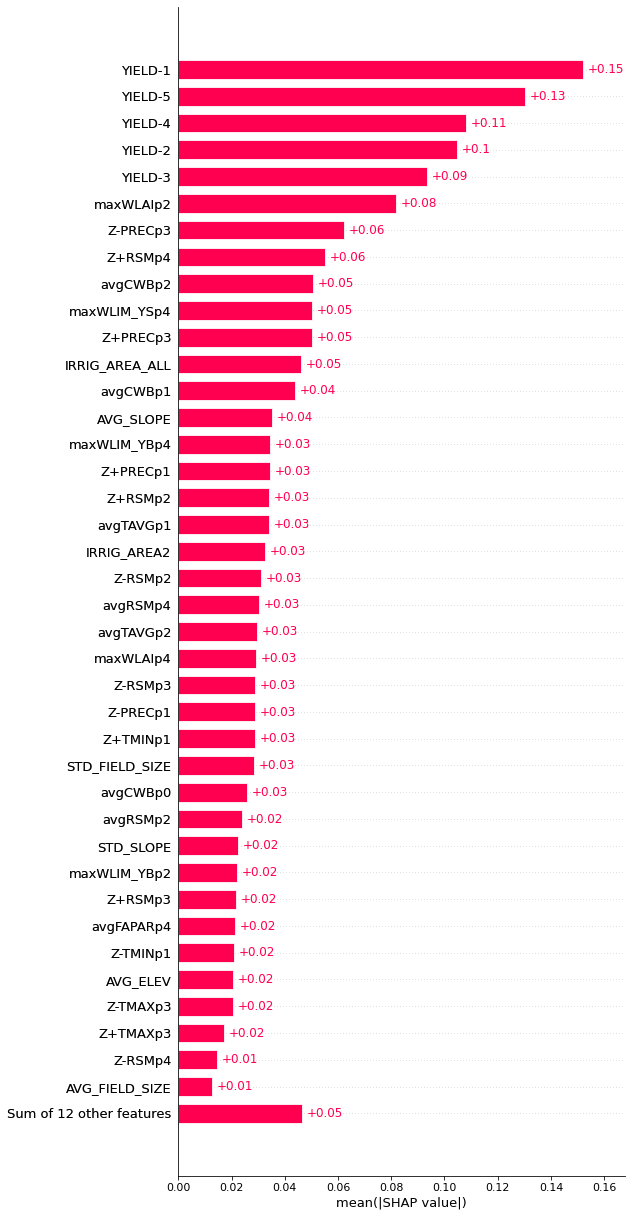

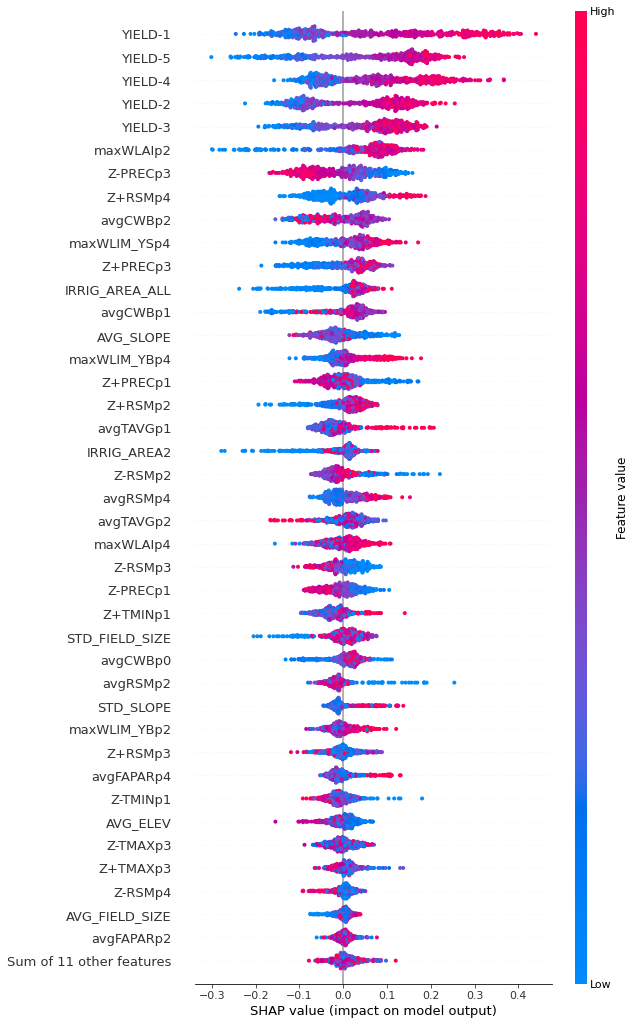

In [ ]:
import shap

if (use_saved_features):
    pd_train_df, pd_test_df = loadSavedFeaturesLabels(cyp_config, spark)

if (country == 'FR'):
  all_cols = list(pd_train_df.columns)
  ft_cols = all_cols[2:-2]
  label_cols = all_cols[:2] + all_cols[-2:]

  X_train = pd_train_df[ft_cols].values
  Y_train_full = pd_train_df[label_cols].values
  X_test = pd_test_df[ft_cols].values
  Y_test_full = pd_test_df[label_cols].values

  Y_train = Y_train_full[:, -1]
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  # Soft Wheat, FR
  # estimator__learning_rate=0.02530420354612464
  # estimator__loss=lad
  # estimator__min_samples_leaf=5
  # selector__estimator__alpha=0.01
  # selector__n_features_to_select=49

  # Grain Maize, FR
  # estimator__learning_rate=0.1
  # estimator__loss=lad
  # estimator__min_samples_leaf=20
  # selector__estimator__alpha=0.01
  # selector__n_features_to_select=50

  if (crop == 'soft wheat'):
    lr = 0.025
  else:
    lr = 0.1

  model = GradientBoostingRegressor(loss='lad', max_features='log2',
                                    max_depth=10, min_samples_leaf=5,
                                    tol=1e-3, n_iter_no_change=5,
                                    subsample=0.6, ccp_alpha=1e-2,
                                    learning_rate=lr,
                                    n_estimators=500, random_state=42)
  model.fit(X_train, Y_train)
  # model = xgboost.XGBRegressor().fit(X_train, Y_train)

  # explain the model's predictions using SHAP
  explainer = shap.Explainer(model, feature_names=ft_cols)
  shap_values = explainer(X_test)

  shap.plots.bar(shap_values, max_display=40)
  shap.plots.beeswarm(shap_values, max_display=41)

### Compare Predictions with JRC Predictions

In [ ]:
if (test_env == 'notebook'):

  if (use_saved_predictions):
    pd_ml_predictions = loadSavedPredictions(cyp_config, spark)

  compareWithMCYFS = cyp_config.compareWithMCYFS()
  if (compareWithMCYFS):
    comparePredictionsWithMCYFS(sqlContext, cyp_config, pd_ml_predictions, log_fh)

  log_fh.close()

In [ ]:
# ! mv *.log *.csv drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/GBDT-outputs